# Requirements

In [ ]:
%%capture
!pip install gdown

In [ ]:
import gdown
import zipfile

In [ ]:
# Download features for all datasets
url = 'https://drive.google.com/file/d/1cWQ0OH0iNngRC0mNyMYlqabbvIkgaHlm/view?usp=sharing'
output = 'features.zip'
gdown.download(url, output, quiet=False, fuzzy=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

Downloading...
From (original): https://drive.google.com/uc?id=1cWQ0OH0iNngRC0mNyMYlqabbvIkgaHlm
From (redirected): https://drive.google.com/uc?id=1cWQ0OH0iNngRC0mNyMYlqabbvIkgaHlm&confirm=t&uuid=65b7687e-42e0-41ef-a455-73c1b9f99067
To: /content/features.zip
100%|██████████| 158M/158M [00:10<00:00, 14.8MB/s]


In [ ]:
# Download EMODB
url = 'https://drive.google.com/file/d/1jVvRW4O2jt2b395r-td8j0jw_pb0lBQt/view?usp=sharing'
output = 'EmoDB_6_3_24'
gdown.download(url, output, quiet=False, fuzzy=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('data/')

Downloading...
From (original): https://drive.google.com/uc?id=1jVvRW4O2jt2b395r-td8j0jw_pb0lBQt
From (redirected): https://drive.google.com/uc?id=1jVvRW4O2jt2b395r-td8j0jw_pb0lBQt&confirm=t&uuid=59f22810-1023-4332-97b7-2606be93101e
To: /content/EmoDB_6_3_24
100%|██████████| 39.9M/39.9M [00:02<00:00, 19.7MB/s]


In [ ]:
# Download Urdu
url = 'https://drive.google.com/file/d/1EHc4q8Qu8Ddeuqm8ZwMRBEENvShnY8s9/view?usp=sharing'
output = 'URDU-Dataset-master.zip'
gdown.download(url, output, quiet=False, fuzzy=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('data/')

Downloading...
From (original): https://drive.google.com/uc?id=1EHc4q8Qu8Ddeuqm8ZwMRBEENvShnY8s9
From (redirected): https://drive.google.com/uc?id=1EHc4q8Qu8Ddeuqm8ZwMRBEENvShnY8s9&confirm=t&uuid=9d59418d-ef08-45c1-9fb0-0c0ba6634f59
To: /content/URDU-Dataset-master.zip
100%|██████████| 75.6M/75.6M [00:01<00:00, 40.2MB/s]


In [ ]:
# Download AESDD
url = 'https://drive.google.com/file/d/1uuYmLNKX7jl2aglJV4HfPd262pWX6mXA/view?usp=sharing'
output = 'AESDD_25_4_24.zip'
gdown.download(url, output, quiet=False, fuzzy=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('data/')

Downloading...
From (original): https://drive.google.com/uc?id=1uuYmLNKX7jl2aglJV4HfPd262pWX6mXA
From (redirected): https://drive.google.com/uc?id=1uuYmLNKX7jl2aglJV4HfPd262pWX6mXA&confirm=t&uuid=e750286e-3b71-47c5-8e70-b3baac74db01
To: /content/AESDD_25_4_24.zip
100%|██████████| 409M/409M [00:08<00:00, 47.8MB/s]


In [ ]:
%%capture
! pip install opensmile
! pip install audeer
! pip install audmetric
! pip install audplot
! pip install torchaudio
! pip install pydub

In [ ]:
from joblib import dump, load
import os
import json
import numpy as np
import pandas as pd
import opensmile
import audeer
import audplot
import audmetric
import torchaudio
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from pydub import AudioSegment
import itertools
import librosa

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.spatial.distance import euclidean, cityblock, chebyshev, minkowski, mahalanobis, cosine
from sklearn.manifold import TSNE

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model, AutoConfig
from transformers import AutoProcessor, AutoModelForAudioClassification, Wav2Vec2FeatureExtractor, AutoModel, Wav2Vec2ForCTC, Wav2Vec2Config

In [ ]:
# Benchmark against hand-crafted features
smile_ComParE_2016 = opensmile.Smile(
    opensmile.FeatureSet.ComParE_2016,
    opensmile.FeatureLevel.Functionals,
    sampling_rate=16000,
    resample=True,
    num_workers=5,
    verbose=True,
)

In [ ]:
smile_eGeMAPSv02 = opensmile.Smile(
    opensmile.FeatureSet.eGeMAPSv02,
    opensmile.FeatureLevel.Functionals,
    sampling_rate=16000,
    resample=True,
    num_workers=5,
    verbose=True,
)

In [ ]:
results_path = '/content/results'

# Functions

## Import data

In [ ]:
def import_data(dataset):
  if dataset not in ['EMODB', 'EmoTale', 'DES', 'Urdu', 'AESDD']:
    print('Invalid dataset')

  elif dataset == 'EMODB':
    audio_folder = "/content/data/EmoDB/wav/"
    filenames = []
    data = {'path':[], 'filename': [], 'speaker':[], 'emotion':[], 'sentence':[]}
    df_EMODB = pd.DataFrame(data)

    for filename in os.listdir(audio_folder):
        if filename.endswith(".wav"):
            filenames.append(filename)
            emotion = filename[5]
            speaker = filename[:2]
            sentence = filename[3:5]
            path = os.path.join(audio_folder, filename)
            df_EMODB.loc[len(df_EMODB.index)] = [path, filename, speaker, emotion, sentence]
    emo_dict= {'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
    df_EMODB["emotion"] = df_EMODB["emotion"].map(emo_dict)

    print(f"dataset shape: {df_EMODB.shape}")
    return df_EMODB.sort_values(by='filename').reset_index(drop = True)

  elif dataset == 'Urdu':
    audio_folder = '/content/data/URDU-Dataset-master'
    filenames = []
    data = {'path':[], 'filename':[], 'speaker':[], 'emotion':[], 'gender': []}
    df_Urdu = pd.DataFrame(data)
    emo_dict= {'A': 'anger', 'H': 'happiness', 'S': 'sadness', 'N': 'neutral'}

    for subdir in os.listdir(audio_folder):
        subdir_path = os.path.join(audio_folder, subdir)

        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith(".wav"):
                    filenames.append(filename)
                    path = os.path.join(subdir_path, filename)
                    parts = filename.split('_')
                    gender_id = parts[0]
                    file_no = parts[1]
                    emotion_id = parts[2]
                    gender = gender_id[1]
                    speaker_id = gender_id[2:]
                    file_id = file_no[1:]
                    emotion = emotion_id[0]
                    emotion_no = emotion_id[1:]

                    df_Urdu.loc[len(df_Urdu.index)] = [path, filename, speaker_id, emotion, gender]
    df_Urdu["emotion"] = df_Urdu["emotion"].map(emo_dict)
    print(f"dataset shape: {df_Urdu.shape}")
    return df_Urdu.sort_values(by='filename').reset_index(drop = True)

  elif dataset == 'AESDD':
    audio_folder = "/content/data/Acted Emotional Speech Dynamic Database/"
    filenames = []
    data = {'path':[], 'filename':[], 'speaker':[], 'emotion':[], 'sentence':[]}
    df_AESDD = pd.DataFrame(data)

    emo_dict= {'a': 'anger', 'd': 'disgust', 'f': 'fear', 'h': 'happiness', 's': 'sadness',}
    # Iterate over all subfolders in the audio_folder
    for subdir in os.listdir(audio_folder):
        subdir_path = os.path.join(audio_folder, subdir)

        # Check if it's a directory
        if os.path.isdir(subdir_path):

            # Iterate over all files in the subfolder
            for filename in os.listdir(subdir_path):
              if filename.endswith(".wav"):
                path = os.path.join(subdir_path, filename)
                file = filename
                emotion = filename[0]
                sentence = filename[1:3]
                speaker = filename.split(')')[0][-1]
                df_AESDD.loc[len(df_AESDD.index)] = [path, filename, speaker, emotion, sentence]
    df_AESDD["emotion"] = df_AESDD["emotion"].map(emo_dict)
    df_AESDD = df_AESDD[df_AESDD['filename'] != 's05 (3).wav']
    df_AESDD = df_AESDD.reset_index(drop=True)

    print(f"dataset shape: {df_AESDD.shape}")
    return df_AESDD.sort_values(by='filename').reset_index(drop = True)

## Define SVM classifier

In [ ]:
# create classifier and grouping object
clf = make_pipeline(
    StandardScaler(),
    OneVsOneClassifier(SVC(kernel = 'linear', random_state=42)),
    # OneVsRestClassifier(SVC(kernel = 'linear', random_state=42, probability = True))
)

logo = LeaveOneGroupOut()

def experiment(
    features,
    targets,
    groups,
    sentences,
    file_paths,
    pbar = True
):
    truths = []
    preds = []
    speakers = []
    sentence_ids = []
    paths = []
    coefs = []
    all_coefs = []

    # leave-one-speaker loop
    if pbar:
      pbar = audeer.progress_bar(
          total=len(groups.unique()),
          desc='Run experiment',
    )
    for train_index, test_index in logo.split(
        features,
        targets,
        groups=groups,
    ):
        train_x = features.iloc[train_index]
        train_y = targets[train_index]
        test_group = groups.iloc[test_index].unique()[0]
        test_sentences = sentences.iloc[test_index]
        test_paths = file_paths.iloc[test_index]
        clf.fit(train_x, train_y)

        truth_x = features.iloc[test_index]
        truth_y = targets[test_index]
        predict_y = clf.predict(truth_x)

        truths.append(truth_y)
        preds.append(predict_y)
        speakers.extend([test_group] * len(truth_y))
        sentence_ids.extend(test_sentences)
        paths.extend(test_paths)

        if pbar:
          pbar.update()

    # combine speaker folds
    truth = pd.concat(truths)
    truth.name = 'truth'
    pred = pd.Series(
        np.concatenate(preds),
        index=truth.index,
        name='prediction',
    )
    speaker_series = pd.Series(speakers, index=truth.index, name='speaker')
    sentence_series = pd.Series(sentence_ids, index=truth.index, name='sentence')
    path_series = pd.Series(paths, index=truth.index, name='path')

    results_df = pd.concat([truth, pred, speaker_series, sentence_series, path_series], axis=1)
    results_df = results_df.reset_index(drop=True)

    return results_df

## Extract SVM coefficients

In [ ]:
def extract_ovr_coefficients(clf, feature_names):
    class_names = clf.named_steps['onevsrestclassifier'].classes_
    num_classes = len(class_names)

    data = []

    # Iterate over each classifier and extract coefficients
    for class_index in range(num_classes):
        estimator = clf.named_steps['onevsrestclassifier'].estimators_[class_index]
        coefs = estimator.coef_[0]  # Get the coefficients for this classifier

        # Append data including class and coefficients
        data.append({
            "Class": class_names[class_index],
            **{f"coef_{name}": coef for name, coef in zip(feature_names, coefs)}
        })

    # Create a DataFrame
    coef_df = pd.DataFrame(data)

    return coef_df

## Define HuggingFace feature extractor

Function to extract embeddings from pre-trained models and apply mean pooling

```py
def prepare_features(audio_file_path):
  waveform, sample_rate = torchaudio.load(audio_file_path)

  if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
        sample_rate = 16000  # Update the sample rate to reflect the change

  # check if waveform is mono or stereo and convert to mono by averaging channels. wav2vec2 expects a single-channel (mono) input
  if waveform.dim() > 1:
        waveform = waveform.mean(dim=0)

  input = processor(waveform.squeeze(), sampling_rate=sample_rate, return_tensors="pt")#.input_values

  with torch.no_grad():
      outputs = model(**input)

  # .mean(axis = 0) applies average pooling to reduce dimensionality
  last_hidden_states = outputs.last_hidden_state.squeeze().mean(axis = 0).numpy()

  return last_hidden_states
```

## Performance metrics

In [ ]:
# Function to calculate UAR with audmetric
def calculate_uar(group):
    return audmetric.unweighted_average_recall(group['truth'], group['prediction'])

In [ ]:
def calculate_ccc(truth, prediction):
    return audmetric.concordance_cc(truth, prediction)

In [ ]:
def compute_metrics(true_labels, predicted_labels):
    uar = recall_score(true_labels, predicted_labels, average='macro')
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    return uar, macro_f1

def compute_metrics_acc(true_labels, predicted_labels):
    uar = recall_score(true_labels, predicted_labels, average='macro')
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    accuracy = accuracy_score(true_labels, predicted_labels)
    return uar, macro_f1, accuracy

## Compute total duration of audio files in a dataset

In [ ]:
def get_duration(file_path):
    try:
        audio = AudioSegment.from_file(file_path)
        return len(audio)  # duration in milliseconds
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return 0

def get_total_duration(df):
  duration_ms = df['path'].apply(get_duration)
  total_duration_ms = duration_ms.sum()

  total_seconds = total_duration_ms / 1000
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60

  print(f"Total Duration: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

# Import datasets

## EMODB

In [ ]:
df_EMODB = import_data('EMODB')

dataset shape: (535, 5)


In [ ]:
df_EMODB.head()

path     filename speaker    emotion  \
0  /content/data/EmoDB/wav/03a01Fa.wav  03a01Fa.wav      03  happiness   
1  /content/data/EmoDB/wav/03a01Nc.wav  03a01Nc.wav      03    neutral   
2  /content/data/EmoDB/wav/03a01Wa.wav  03a01Wa.wav      03      anger   
3  /content/data/EmoDB/wav/03a02Fc.wav  03a02Fc.wav      03  happiness   
4  /content/data/EmoDB/wav/03a02Nc.wav  03a02Nc.wav      03    neutral   

  sentence  
0       01  
1       01  
2       01  
3       02  
4       02

In [ ]:
print("Labels: ", df_EMODB["emotion"].unique())
print()
df_EMODB.groupby("emotion").count()[["path"]]

Labels:  ['happiness' 'neutral' 'anger' 'sadness' 'fear' 'boredom' 'disgust']



path
emotion        
anger       127
boredom      81
disgust      46
fear         69
happiness    71
neutral      79
sadness      62

In [ ]:
get_total_duration(df_EMODB)

Total Duration: 0 hours, 24 minutes, 47.10 seconds


## Urdu

In [ ]:
df_Urdu = import_data('Urdu')

dataset shape: (400, 5)


In [ ]:
df_Urdu.head()

path         filename speaker  \
0  /content/data/URDU-Dataset-master/Sad/SF10_F1_...  SF10_F1_S01.wav      10   
1  /content/data/URDU-Dataset-master/Sad/SF10_F2_...  SF10_F2_S02.wav      10   
2  /content/data/URDU-Dataset-master/Sad/SF11_F1_...  SF11_F1_S03.wav      11   
3  /content/data/URDU-Dataset-master/Sad/SF11_F2_...  SF11_F2_S04.wav      11   
4  /content/data/URDU-Dataset-master/Sad/SF11_F3_...  SF11_F3_S05.wav      11   

   emotion gender  
0  sadness      F  
1  sadness      F  
2  sadness      F  
3  sadness      F  
4  sadness      F

In [ ]:
print("Labels: ", df_Urdu["emotion"].unique())
print()
df_Urdu.groupby("emotion").count()[["path"]]

Labels:  ['sadness' 'happiness' 'neutral' 'anger']



path
emotion        
anger       100
happiness   100
neutral     100
sadness     100

In [ ]:
get_total_duration(df_Urdu)

Total Duration: 0 hours, 16 minutes, 38.79 seconds


## AESDD

In [ ]:
df_AESDD = import_data('AESDD')

dataset shape: (604, 5)


In [ ]:
df_AESDD.head()

path     filename speaker  \
0  /content/data/Acted Emotional Speech Dynamic D...  a01 (1).wav       1   
1  /content/data/Acted Emotional Speech Dynamic D...  a01 (2).wav       2   
2  /content/data/Acted Emotional Speech Dynamic D...  a01 (3).wav       3   
3  /content/data/Acted Emotional Speech Dynamic D...  a01 (4).wav       4   
4  /content/data/Acted Emotional Speech Dynamic D...  a01 (5).wav       5   

  emotion sentence  
0   anger       01  
1   anger       01  
2   anger       01  
3   anger       01  
4   anger       01

In [ ]:
print("Labels: ", df_AESDD["emotion"].unique())
print()
df_AESDD.groupby("emotion").count()[["path"]]

Labels:  ['anger' 'disgust' 'fear' 'happiness' 'sadness']



path
emotion        
anger       121
disgust     122
fear        120
happiness   119
sadness     122

In [ ]:
print("Labels: ", df_AESDD["speaker"].unique())
print()
df_AESDD.groupby("speaker").count()[["path"]]

Labels:  ['1' '2' '3' '4' '5' '6']



path
speaker      
1         100
2         100
3          98
4          99
5         107
6         100

# Dimensional labels

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1ZEMcsD0mXSdRXHkudsobsATsj4-fzJXb'
df_EMODB_labelled = pd.read_csv(url, index_col = [0])
df_EMODB_labelled = df_EMODB_labelled.sort_values(by='filename').reset_index(drop = True)
df_EMODB_labelled.head()

path     filename  speaker  emotion  \
0  /content/data/EmoDB/wav/03a01Fa.wav  03a01Fa.wav        3    happy   
1  /content/data/EmoDB/wav/03a01Nc.wav  03a01Nc.wav        3  neutral   
2  /content/data/EmoDB/wav/03a01Wa.wav  03a01Wa.wav        3    anger   
3  /content/data/EmoDB/wav/03a02Fc.wav  03a02Fc.wav        3    happy   
4  /content/data/EmoDB/wav/03a02Nc.wav  03a02Nc.wav        3  neutral   

   sentence  activation  valence         A         D         V  \
0         1         3.0      3.0  0.617113  0.642114  0.282111   
1         1         2.0      3.0  0.421313  0.503672  0.239720   
2         1         4.0      2.0  0.867653  0.843206  0.118900   
3         2         3.0      3.5  0.761346  0.726068  0.656233   
4         2         2.0      3.0  0.473012  0.526923  0.573188   

   activation_normalized  valence_normalized  A_new  D_new  V_new  
0                   0.50               0.500    3.5    3.5    2.5  
1                   0.25               0.500    3.0    3.0    2.0  
2                   0.75               0.250    4.5    4.5    1.5  
3                   0.50               0.625    4.0    4.0    4.0  
4                   0.25               0.500    3.0    3.0    4.0

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1tJ0d2Yegj79CgNSUCs4z6AXZTEKtkURf'
df_EmoTale_labelled = pd.read_csv(url, index_col = [0])
df_EmoTale_labelled = df_EmoTale_labelled.sort_values(by='filename').reset_index(drop = True)
df_EmoTale_labelled.head()

path        filename  speaker emotion  \
0  /content/EmoTale/Data/DK_001_A_1.wav  DK_001_A_1.wav        1   anger   
1  /content/EmoTale/Data/DK_001_A_2.wav  DK_001_A_2.wav        1   anger   
2  /content/EmoTale/Data/DK_001_A_3.wav  DK_001_A_3.wav        1   anger   
3  /content/EmoTale/Data/DK_001_A_4.wav  DK_001_A_4.wav        1   anger   
4  /content/EmoTale/Data/DK_001_A_5.wav  DK_001_A_5.wav        1   anger   

   sentence language         A         D         V  A_new  D_new  V_new  \
0         1       DK  0.840006  0.823547  0.484955    4.5    4.5    3.0   
1         2       DK  0.651098  0.653726  0.194918    4.0    3.5    1.5   
2         3       DK  0.632622  0.651731  0.442666    4.0    3.5    2.5   
3         4       DK  0.577070  0.624725  0.602583    3.5    3.5    3.5   
4         5       DK  0.506206  0.594122  0.558544    3.0    3.5    3.0   

   A_manual  V_manual  D_manual  
0       4.0       1.5       4.5  
1       4.0       1.5       4.0  
2       4.0       2.0       4.5  
3       3.5       1.5       4.0  
4       4.0       1.5       4.0

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1-0HBRWoyoeVJJs6HYgo77-WVD0Soz0DK'
df_DES_labelled = pd.read_csv(url, index_col = [0])
df_DES_labelled = df_DES_labelled.sort_values(by='path').reset_index(drop = True)
df_DES_labelled.head()

path speaker emotion sentence         A  \
0   /content/data/DESdb_wav/DHC_AN_NO.wav     DHC   anger       NO  0.251553   
1  /content/data/DESdb_wav/DHC_AN_PA1.wav     DHC   anger      PA1  0.677793   
2  /content/data/DESdb_wav/DHC_AN_PA2.wav     DHC   anger      PA2  0.692909   
3  /content/data/DESdb_wav/DHC_AN_SE1.wav     DHC   anger      SE1  0.399740   
4  /content/data/DESdb_wav/DHC_AN_SE2.wav     DHC   anger      SE2  0.453976   

          D         V  A_new  D_new  V_new  A_manual  V_manual  D_manual  
0  0.310668  0.276542    2.0    2.0    2.5       3.0       1.5       4.0  
1  0.702178  0.798711    4.0    4.0    5.0       3.5       3.0       3.5  
2  0.701929  0.418303    4.0    4.0    3.0       4.0       3.5       4.5  
3  0.396829  0.283251    3.0    2.5    2.5       3.0       3.0       3.5  
4  0.465828  0.630033    3.0    2.5    4.0       4.0       2.0       4.5

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1-BWARagi2bR2UbgtvvoUfEdym14jdhDK'
df_AESDD_labelled = pd.read_csv(url, index_col = [0])
df_AESDD_labelled = df_AESDD_labelled.sort_values(by='filename').reset_index(drop = True)
df_AESDD_labelled.head()

filename  speaker emotion  sentence         A         D         V  \
0  a01 (2).wav        2   anger         1  0.786492  0.724340  0.531676   
1  a01 (4).wav        4   anger         1  0.968443  0.866534  0.577694   
2  a01 (5).wav        5   anger         1  0.866745  0.798643  0.619696   
3  a01 (6).wav        6   anger         1  0.872091  0.837570  0.485987   
4  a02 (1).wav        1   anger         2  0.796048  0.777030  0.532266   

   A_new  D_new  V_new  activation  valence  
0    4.0    4.0    3.0         4.0      2.5  
1    4.5    4.5    3.0         4.5      2.0  
2    4.5    4.0    3.5         4.0      3.0  
3    4.5    4.5    3.0         4.0      3.0  
4    4.0    4.0    3.0         4.5      2.5

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1-4Jt98bAtfyol4MASGaKcPHQBih3hu6f'
df_Urdu_labelled = pd.read_csv(url, index_col = [0])
df_Urdu_labelled = df_Urdu_labelled.sort_values(by='filename').reset_index(drop = True)
df_Urdu_labelled.head()

filename  speaker  emotion gender         A         D         V  \
0  SF10_F1_S01.wav       10  sadness      F  0.500679  0.502049  0.348886   
1  SF10_F2_S02.wav       10  sadness      F  0.403008  0.462565  0.475607   
2  SF11_F1_S03.wav       11  sadness      F  0.425822  0.467809  0.308794   
3  SF11_F2_S04.wav       11  sadness      F  0.427464  0.488294  0.333967   
4  SF11_F3_S05.wav       11  sadness      F  0.576083  0.538318  0.447646   

   A_new  D_new  V_new  activation  valence  
0    2.5    2.5    2.5         3.0      2.5  
1    2.0    2.5    3.0         2.5      2.5  
2    2.5    2.5    2.5         2.0      2.5  
3    2.5    2.5    2.5         2.0      2.5  
4    3.0    3.0    3.0         3.0      3.0

In [ ]:
data = {'corpus': [], 'CCC_A': [], 'CCC_V': [], 'CCC_D': []}
df_CCC = pd.DataFrame(data)

EMODB_CCC_A = round(calculate_ccc(df_EMODB_labelled['activation'], df_EMODB_labelled['A_new']), 3)
EMODB_CCC_V = round(calculate_ccc(df_EMODB_labelled['valence'], df_EMODB_labelled['V_new']), 3)

EmoTale_CCC_A = round(calculate_ccc(df_EmoTale_labelled['A_manual'], df_EmoTale_labelled['A_new']), 3)
EmoTale_CCC_V = round(calculate_ccc(df_EmoTale_labelled['V_manual'], df_EmoTale_labelled['V_new']), 3)
EmoTale_CCC_D = round(calculate_ccc(df_EmoTale_labelled['D_manual'], df_EmoTale_labelled['D_new']), 3)

DES_CCC_A = round(calculate_ccc(df_DES_labelled['A_manual'], df_DES_labelled['A_new']), 3)
DES_CCC_V = round(calculate_ccc(df_DES_labelled['V_manual'], df_DES_labelled['V_new']), 3)
DES_CCC_D = round(calculate_ccc(df_DES_labelled['D_manual'], df_DES_labelled['D_new']), 3)

Urdu_CCC_A = round(calculate_ccc(df_Urdu_labelled['activation'], df_Urdu_labelled['A_new']), 3)
Urdu_CCC_V = round(calculate_ccc(df_Urdu_labelled['valence'], df_Urdu_labelled['V_new']), 3)

AESDD_CCC_A = round(calculate_ccc(df_AESDD_labelled['activation'], df_AESDD_labelled['A_new']), 3)
AESDD_CCC_V = round(calculate_ccc(df_AESDD_labelled['valence'], df_AESDD_labelled['V_new']), 3)

df_CCC.loc[len(df_CCC.index)] = ['EMODB', EMODB_CCC_A, EMODB_CCC_V, 0]
df_CCC.loc[len(df_CCC.index)] = ['EmoTale', EmoTale_CCC_A, EmoTale_CCC_V, EmoTale_CCC_D]
df_CCC.loc[len(df_CCC.index)] = ['DES', DES_CCC_A, DES_CCC_V, DES_CCC_D]
df_CCC.loc[len(df_CCC.index)] = ['Urdu', Urdu_CCC_A, Urdu_CCC_V, 0]
df_CCC.loc[len(df_CCC.index)] = ['AESDD', AESDD_CCC_A, AESDD_CCC_V, 0]

In [ ]:
df_CCC

corpus  CCC_A  CCC_V  CCC_D
0    EMODB  0.825  0.255  0.000
1  EmoTale  0.737  0.254  0.726
2      DES  0.662  0.254  0.494
3     Urdu  0.779  0.280  0.000
4    AESDD  0.717  0.188  0.000

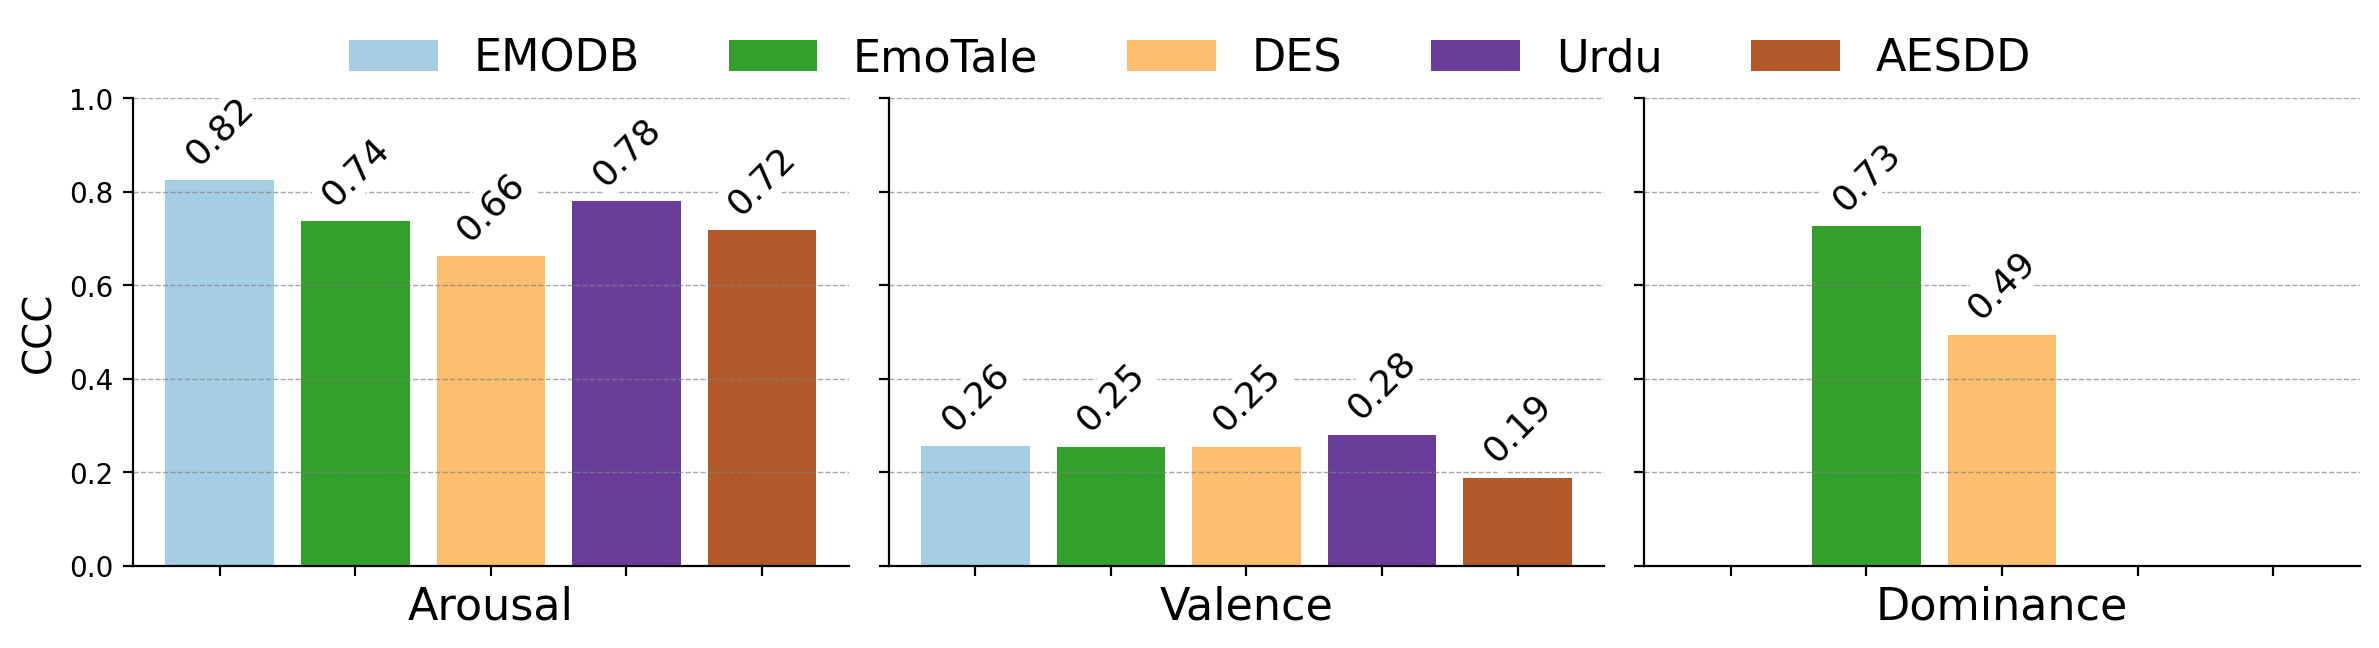

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (12, 3), dpi = 200, sharex = True, sharey = True)

datasets = ['EMODB', 'DES', 'EmoTale', 'Urdu', 'AESDD']

datasets = [df_CCC['CCC_A'], df_CCC['CCC_V'], df_CCC['CCC_D']]
dataset_names = ['Arousal', 'Valence', 'Dominance']

for ax, data, name in zip(axes, datasets, dataset_names):
    bars = ax.bar(df_CCC['corpus'], data, color=plt.cm.Paired(np.linspace(0, 1, len(data))))
    ax.set_title(name, fontsize = 16, y=-0.15)
    ax.set_ylim(0, 1)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    # ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for i, v in enumerate(data):
      if v > 0:
          ax.text(i, v + 0.02, f"{v:.2f}", rotation = 45, ha='center', va='bottom', fontsize=13, bbox=dict(facecolor='white', edgecolor='none', pad=2))
          ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

axes[0].set_ylabel('CCC', fontsize = 14)
fig.legend(bars, df_CCC['corpus'], frameon=False, fontsize=16, loc='upper center', ncol = 5, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.show()

## K-means clustering of dimensional labels

In [ ]:
def custom_kmeans_predict(kmeans, X):
    distances = kmeans.transform(X)
    closest_clusters = np.argmin(distances, axis=1)

    modified_predictions = []
    for i, cluster in enumerate(closest_clusters):
      if cluster == 1:
          second_furthest = np.argsort(distances[i])[-2]
          modified_predictions.append(second_furthest)
      else:
          modified_predictions.append(cluster)

    return modified_predictions

In [ ]:
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.titlesize': 20
})

In [ ]:
emo_dict= {'anger': 'anger', 'boredom': 'boredom', 'disgust': 'disgust', 'fear': 'fear', 'happy': 'happiness', 'sad': 'sadness', 'neutral': 'neutral'}
df_EMODB_labelled['emotion'] = df_EMODB_labelled['emotion'].map(emo_dict)
df_DES_labelled = df_DES_labelled[df_DES_labelled['emotion'].isin(['anger', 'happiness', 'sadness', 'neutral'])].reset_index(drop=True)
df_EMODB_labelled = df_EMODB_labelled[df_EMODB_labelled['emotion'].isin(['anger', 'happiness', 'sadness', 'neutral', 'boredom'])].reset_index(drop=True)

Model performances:

EmoTale: UAR = 0.37, Macro F1 = 0.37
DES: UAR = 0.32, Macro F1 = 0.32
EMODB: UAR = 0.19, Macro F1 = 0.18



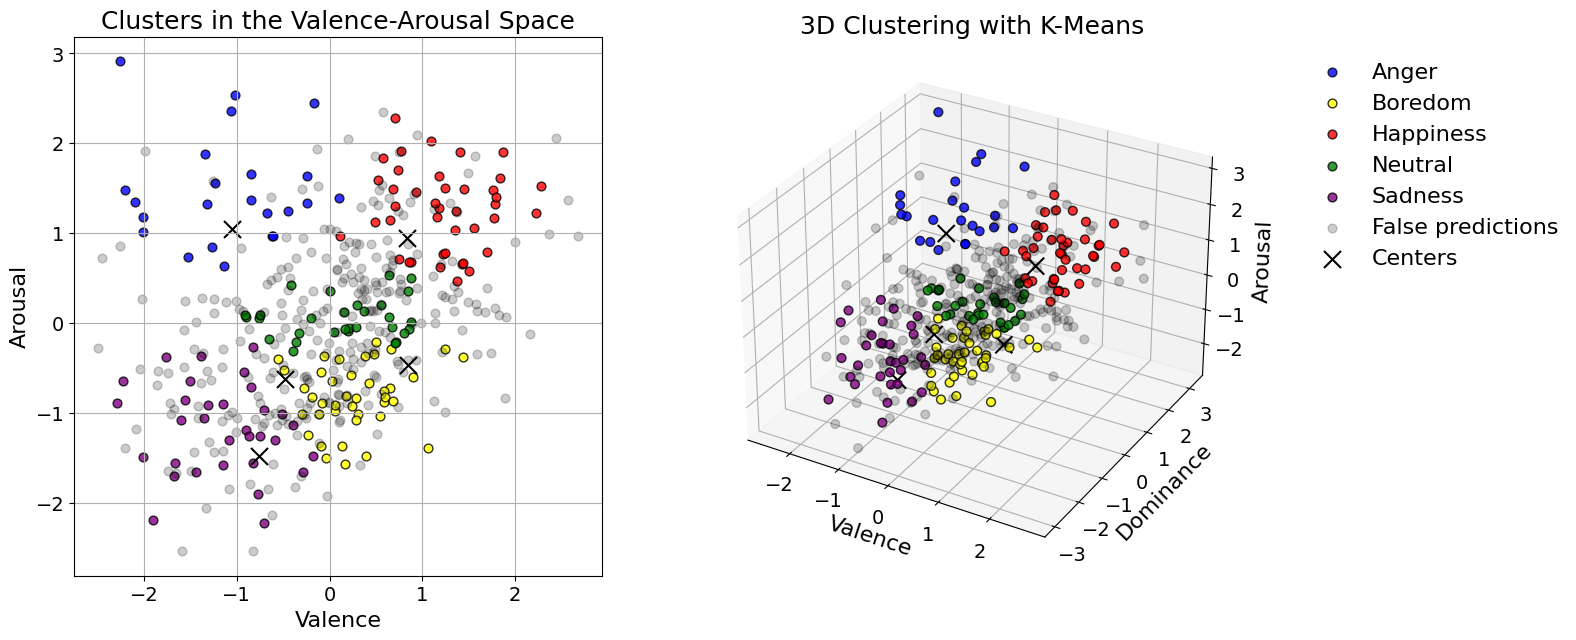

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_EmoTale_labelled[['A', 'V', 'D']])
scaled_data2 = scaler.fit_transform(df_DES_labelled[['A', 'V', 'D']])
scaled_data3 = scaler.fit_transform(df_EMODB_labelled[['A', 'V', 'D']])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
clusters_EmoTale = kmeans.fit_predict(scaled_data)
df_EmoTale_labelled['cluster'] = clusters_EmoTale

clusters_DES = custom_kmeans_predict(kmeans, scaled_data2)
df_DES_labelled['cluster'] = clusters_DES

clusters_EMODB = kmeans.fit_predict(scaled_data3)
df_EMODB_labelled['cluster'] = clusters_EMODB

clusters = clusters_EmoTale

centroids = kmeans.cluster_centers_

true_label_to_cluster = {
    'anger': 0,
    'boredom': 1,
    'happiness': 2,
    'neutral': 3,
    'sadness': 4,
    'suprise': 5
}

cluster_to_label = {
    0: 'Anger',
    1: 'Boredom',
    2: 'Happiness',
    3: 'Neutral',
    4: 'Sadness'
}

# Mapping true labels to numerical values for color coding
label_to_color = {label: idx for idx, label in enumerate(df_EmoTale_labelled['emotion'].unique())}
color_labels = df_EmoTale_labelled['emotion'].map(label_to_color)

# Map true labels to cluster labels
df_EmoTale_labelled['true_cluster'] = df_EmoTale_labelled['emotion'].map(true_label_to_cluster)
df_DES_labelled['true_cluster'] = df_DES_labelled['emotion'].map(true_label_to_cluster)
df_EMODB_labelled['true_cluster'] = df_EMODB_labelled['emotion'].map(true_label_to_cluster)

# Identify false predictions
df_EmoTale_labelled['is_correct'] = df_EmoTale_labelled['cluster'] == df_EmoTale_labelled['true_cluster']

EmoTale_metrics = compute_metrics(df_EmoTale_labelled['true_cluster'], df_EmoTale_labelled['cluster'])
DES_metrics = compute_metrics(df_DES_labelled['true_cluster'], df_DES_labelled['cluster'])
EMODB_metrics = compute_metrics(df_EMODB_labelled['true_cluster'], df_EMODB_labelled['cluster'])
print('Model performances:\n')
print(f'EmoTale: UAR = {EmoTale_metrics[0]:.2f}, Macro F1 = {EmoTale_metrics[1]:.2f}')
print(f'DES: UAR = {DES_metrics[0]:.2f}, Macro F1 = {DES_metrics[1]:.2f}')
print(f'EMODB: UAR = {EMODB_metrics[0]:.2f}, Macro F1 = {EMODB_metrics[1]:.2f}\n')

# Plotting in 3D
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(122, projection='3d')

# Scatter plot for each cluster in 3D
colors = ['blue', 'yellow', 'red', 'green', 'purple']
for i in range(5):
    mask = (clusters == i) & (df_EmoTale_labelled['is_correct'])
    ax.scatter(scaled_data[mask, 1], scaled_data[mask, 2], scaled_data[mask, 0], c=colors[i], s=40, label=cluster_to_label[i], alpha=0.8, edgecolor='k')

# Plot false predictions in black
false_mask = ~df_EmoTale_labelled['is_correct']
ax.scatter(scaled_data[false_mask, 1], scaled_data[false_mask, 2], scaled_data[false_mask, 0], c='black', s=40, label='False predictions', alpha=0.2)

# Plot the centroids
ax.scatter(centroids[:, 1], centroids[:, 2], centroids[:, 0], marker='x', c='k', s=150, label='Centers', alpha=1)

# Add labels and legend
ax.set_title('3D Clustering with K-Means')
ax.set_xlabel('Valence')
ax.set_ylabel('Dominance')
ax.set_zlabel('Arousal')
ax.legend(frameon=False, ncols=1, loc = 'upper left', bbox_to_anchor=(1.1,1))


# Plot clusters
ax2 = fig.add_subplot(121)
for i in range(5):
    mask = (clusters == i) & (df_EmoTale_labelled['is_correct'])
    ax2.scatter(scaled_data[mask, 1], scaled_data[mask, 0], c=colors[i], s=40, label=cluster_to_label[i], alpha=0.8, edgecolor='k')

# Plot false predictions
ax2.scatter(scaled_data[false_mask, 1], scaled_data[false_mask, 0], c='black', s=40, label='False Predictions', alpha=0.2, edgecolor='k')

# Plot centroids
centroids_2d = centroids[:, :2]
ax2.scatter(centroids_2d[:, 1], centroids_2d[:, 0], marker='x', c='k', s=150, label='Centers', alpha=1)
ax2.grid(True)
ax2.set_xlabel('Valence')
ax2.set_ylabel('Arousal')
ax2.set_title('Clusters in the Valence-Arousal Space')

plt.show()


# Example of how features were extracted

```py
def extract_features(audio_files_list, feature_type):

  if feature_type == 'ComParE':
    print(f"Computing {feature_type} features...")
    features = smile_ComParE_2016.process_files(audio_files_list)

  elif feature_type == 'eGeMAPS':
    print(f"Computing {feature_type} features...")
    features = smile_eGeMAPSv02.process_files(audio_files_list)

  elif feature_type == 'wav2vec2':
    print(f"Computing {feature_type} features...")
    audio_file_paths = audio_files_list
    feature_arrays = [prepare_features(path) for path in audio_file_paths]
    features_stacked = np.vstack(feature_arrays)
    features = pd.DataFrame(features_stacked)

  elif feature_type == 'wav2vec2_FT':
    print(f"Computing {feature_type} features...")
    audio_file_paths = audio_files_list
    feature_arrays = [prepare_features(path) for path in audio_file_paths]
    features_stacked = np.vstack(feature_arrays)
    features = pd.DataFrame(features_stacked)

  elif feature_type == 'wav2vec2_FT_2':
    print(f"Computing {feature_type} features...")
    audio_file_paths = audio_files_list
    feature_arrays = [prepare_features_v2(path) for path in audio_file_paths]
    features_stacked = np.vstack(feature_arrays)
    features = pd.DataFrame(features_stacked)

  return features
```

Feature extraction for EMODB

```py
audio_files_list = list(df_EMODB['path'])
emotions = df_EMODB['emotion']
speakers = df_EMODB['speaker']
sentences = df_EMODB['sentence']
paths = df_EMODB['path']

# ComParE
EMODB_features_ComParE_2016 = extract_features(audio_files_list, 'ComParE')

# eGeMAPS
EMODB_features_eGeMAPSv02 = extract_features(audio_files_list, 'eGeMAPS')

# w2v2-b features
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
EMODB_features_wav2vec2 = extract_features(audio_files_list, 'wav2vec2')

# w2v2-FT-dim features
model_name = 'audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim'
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)
EMODB_features_w2v2_FT_dim = extract_features(audio_files_list, 'wav2vec2_FT')

#w2v2-FT-cat features
config = AutoConfig.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
model = AutoModel.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition", config=config)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")
EMODB_features_w2v2_FT_cat = extract_features(audio_files_list, 'wav2vec2_FT_2')

# xlsr-danish
model_name_or_path = "chcaa/xls-r-300m-danish"
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
model = Wav2Vec2Model.from_pretrained(model_name_or_path)
EMODB_features_w2v2_FT_cat = extract_features(audio_files_list, 'wav2vec2_FT')
```

# Load features

In [ ]:
def load_features(dataset, features_name, emotions_list = None, include_info = True):
  if dataset == 'EMODB':
    if features_name == 'ComParE':
      features = pd.read_csv('/content/Features/EMODB_features_ComParE.csv', index_col = [0])
    elif features_name == 'eGeMAPS':
      features = pd.read_csv('/content/Features/EMODB_features_eGeMAPSv02.csv', index_col = [0])
    elif features_name == 'w2v2':
      features = pd.read_csv('/content/Features/EMODB_features_wav2vec2.csv', index_col = [0])
    elif features_name == 'w2v2 FT dim':
      features = pd.read_csv('/content/Features/EMODB_features_w2v2_FT_dim.csv', index_col = [0])
    elif features_name == 'w2v2 FT cat':
      features = pd.read_csv('/content/Features/EMODB_features_w2v2_FT_cat.csv', index_col = [0])
    elif features_name == 'w2v2 FT danish':
      features = pd.read_csv('/content/Features/EMODB_features_w2v2_danish.csv', index_col = [0])

  elif dataset == 'EmoTale':
    if features_name == 'ComParE':
      features = pd.read_csv('/content/Features/EmoTale_features_ComParE.csv', index_col = [0])
    elif features_name == 'eGeMAPS':
      features = pd.read_csv('/content/Features/EmoTale_features_eGeMAPSv02.csv', index_col = [0])
    elif features_name == 'w2v2':
      features = pd.read_csv('/content/Features/EmoTale_features_wav2vec2.csv', index_col = [0])
    elif features_name == 'w2v2 FT dim':
      features = pd.read_csv('/content/Features/EmoTale_features_w2v2_FT_dim.csv', index_col = [0])
    elif features_name == 'w2v2 FT cat':
      features = pd.read_csv('/content/Features/EmoTale_features_w2v2_FT_cat.csv', index_col = [0])

  elif dataset == 'EmoTale_v2':
    if features_name == 'ComParE':
      features = pd.read_csv('/content/Features/EmoTale_v2_features_ComParE.csv', index_col = [0])
    elif features_name == 'eGeMAPS':
      features = pd.read_csv('/content/Features/EmoTale_v2_features_eGeMAPSv02.csv', index_col = [0])
    elif features_name == 'w2v2':
      features = pd.read_csv('/content/Features/EmoTale_v2_features_wav2vec2.csv', index_col = [0])
    elif features_name == 'w2v2 FT dim':
      features = pd.read_csv('/content/Features/EmoTale_v2_features_w2v2_FT_dim.csv', index_col = [0])
    elif features_name == 'w2v2 FT cat':
      features = pd.read_csv('/content/Features/EmoTale_v2_features_w2v2_FT_cat.csv', index_col = [0])
    elif features_name == 'w2v2 FT danish':
      features = pd.read_csv('/content/Features/EmoTale_v2_features_w2v2_danish.csv', index_col = [0])

  elif dataset == 'DES':
    if features_name == 'ComParE':
      features = pd.read_csv('/content/Features/DES_features_ComParE.csv', index_col = [0])
    elif features_name == 'eGeMAPS':
      features = pd.read_csv('/content/Features/DES_features_eGeMAPSv02.csv', index_col = [0])
    elif features_name == 'w2v2':
      features = pd.read_csv('/content/Features/DES_features_wav2vec2.csv', index_col = [0])
    elif features_name == 'w2v2 FT dim':
      features = pd.read_csv('/content/Features/DES_features_w2v2_FT_dim.csv', index_col = [0])
    elif features_name == 'w2v2 FT cat':
      features = pd.read_csv('/content/Features/DES_features_w2v2_FT_cat.csv', index_col = [0])
    elif features_name == 'w2v2 FT danish':
      features = pd.read_csv('/content/Features/DES_features_w2v2_danish.csv', index_col = [0])

  elif dataset == 'Urdu':
    if features_name == 'ComParE':
      features = pd.read_csv('/content/Features/Urdu_features_ComParE.csv', index_col = [0])
    elif features_name == 'eGeMAPS':
      features = pd.read_csv('/content/Features/Urdu_features_eGeMAPSv02.csv', index_col = [0])
    elif features_name == 'w2v2':
      features = pd.read_csv('/content/Features/Urdu_features_wav2vec2.csv', index_col = [0])
    elif features_name == 'w2v2 FT dim':
      features = pd.read_csv('/content/Features/Urdu_features_w2v2_FT_dim.csv', index_col = [0])
    elif features_name == 'w2v2 FT cat':
      features = pd.read_csv('/content/Features/Urdu_features_w2v2_FT_cat.csv', index_col = [0])
    elif features_name == 'w2v2 FT danish':
      features = pd.read_csv('/content/Features/Urdu_features_w2v2_danish.csv', index_col = [0])

  elif dataset == 'AESDD':
    if features_name == 'ComParE':
      features = pd.read_csv('/content/Features/AESDD_features_ComParE.csv', index_col = [0])
    elif features_name == 'eGeMAPS':
      features = pd.read_csv('/content/Features/AESDD_features_eGeMAPSv02.csv', index_col = [0])
    elif features_name == 'w2v2':
      features = pd.read_csv('/content/Features/AESDD_features_wav2vec2.csv', index_col = [0])
    elif features_name == 'w2v2 FT dim':
      features = pd.read_csv('/content/Features/AESDD_features_w2v2_FT_dim.csv', index_col = [0])
    elif features_name == 'w2v2 FT cat':
      features = pd.read_csv('/content/Features/AESDD_features_w2v2_FT_cat.csv', index_col = [0])
    elif features_name == 'w2v2 FT danish':
      features = pd.read_csv('/content/Features/AESDD_features_w2v2_danish.csv', index_col = [0])

  if emotions_list:
    features = features[features['emotion'].isin(emotions_list)].reset_index(drop=True)

  if include_info == False:
    features = features.iloc[:, 4:]

  return features

## EMODB

In [ ]:
EMODB_features_ComParE = load_features('EMODB', 'ComParE')
print(f'ComPare feature dimensions: {EMODB_features_ComParE.shape[1]}')

ComPare feature dimensions: 6377


In [ ]:
EMODB_features_eGeMAPS = load_features('EMODB', 'eGeMAPS')
print(f'eGeMAPS feature dimensions: {EMODB_features_eGeMAPS.shape[1]}')

eGeMAPS feature dimensions: 92


In [ ]:
EMODB_features_w2v2_FT_dim = load_features('EMODB', 'w2v2 FT dim')
print(f'w2v2-FT-dim feature dimensions: {EMODB_features_w2v2_FT_dim.shape[1]}')

w2v2-FT-dim feature dimensions: 1028


In [ ]:
EMODB_features_w2v2_FT_cat = load_features('EMODB', 'w2v2 FT cat')
print(f'w2v2-FT-cat feature dimensions: {EMODB_features_w2v2_FT_cat.shape[1]}')

w2v2-FT-cat feature dimensions: 1028


# RQ1

In [ ]:
def run_experiment(dataset, feature_set):
  feature_df = load_features(dataset, feature_set, include_info = True)
  print(f"Feature shape: {feature_df.shape}")

  if feature_set in ['ComParE', 'eGeMAPS']:
    paths = feature_df['file']
    audio_files_list = list(feature_df['file'])
  else:
    paths = feature_df['path']
    audio_files_list = list(feature_df['path'])

  emotions = feature_df['emotion']
  speakers = feature_df['speaker']
  sentences = feature_df['sentence']

  features = load_features(dataset, feature_set, include_info = False)

  results_df = experiment(features, emotions, speakers, sentences, paths, pbar = False)
  UAR = calculate_uar(results_df)
  # UAR = round(UAR*100, 1)

  return UAR, results_df

In [ ]:
def uar_analysis(ComParE_results_df, eGeMAPS_results_df, wav2vec2_results_df, wav2vec2_FT_results_df, wav2vec2_FT_2_results_df):
  ComParE_speaker_uar = ComParE_results_df.groupby('speaker').apply(calculate_uar).reset_index(name='UAR')
  ComParE_sentence_uar = ComParE_results_df.groupby('sentence').apply(calculate_uar).reset_index(name='UAR')

  eGeMAPS_speaker_uar = eGeMAPS_results_df.groupby('speaker').apply(calculate_uar).reset_index(name='UAR')
  eGeMAPS_sentence_uar = eGeMAPS_results_df.groupby('sentence').apply(calculate_uar).reset_index(name='UAR')

  wav2vec2_speaker_uar = wav2vec2_results_df.groupby('speaker').apply(calculate_uar).reset_index(name='UAR')
  wav2vec2_sentence_uar = wav2vec2_results_df.groupby('sentence').apply(calculate_uar).reset_index(name='UAR')

  wav2vec2_FT_speaker_uar = wav2vec2_FT_results_df.groupby('speaker').apply(calculate_uar).reset_index(name='UAR')
  wav2vec2_FT_sentence_uar = wav2vec2_FT_results_df.groupby('sentence').apply(calculate_uar).reset_index(name='UAR')

  wav2vec2_FT_2_speaker_uar = wav2vec2_FT_2_results_df.groupby('speaker').apply(calculate_uar).reset_index(name='UAR')
  wav2vec2_FT_2_sentence_uar = wav2vec2_FT_2_results_df.groupby('sentence').apply(calculate_uar).reset_index(name='UAR')

  return ComParE_speaker_uar, ComParE_sentence_uar, eGeMAPS_speaker_uar, eGeMAPS_sentence_uar, wav2vec2_speaker_uar, wav2vec2_sentence_uar, wav2vec2_FT_speaker_uar, wav2vec2_FT_sentence_uar, wav2vec2_FT_2_speaker_uar, wav2vec2_FT_2_sentence_uar

In [ ]:
EMODB_ComParE_UAR, EMODB_ComParE_results_df = run_experiment('EMODB', 'ComParE')
print(f"EMODB_ComParE_UAR: {EMODB_ComParE_UAR} \n")

EMODB_eGeMAPS_UAR, EMODB_eGeMAPS_results_df = run_experiment('EMODB', 'eGeMAPS')
print(f"EMODB_eGeMAPS_UAR: {EMODB_eGeMAPS_UAR} \n")

EMODB_w2v2_UAR, EMODB_w2v2_results_df = run_experiment('EMODB', 'w2v2')
print(f"EMODB_w2v2_UAR: {EMODB_w2v2_UAR} \n")

EMODB_w2v2_FT_dim_UAR, EMODB_w2v2_FT_dim_results_df = run_experiment('EMODB', 'w2v2 FT dim')
print(f"EMODB_w2v2_FT_dim_UAR: {EMODB_w2v2_FT_dim_UAR} \n")

EMODB_w2v2_FT_cat_UAR, EMODB_w2v2_FT_cat_results_df = run_experiment('EMODB', 'w2v2 FT cat')
print(f"EMODB_w2v2_FT_cat_UAR: {EMODB_w2v2_FT_cat_UAR} \n")

Feature shape: (535, 6377)
EMODB_ComParE_UAR: 0.7898017213909992 

Feature shape: (535, 92)
EMODB_eGeMAPS_UAR: 0.6426014522225795 

Feature shape: (535, 772)
EMODB_w2v2_UAR: 0.5887130889238231 

Feature shape: (535, 1028)
EMODB_w2v2_FT_dim_UAR: 0.9612705754976391 

Feature shape: (535, 1028)
EMODB_w2v2_FT_cat_UAR: 0.8877037207505628 



In [ ]:
EmoTale_v2_ComParE_UAR, EmoTale_v2_ComParE_results_df = run_experiment('EmoTale_v2', 'ComParE')
print(f"EmoTale_v2_ComParE_UAR: {EmoTale_v2_ComParE_UAR} \n")

EmoTale_v2_eGeMAPS_UAR, EmoTale_v2_eGeMAPS_results_df = run_experiment('EmoTale_v2', 'eGeMAPS')
print(f"EmoTale_v2_eGeMAPS_UAR: {EmoTale_v2_eGeMAPS_UAR} \n")

EmoTale_v2_w2v2_UAR, EmoTale_v2_w2v2_results_df = run_experiment('EmoTale_v2', 'w2v2')
print(f"EmoTale_v2_w2v2_UAR: {EmoTale_v2_w2v2_UAR} \n")

EmoTale_v2_w2v2_FT_dim_UAR, EmoTale_v2_w2v2_FT_dim_results_df = run_experiment('EmoTale_v2', 'w2v2 FT dim')
print(f"EmoTale_v2_w2v2_FT_dim_UAR: {EmoTale_v2_w2v2_FT_dim_UAR,} \n")

EmoTale_v2_w2v2_FT_cat_UAR, EmoTale_v2_w2v2_FT_cat_results_df = run_experiment('EmoTale_v2', 'w2v2 FT cat')
print(f"EmoTale_v2_w2v2_FT_cat_UAR: {EmoTale_v2_w2v2_FT_cat_UAR,} \n")

Feature shape: (800, 6377)
EmoTale_v2_ComParE_UAR: 0.5199999999999999 

Feature shape: (800, 92)
EmoTale_v2_eGeMAPS_UAR: 0.4600000000000001 

Feature shape: (800, 772)
EmoTale_v2_w2v2_UAR: 0.2975 

Feature shape: (800, 1028)
EmoTale_v2_w2v2_FT_dim_UAR: (0.6412499999999999,) 

Feature shape: (800, 1028)
EmoTale_v2_w2v2_FT_cat_UAR: (0.59625,) 



In [ ]:
DES_ComParE_UAR, DES_ComParE_results_df = run_experiment('DES', 'ComParE')
print(f"DES_ComParE_UAR: {DES_ComParE_UAR} \n")

DES_eGeMAPS_UAR, DES_eGeMAPS_results_df = run_experiment('DES', 'eGeMAPS')
print(f"DES_eGeMAPS_UAR: {DES_eGeMAPS_UAR} \n")

DES_w2v2_UAR, DES_w2v2_results_df = run_experiment('DES', 'w2v2')
print(f"DES_w2v2_UAR: {DES_w2v2_UAR} \n")

DES_w2v2_FT_dim_UAR, DES_w2v2_FT_dim_results_df = run_experiment('DES', 'w2v2 FT dim')
print(f"DES_w2v2_FT_dim_UAR: {DES_w2v2_FT_dim_UAR,} \n")

DES_w2v2_FT_cat_UAR, DES_w2v2_FT_cat_results_df = run_experiment('DES', 'w2v2 FT cat')
print(f"DES_w2v2_FT_cat_UAR: {DES_w2v2_FT_cat_UAR,} \n")

Feature shape: (260, 6377)
DES_ComParE_UAR: 0.48461538461538456 

Feature shape: (260, 92)
DES_eGeMAPS_UAR: 0.4269230769230769 

Feature shape: (260, 772)
DES_w2v2_UAR: 0.32692307692307687 

Feature shape: (260, 1028)
DES_w2v2_FT_dim_UAR: (0.676923076923077,) 

Feature shape: (260, 1028)
DES_w2v2_FT_cat_UAR: (0.626923076923077,) 



In [ ]:
Urdu_ComParE_UAR, Urdu_ComParE_results_df = run_experiment('Urdu', 'ComParE')
print(f"Urdu_ComParE_UAR: {Urdu_ComParE_UAR} \n")

Urdu_eGeMAPS_UAR, Urdu_eGeMAPS_results_df = run_experiment('Urdu', 'eGeMAPS')
print(f"Urdu_eGeMAPS_UAR: {Urdu_eGeMAPS_UAR} \n")

Urdu_w2v2_UAR, Urdu_w2v2_results_df = run_experiment('Urdu', 'w2v2')
print(f"Urdu_w2v2_UAR: {Urdu_w2v2_UAR} \n")

Urdu_w2v2_FT_dim_UAR, Urdu_w2v2_FT_dim_results_df = run_experiment('Urdu', 'w2v2 FT dim')
print(f"Urdu_w2v2_FT_dim_UAR: {Urdu_w2v2_FT_dim_UAR,} \n")

Urdu_w2v2_FT_cat_UAR, Urdu_w2v2_FT_cat_results_df = run_experiment('Urdu', 'w2v2 FT cat')
print(f"Urdu_w2v2_FT_cat_UAR: {Urdu_w2v2_FT_cat_UAR,} \n")

Feature shape: (400, 6377)
Urdu_ComParE_UAR: 0.5 

Feature shape: (400, 92)
Urdu_eGeMAPS_UAR: 0.58 

Feature shape: (400, 772)
Urdu_w2v2_UAR: 0.33499999999999996 

Feature shape: (400, 1028)
Urdu_w2v2_FT_dim_UAR: (0.595,) 

Feature shape: (400, 1028)
Urdu_w2v2_FT_cat_UAR: (0.525,) 



In [ ]:
AESDD_ComParE_UAR, AESDD_ComParE_results_df = run_experiment('AESDD', 'ComParE')
print(f"AESDD_ComParE_UAR: {AESDD_ComParE_UAR} \n")

AESDD_eGeMAPS_UAR, AESDD_eGeMAPS_results_df = run_experiment('AESDD', 'eGeMAPS')
print(f"AESDD_eGeMAPS_UAR: {AESDD_eGeMAPS_UAR} \n")

AESDD_w2v2_UAR, AESDD_w2v2_results_df = run_experiment('AESDD', 'w2v2')
print(f"AESDD_w2v2_UAR: {AESDD_w2v2_UAR} \n")

AESDD_w2v2_FT_dim_UAR, AESDD_w2v2_FT_dim_results_df = run_experiment('AESDD', 'w2v2 FT dim')
print(f"AESDD_w2v2_FT_dim_UAR: {AESDD_w2v2_FT_dim_UAR,} \n")

AESDD_w2v2_FT_cat_UAR, AESDD_w2v2_FT_cat_results_df = run_experiment('AESDD', 'w2v2 FT cat')
print(f"AESDD_w2v2_FT_cat_UAR: {AESDD_w2v2_FT_cat_UAR,} \n")

Feature shape: (604, 6377)
AESDD_ComParE_UAR: 0.5797719331602036 

Feature shape: (604, 92)
AESDD_eGeMAPS_UAR: 0.47609738001690316 

Feature shape: (604, 772)
AESDD_w2v2_UAR: 0.41795503786123583 

Feature shape: (604, 1028)
AESDD_w2v2_FT_dim_UAR: (0.8322574161760627,) 

Feature shape: (604, 1028)
AESDD_w2v2_FT_cat_UAR: (0.7747182390094637,) 



In [ ]:
%%capture
EMODB_ComParE_speaker_uar, EMODB_ComParE_sentence_uar, \
EMODB_eGeMAPS_speaker_uar, EMODB_eGeMAPS_sentence_uar, \
EMODB_w2v2_speaker_uar, EMODB_w2v2_sentence_uar, \
EMODB_w2v2_FT_dim_speaker_uar, EMODB_w2v2_FT_dim_sentence_uar, \
EMODB_w2v2_FT_cat_speaker_uar, EMODB_w2v2_FT_cat_sentence_uar = uar_analysis(EMODB_ComParE_results_df, EMODB_eGeMAPS_results_df, EMODB_w2v2_results_df, EMODB_w2v2_FT_dim_results_df, EMODB_w2v2_FT_cat_results_df)

In [ ]:
%%capture
EmoTale_v2_ComParE_speaker_uar, EmoTale_v2_ComParE_sentence_uar, \
EmoTale_v2_eGeMAPS_speaker_uar, EmoTale_v2_eGeMAPS_sentence_uar, \
EmoTale_v2_w2v2_speaker_uar, EmoTale_v2_w2v2_sentence_uar, \
EmoTale_v2_w2v2_FT_dim_speaker_uar, EmoTale_v2_w2v2_FT_dim_sentence_uar, \
EmoTale_v2_w2v2_FT_cat_speaker_uar, EmoTale_v2_w2v2_FT_cat_sentence_uar = uar_analysis(EmoTale_v2_ComParE_results_df, EmoTale_v2_eGeMAPS_results_df, EmoTale_v2_w2v2_results_df, EmoTale_v2_w2v2_FT_dim_results_df, EmoTale_v2_w2v2_FT_cat_results_df)

In [ ]:
%%capture
DES_ComParE_speaker_uar, DES_ComParE_sentence_uar, \
DES_eGeMAPS_speaker_uar, DES_eGeMAPS_sentence_uar, \
DES_w2v2_speaker_uar, DES_w2v2_sentence_uar, \
DES_w2v2_FT_dim_speaker_uar, DES_w2v2_FT_dim_sentence_uar, \
DES_w2v2_FT_cat_speaker_uar, DES_w2v2_FT_cat_sentence_uar = uar_analysis(DES_ComParE_results_df, DES_eGeMAPS_results_df, DES_w2v2_results_df, DES_w2v2_FT_dim_results_df, DES_w2v2_FT_cat_results_df)

In [ ]:
%%capture
Urdu_ComParE_speaker_uar, Urdu_ComParE_sentence_uar, \
Urdu_eGeMAPS_speaker_uar, Urdu_eGeMAPS_sentence_uar, \
Urdu_w2v2_speaker_uar, Urdu_w2v2_sentence_uar, \
Urdu_w2v2_FT_dim_speaker_uar, Urdu_w2v2_FT_dim_sentence_uar, \
Urdu_w2v2_FT_cat_speaker_uar, Urdu_w2v2_FT_cat_sentence_uar = uar_analysis(Urdu_ComParE_results_df, Urdu_eGeMAPS_results_df, Urdu_w2v2_results_df, Urdu_w2v2_FT_dim_results_df, Urdu_w2v2_FT_cat_results_df)

In [ ]:
%%capture
AESDD_ComParE_speaker_uar, AESDD_ComParE_sentence_uar, \
AESDD_eGeMAPS_speaker_uar, AESDD_eGeMAPS_sentence_uar, \
AESDD_w2v2_speaker_uar, AESDD_w2v2_sentence_uar, \
AESDD_w2v2_FT_dim_speaker_uar, AESDD_w2v2_FT_dim_sentence_uar, \
AESDD_w2v2_FT_cat_speaker_uar, AESDD_w2v2_FT_cat_sentence_uar = uar_analysis(AESDD_ComParE_results_df, AESDD_eGeMAPS_results_df, AESDD_w2v2_results_df, AESDD_w2v2_FT_dim_results_df, AESDD_w2v2_FT_cat_results_df)

In [ ]:
df1 = pd.merge(EmoTale_v2_ComParE_speaker_uar, EmoTale_v2_eGeMAPS_speaker_uar, on='speaker').rename(columns = {'UAR_x':'ComParE', 'UAR_y':'eGeMAPS'})
df2 = pd.merge(EmoTale_v2_w2v2_speaker_uar, EmoTale_v2_w2v2_FT_dim_speaker_uar, on='speaker').rename(columns = {'UAR_x':'w2v2', 'UAR_y':'w2v2_FT_dim'})
final_df = pd.merge(df1, df2, on='speaker')
last_final_df = pd.merge(final_df, EmoTale_v2_w2v2_FT_cat_speaker_uar, on='speaker').rename(columns = {'UAR': 'w2v2_FT_cat'})
print("Descriptive stats for EmoTale across speakers:")
print("---------------------------------------------")
last_final_df[['eGeMAPS', 'ComParE', 'w2v2', 'w2v2_FT_dim', 'w2v2_FT_cat']].agg(['mean', 'std']).apply(lambda x: np.round(x*100, 1))

Descriptive stats for EmoTale across speakers:
---------------------------------------------


eGeMAPS  ComParE  w2v2  w2v2_FT_dim  w2v2_FT_cat
mean     44.8     50.9  29.4         62.0         57.8
std      13.8     11.1   6.9         12.4         12.2

In [ ]:
df1 = pd.merge(EmoTale_v2_ComParE_sentence_uar, EmoTale_v2_eGeMAPS_sentence_uar, on='sentence').rename(columns = {'UAR_x':'ComParE', 'UAR_y':'eGeMAPS'})#, 'UAR_y':'eGeMAPS', 'UAR_y':'eGeMAPS'})
df2 = pd.merge(EmoTale_v2_w2v2_sentence_uar, EmoTale_v2_w2v2_FT_dim_sentence_uar, on='sentence').rename(columns = {'UAR_x':'wav2vec2', 'UAR_y':'wav2vec2_FT'})
final_df2 = pd.merge(df1, df2, on='sentence')
last_final_df2 = pd.merge(final_df2, EmoTale_v2_w2v2_FT_cat_sentence_uar, on='sentence').rename(columns = {'UAR': 'wav2vec2_FT_2'})
print("Descriptive stats for EmoTale across sentences:")
print("---------------------------------------------")
last_final_df2[['eGeMAPS', 'ComParE', 'wav2vec2', 'wav2vec2_FT', 'wav2vec2_FT_2']].agg(['mean', 'std']).apply(lambda x: np.round(x*100, 1))

Descriptive stats for EmoTale across sentences:
---------------------------------------------


eGeMAPS  ComParE  wav2vec2  wav2vec2_FT  wav2vec2_FT_2
mean     46.0     52.0      29.8         64.1           59.6
std       3.9      1.5       2.6          5.4            3.5

### RQ1 visualizations

#### Confusion matrix

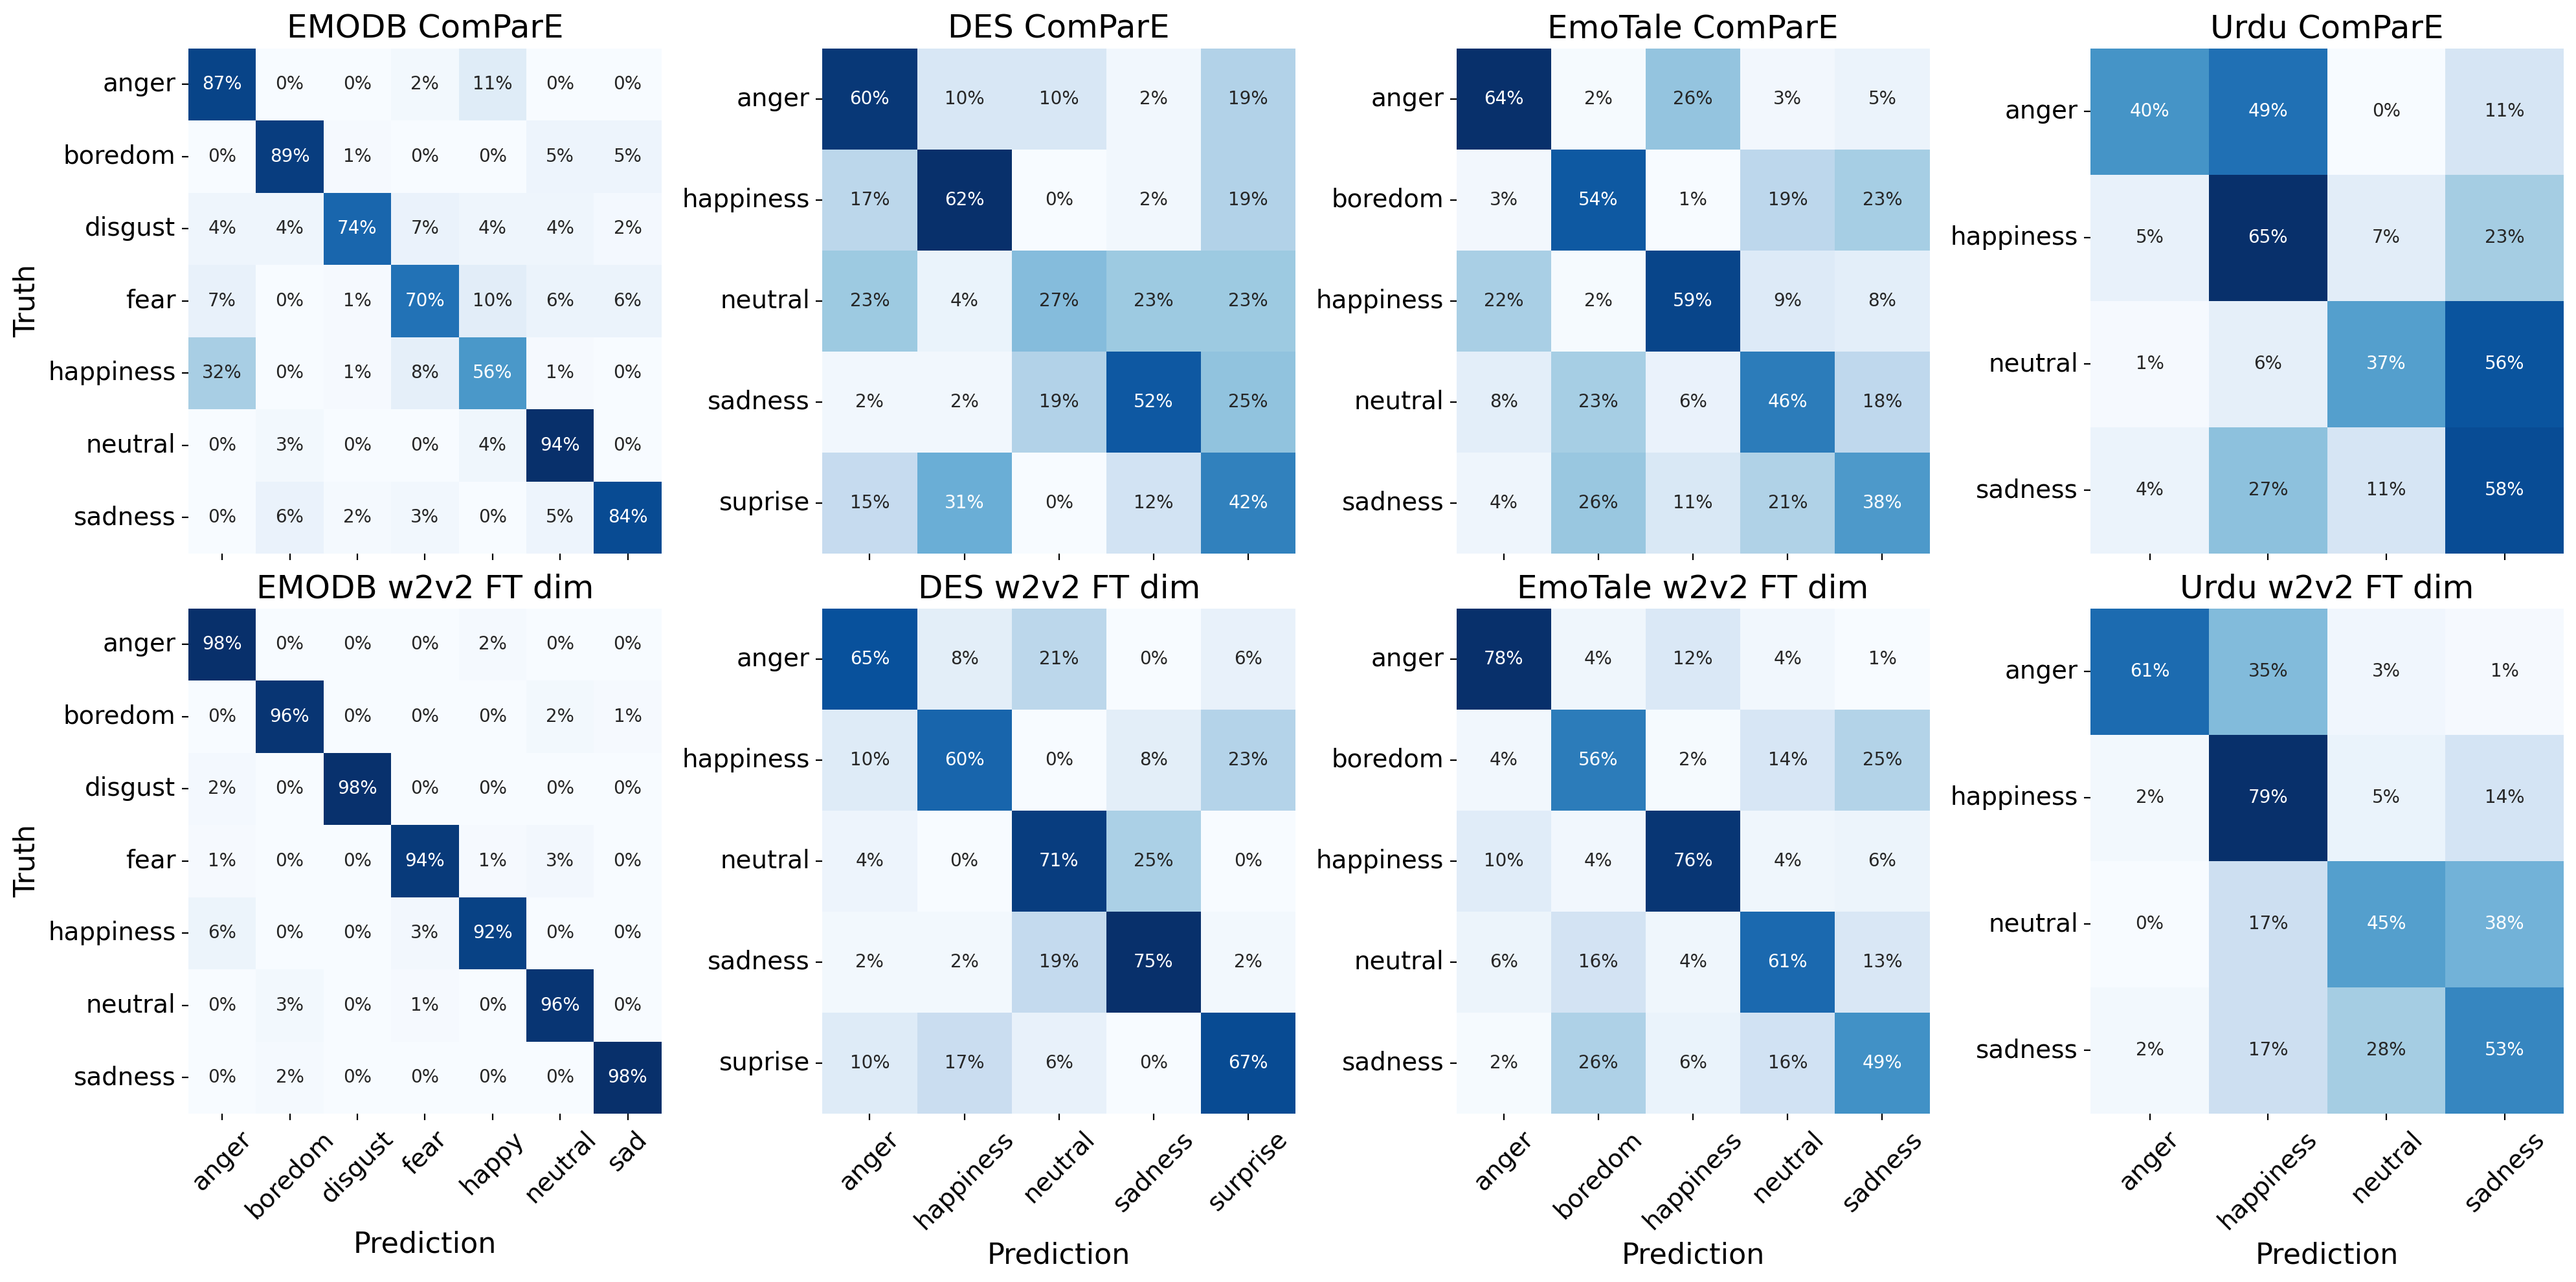

In [ ]:
_, axs = plt.subplots(2, 4, figsize=[20, 10], dpi = 200, sharex = 'col')

axs[0,0].set_title(f'EMODB ComParE')
audplot.confusion_matrix(
    EMODB_ComParE_results_df['truth'],
    EMODB_ComParE_results_df['prediction'],
    percentage=True,
    ax=axs[0,0],
)
axs[0,0].set_xlabel('')

axs[1,0].set_title(f'EMODB w2v2 FT dim')
audplot.confusion_matrix(
    EMODB_w2v2_FT_dim_results_df['truth'],
    EMODB_w2v2_FT_dim_results_df['prediction'],
    percentage=True,
    ax=axs[1,0],
)
axs[1,0].set_xticklabels(['anger', 'boredom', 'disgust', 'fear', 'happy', 'neutral', 'sad'], rotation=45)

axs[0,1].set_title(f'DES ComParE')
audplot.confusion_matrix(
    DES_ComParE_results_df['truth'],
    DES_ComParE_results_df['prediction'],
    percentage=True,
    ax=axs[0,1],
)
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')

axs[1,1].set_title(f'DES w2v2 FT dim')
audplot.confusion_matrix(
    DES_w2v2_FT_dim_results_df['truth'],
    DES_w2v2_FT_dim_results_df['prediction'],
    percentage=True,
    ax=axs[1,1],
)
axs[1,1].set_ylabel('')
axs[1,1].set_xticklabels(['anger', 'happiness', 'neutral', 'sadness', 'surprise'], rotation=45)

axs[0,2].set_title(f'EmoTale ComParE')
audplot.confusion_matrix(
    EmoTale_v2_ComParE_results_df['truth'],
    EmoTale_v2_ComParE_results_df['prediction'],
    percentage=True,
    ax=axs[0,2],
)
axs[0,2].set_ylabel('')
axs[0,2].set_xlabel('')

axs[1,2].set_title(f'EmoTale w2v2 FT dim')
audplot.confusion_matrix(
    EmoTale_v2_w2v2_FT_dim_results_df['truth'],
    EmoTale_v2_w2v2_FT_dim_results_df['prediction'],
    percentage=True,
    ax=axs[1,2],
)
axs[1,2].set_ylabel('')
axs[1,2].set_xticklabels(['anger', 'boredom', 'happiness', 'neutral', 'sadness'], rotation=45)

axs[0,3].set_title(f'Urdu ComParE')
audplot.confusion_matrix(
    Urdu_ComParE_results_df['truth'],
    Urdu_ComParE_results_df['prediction'],
    percentage=True,
    ax=axs[0,3],
)

axs[0,3].set_ylabel('')
axs[0,3].set_xlabel('')

axs[1,3].set_title(f'Urdu w2v2 FT dim')
audplot.confusion_matrix(
    Urdu_w2v2_FT_dim_results_df['truth'],
    Urdu_w2v2_FT_dim_results_df['prediction'],
    percentage=True,
    ax=axs[1,3],
)

axs[1,3].set_ylabel('')
axs[1,3].set_xticklabels(['anger', 'happiness', 'neutral', 'sadness'], rotation=45)

plt.tight_layout()

#### Overall UAR

In [ ]:
EMODB_UAR = [EMODB_ComParE_UAR, EMODB_eGeMAPS_UAR, EMODB_w2v2_UAR, EMODB_w2v2_FT_dim_UAR, EMODB_w2v2_FT_cat_UAR]
DES_UAR = [DES_ComParE_UAR, DES_eGeMAPS_UAR, DES_w2v2_UAR, DES_w2v2_FT_dim_UAR, DES_w2v2_FT_cat_UAR]
EmoTale_UAR = [EmoTale_v2_ComParE_UAR, EmoTale_v2_eGeMAPS_UAR, EmoTale_v2_w2v2_UAR, EmoTale_v2_w2v2_FT_dim_UAR, EmoTale_v2_w2v2_FT_cat_UAR]
Urdu_UAR = [Urdu_ComParE_UAR, Urdu_eGeMAPS_UAR, Urdu_w2v2_UAR, Urdu_w2v2_FT_dim_UAR, Urdu_w2v2_FT_cat_UAR]
AESDD_UAR = [AESDD_ComParE_UAR, AESDD_eGeMAPS_UAR, AESDD_w2v2_UAR, AESDD_w2v2_FT_dim_UAR, AESDD_w2v2_FT_cat_UAR]

df = pd.DataFrame(index=['ComParE', 'eGeMAPS', 'wav2vec2', 'wav2vec2_FT', 'wav2vec2_FT_2'])
df['EMODB'] = EMODB_UAR
df['DES'] = DES_UAR
df['EmoTale'] = EmoTale_UAR
df['Urdu'] = Urdu_UAR
df['AESDD'] = AESDD_UAR
df['Ave'] = df.mean(axis = 1)
df['Std'] = df.std(axis = 1)
df = df.apply(lambda x: np.round(x*100, 1))
df

EMODB   DES  EmoTale  Urdu  AESDD   Ave   Std
ComParE         79.0  48.5     52.0  50.0   58.0  57.5  11.2
eGeMAPS         64.3  42.7     46.0  58.0   47.6  51.7   8.1
wav2vec2        58.9  32.7     29.8  33.5   41.8  39.3  10.6
wav2vec2_FT     96.1  67.7     64.1  59.5   83.2  74.1  13.6
wav2vec2_FT_2   88.8  62.7     59.6  52.5   77.5  68.2  13.1

In [ ]:
EMODB_UAR = [uar*100 for uar in EMODB_UAR]
DES_UAR = [uar*100 for uar in DES_UAR]
EmoTale_UAR = [uar*100 for uar in EmoTale_UAR]
Urdu_UAR = [uar*100 for uar in Urdu_UAR]
AESDD_UAR = [uar*100 for uar in AESDD_UAR]
AVERAGE_UAR = df['Ave'].to_list()
STD_UAR = df['Std'].to_list()

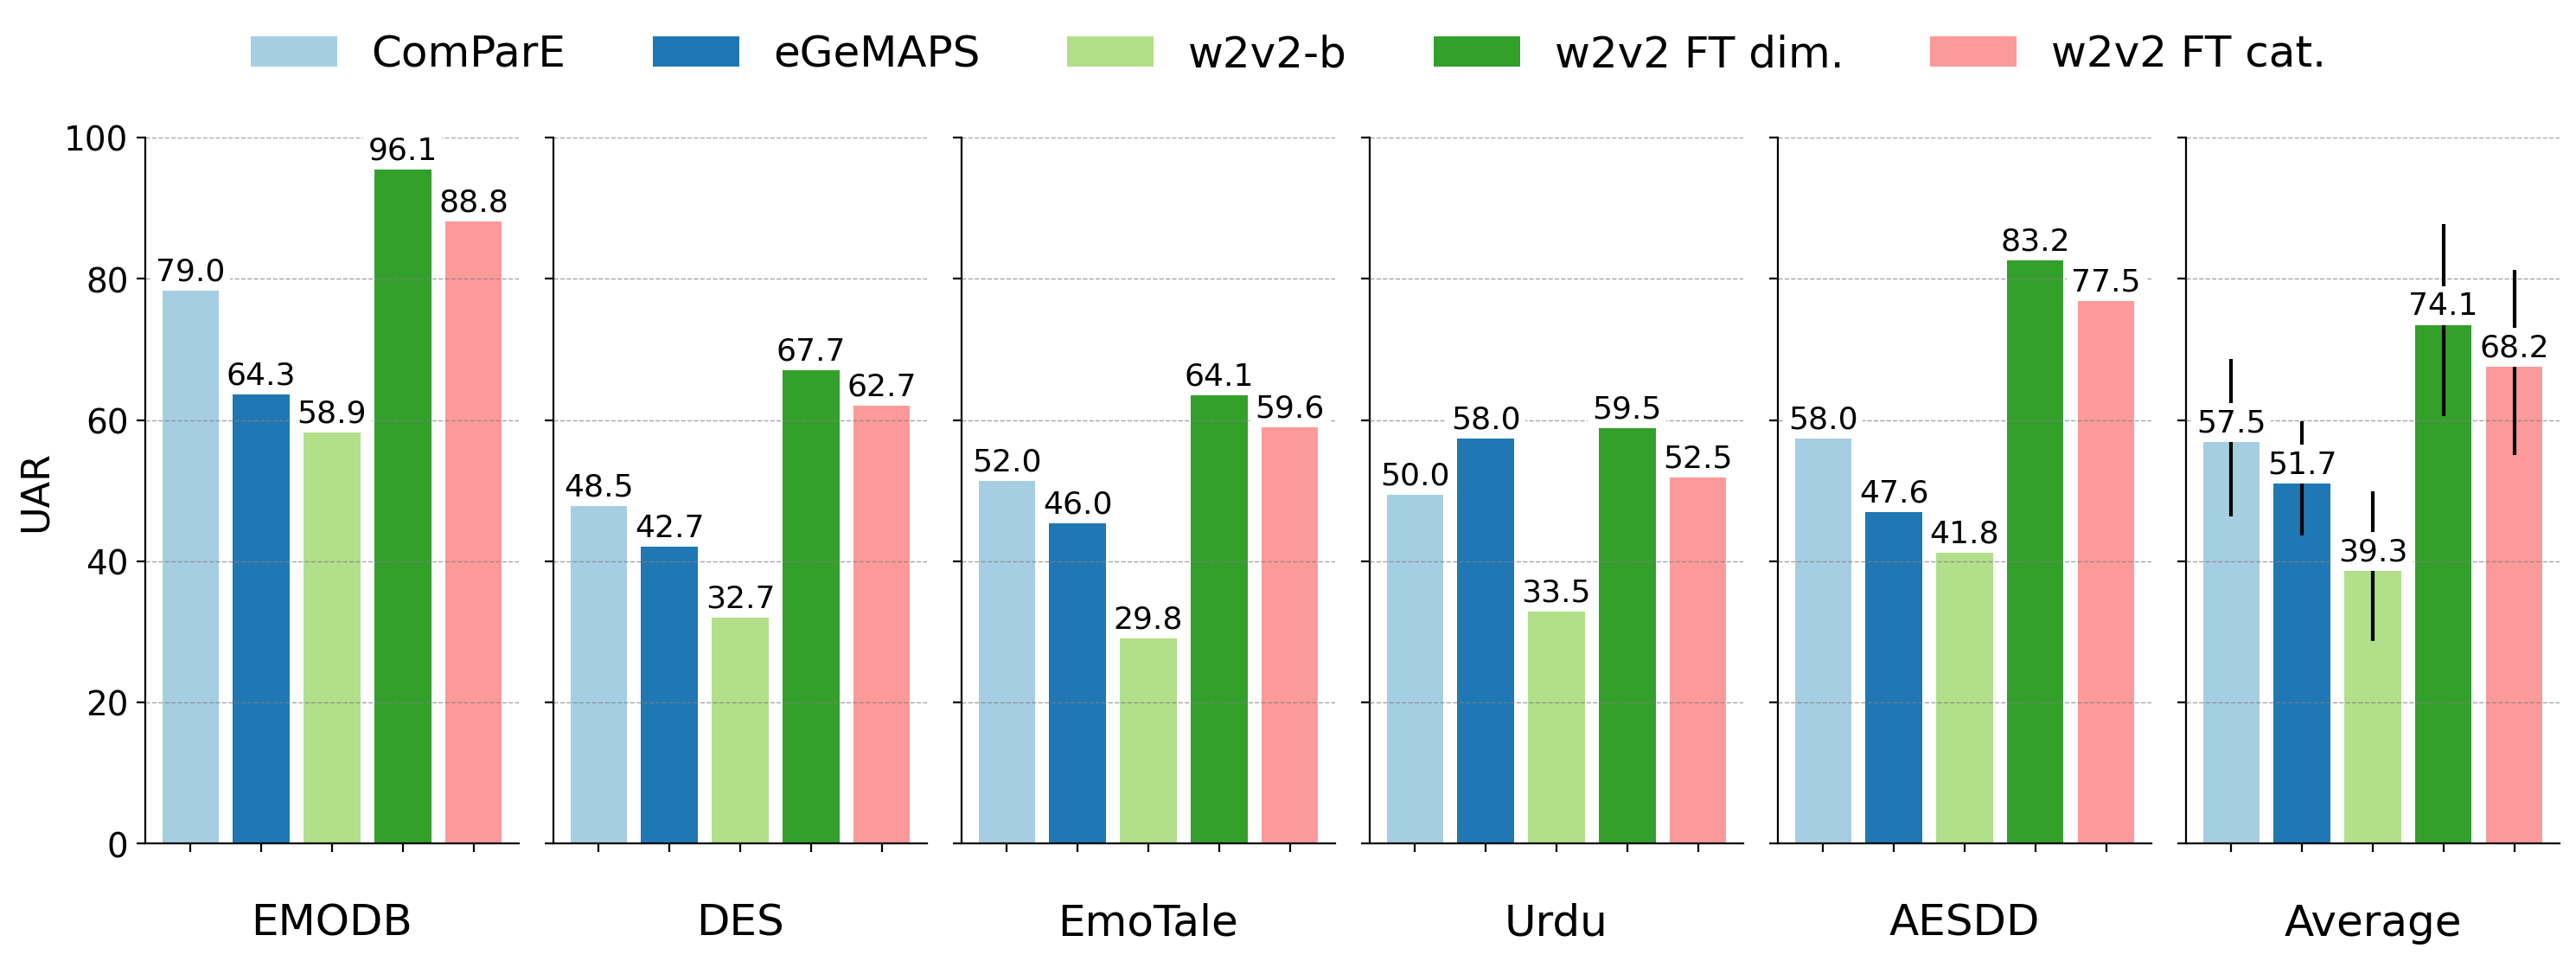

In [ ]:
# Labels for the models
models = ['ComParE', 'eGeMAPS', 'w2v2-b', 'w2v2 FT dim.', 'w2v2 FT cat.']

# Set up the matplotlib figure and axes, one subplot for each dataset
fig, axes = plt.subplots(1, 6, figsize=(15, 5), dpi = 200, sharey = True)

# Data to plot (each dataset in a separate bar plot)
datasets = [EMODB_UAR, DES_UAR, EmoTale_UAR, Urdu_UAR, AESDD_UAR, AVERAGE_UAR]
dataset_names = ['EMODB', 'DES', 'EmoTale', 'Urdu', 'AESDD', 'Average']
ave_errs = STD_UAR

for ax, data, name in zip(axes, datasets, dataset_names):
    if name == 'Average':
      bars = ax.bar(models, data, yerr = ave_errs, color=plt.cm.Paired(np.linspace(0, 0.4, len(data))))
    else:
      bars = ax.bar(models, data, color=plt.cm.Paired(np.linspace(0, 0.4, len(data))))
    ax.set_title(name, fontsize = 18, y=-0.15)
    ax.set_ylim(0, 100)
    ax.set_xticklabels([], fontsize = 16)
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for i, v in enumerate(data):
        ax.text(i, v + 0.02, f"{v:.1f}", ha='center', va='bottom', fontsize=13, bbox=dict(facecolor='white', edgecolor='none', pad = 2))
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)


axes[0].set_ylabel('UAR', fontsize = 16)
fig.legend(bars, models, frameon=False, fontsize=18, loc='upper center', ncol = 6, bbox_to_anchor=(0.5, 1.12))

plt.tight_layout()
plt.show()

#### Sentence UAR

In [ ]:
EMODB_sentence_UAR = [EMODB_ComParE_sentence_uar['UAR'].to_list(), EMODB_eGeMAPS_sentence_uar['UAR'].to_list(), EMODB_w2v2_sentence_uar['UAR'].to_list(), EMODB_w2v2_FT_dim_sentence_uar['UAR'].to_list(), EMODB_w2v2_FT_cat_sentence_uar['UAR'].to_list()]
DES_sentence_UAR = [DES_ComParE_sentence_uar['UAR'].to_list(), DES_eGeMAPS_sentence_uar['UAR'].to_list(), DES_w2v2_sentence_uar['UAR'].to_list(), DES_w2v2_FT_dim_sentence_uar['UAR'].to_list(), DES_w2v2_FT_cat_sentence_uar['UAR'].to_list()]
EmoTale_sentence_UAR = [EmoTale_v2_ComParE_sentence_uar['UAR'].to_list(), EmoTale_v2_eGeMAPS_sentence_uar['UAR'].to_list(), EmoTale_v2_w2v2_sentence_uar['UAR'].to_list(), EmoTale_v2_w2v2_FT_dim_sentence_uar['UAR'].to_list(), EmoTale_v2_w2v2_FT_cat_sentence_uar['UAR'].to_list()]
AESDD_sentence_UAR = [AESDD_ComParE_sentence_uar['UAR'].to_list(), AESDD_eGeMAPS_sentence_uar['UAR'].to_list(), AESDD_w2v2_sentence_uar['UAR'].to_list(), AESDD_w2v2_FT_dim_sentence_uar['UAR'].to_list(), AESDD_w2v2_FT_cat_sentence_uar['UAR'].to_list()]

In [ ]:
EMODB_sentence_uar = [np.mean(uar)*100 for uar in EMODB_sentence_UAR]
DES_sentence_uar = [np.mean(uar)*100 for uar in DES_sentence_UAR]
EmoTale_sentence_uar = [np.mean(uar)*100 for uar in EmoTale_sentence_UAR]
AESDD_sentence_uar = [np.mean(uar)*100 for uar in AESDD_sentence_UAR]

EMODB_sentence_err = [np.std(uar)*100 for uar in EMODB_sentence_UAR]
DES_sentence_err = [np.std(uar)*100 for uar in DES_sentence_UAR]
EmoTale_sentence_err = [np.std(uar)*100 for uar in EmoTale_sentence_UAR]
AESDD_sentence_err = [np.std(uar)*100 for uar in AESDD_sentence_UAR]

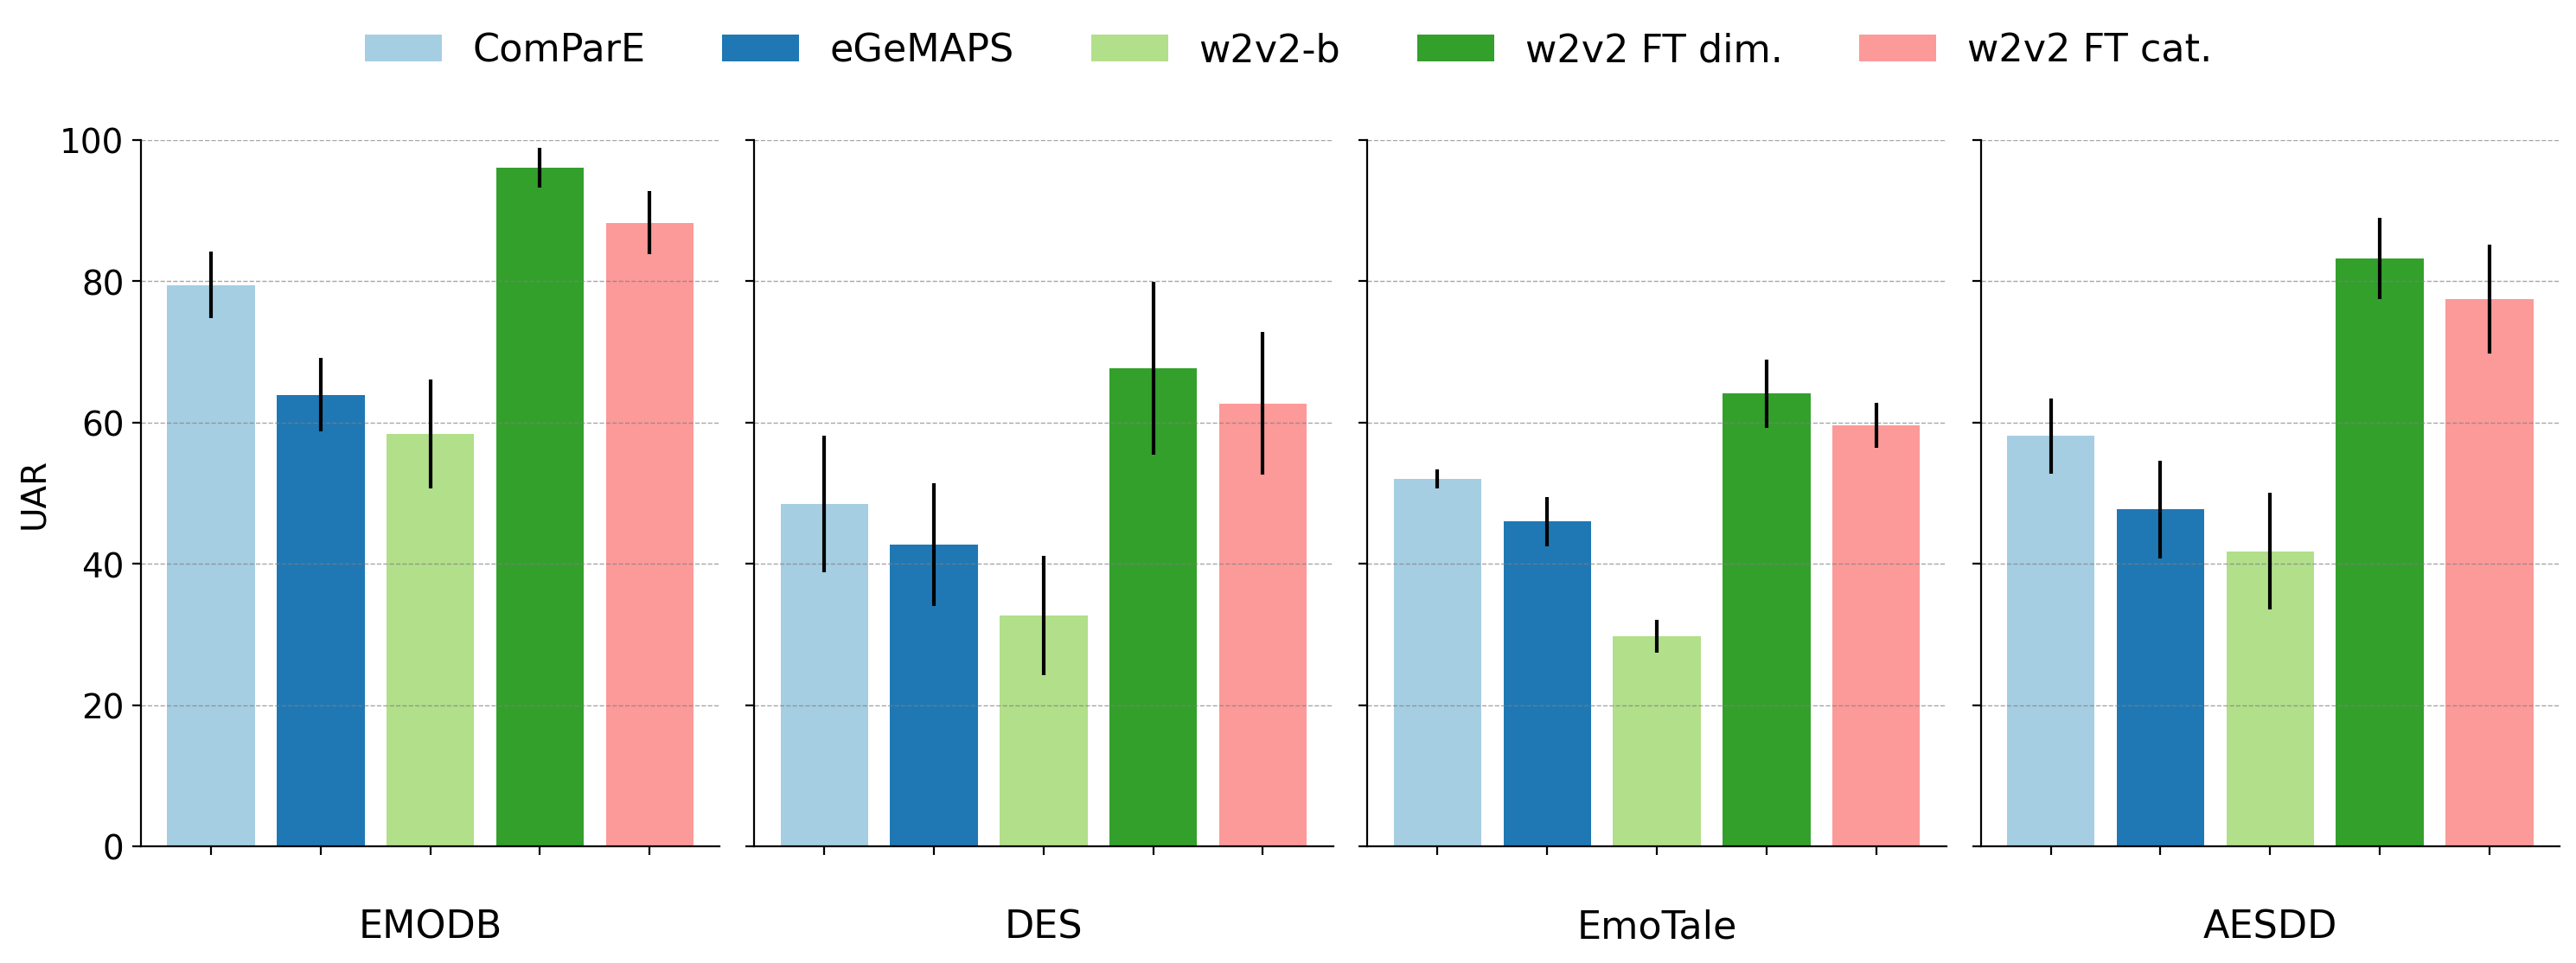

In [ ]:
# Labels for the models
models = ['ComParE', 'eGeMAPS', 'w2v2-b', 'w2v2 FT dim.', 'w2v2 FT cat.']

# Set up the matplotlib figure and axes, one subplot for each dataset
fig, axes = plt.subplots(1, 4, figsize=(15, 5), dpi = 200, sharey = True)

# Data to plot (each dataset in a separate bar plot)
datasets = [EMODB_sentence_uar, DES_sentence_uar, EmoTale_sentence_uar, AESDD_sentence_uar]
errors = [EMODB_sentence_err, DES_sentence_err, EmoTale_sentence_err, AESDD_sentence_err]
dataset_names = ['EMODB', 'DES', 'EmoTale', 'AESDD']

for ax, data, name, err in zip(axes, datasets, dataset_names, errors):
    # Create bar plot on this axis
    bars = ax.bar(models, data, yerr = err, color = plt.cm.Paired(np.linspace(0, 0.4, len(data))))
    ax.set_title(name, fontsize = 16, y=-0.15)
    ax.set_ylim(0, 100)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for i, v in enumerate(data):
      ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

axes[0].set_ylabel('UAR', fontsize = 14)
fig.legend(bars, models, frameon=False, fontsize=16, loc='upper center', ncol = 6, bbox_to_anchor=(0.5, 1.12))

plt.tight_layout()
plt.show()

#### Speaker UAR

In [ ]:
EMODB_speaker_UAR = [EMODB_ComParE_speaker_uar['UAR'].to_list(), EMODB_eGeMAPS_speaker_uar['UAR'].to_list(), EMODB_w2v2_speaker_uar['UAR'].to_list(), EMODB_w2v2_FT_dim_speaker_uar['UAR'].to_list(), EMODB_w2v2_FT_cat_speaker_uar['UAR'].to_list()]
DES_speaker_UAR = [DES_ComParE_speaker_uar['UAR'].to_list(), DES_eGeMAPS_speaker_uar['UAR'].to_list(), DES_w2v2_speaker_uar['UAR'].to_list(), DES_w2v2_FT_dim_speaker_uar['UAR'].to_list(), DES_w2v2_FT_cat_speaker_uar['UAR'].to_list()]
EmoTale_speaker_UAR = [EmoTale_v2_ComParE_speaker_uar['UAR'].to_list(), EmoTale_v2_eGeMAPS_speaker_uar['UAR'].to_list(), EmoTale_v2_w2v2_speaker_uar['UAR'].to_list(), EmoTale_v2_w2v2_FT_dim_speaker_uar['UAR'].to_list(), EmoTale_v2_w2v2_FT_cat_speaker_uar['UAR'].to_list()]
Urdu_speaker_UAR = [Urdu_ComParE_speaker_uar['UAR'].to_list(), Urdu_eGeMAPS_speaker_uar['UAR'].to_list(), Urdu_w2v2_speaker_uar['UAR'].to_list(), Urdu_w2v2_FT_dim_speaker_uar['UAR'].to_list(), Urdu_w2v2_FT_cat_speaker_uar['UAR'].to_list()]
AESDD_speaker_UAR = [AESDD_ComParE_speaker_uar['UAR'].to_list(), AESDD_eGeMAPS_speaker_uar['UAR'].to_list(), AESDD_w2v2_speaker_uar['UAR'].to_list(), AESDD_w2v2_FT_dim_speaker_uar['UAR'].to_list(), AESDD_w2v2_FT_cat_speaker_uar['UAR'].to_list()]

In [ ]:
EMODB_speaker_uar = [np.mean(uar)*100 for uar in EMODB_speaker_UAR]
DES_speaker_uar = [np.mean(uar)*100 for uar in DES_speaker_UAR]
EmoTale_speaker_uar = [np.mean(uar)*100 for uar in EmoTale_speaker_UAR]
Urdu_speaker_uar = [np.mean(uar)*100 for uar in Urdu_speaker_UAR]
AESDD_speaker_uar = [np.mean(uar)*100 for uar in AESDD_speaker_UAR]

EMODB_speaker_err = [np.std(uar)*100 for uar in EMODB_speaker_UAR]
DES_speaker_err = [np.std(uar)*100 for uar in DES_speaker_UAR]
EmoTale_speaker_err = [np.std(uar)*100 for uar in EmoTale_speaker_UAR]
Urdu_speaker_err = [np.std(uar)*100 for uar in Urdu_speaker_UAR]
AESDD_speaker_err = [np.std(uar)*100 for uar in AESDD_speaker_UAR]

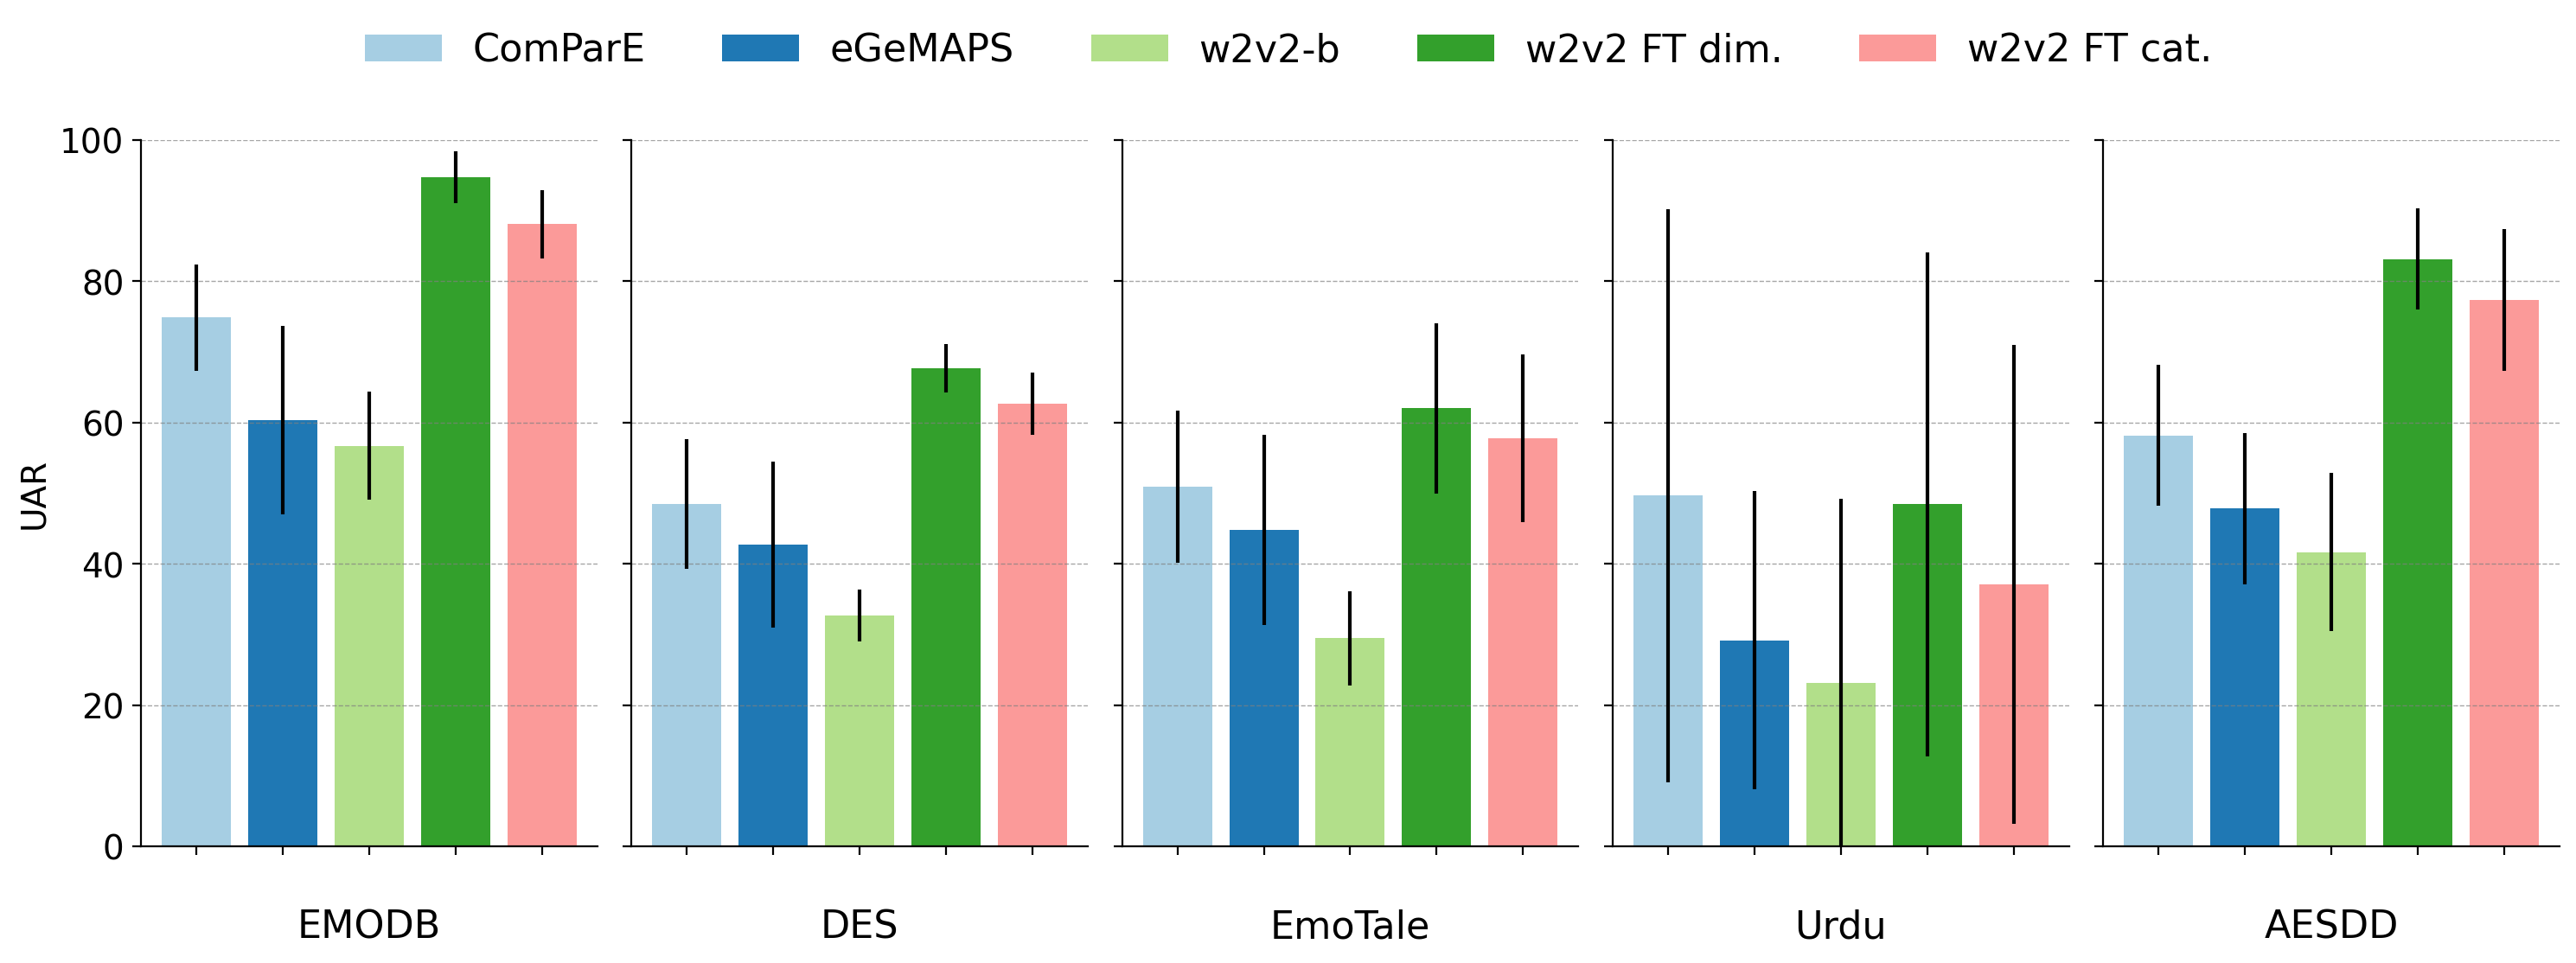

In [ ]:
models = ['ComParE', 'eGeMAPS', 'w2v2-b', 'w2v2 FT dim.', 'w2v2 FT cat.']
fig, axes = plt.subplots(1, 5, figsize=(15, 5), dpi = 200, sharey = True)

# Data to plot (each dataset in a separate bar plot)
datasets = [EMODB_speaker_uar, DES_speaker_uar, EmoTale_speaker_uar, Urdu_speaker_uar, AESDD_speaker_uar]
errors = [EMODB_speaker_err, DES_speaker_err, EmoTale_speaker_err, Urdu_speaker_err, AESDD_speaker_err]
dataset_names = ['EMODB', 'DES', 'EmoTale', 'Urdu', 'AESDD']

for ax, data, name, err in zip(axes, datasets, dataset_names, errors):
    bars = ax.bar(models, data, yerr = err, color = plt.cm.Paired(np.linspace(0, 0.4, len(data))))
    ax.set_title(name, fontsize = 16, y=-0.15)
    ax.set_ylim(0, 100)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for i, v in enumerate(data):
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

axes[0].set_ylabel('UAR', fontsize = 14)
fig.legend(bars, models, frameon=False, fontsize=16, loc='upper center', ncol = 6, bbox_to_anchor=(0.5, 1.12))

plt.tight_layout()
plt.show()

## Statistical test example

### EMODB

In [ ]:
EMODB_ComParE_model_performance = np.array(EMODB_ComParE_speaker_uar['UAR'])
EMODB_eGeMAPS_model_performance = np.array(EMODB_eGeMAPS_speaker_uar['UAR'])
EMODB_w2v2_model_performance = np.array(EMODB_w2v2_speaker_uar['UAR'])
EMODB_w2v2_FT_dim_model_performance = np.array(EMODB_w2v2_FT_dim_speaker_uar['UAR'])
EMODB_w2v2_FT_cat_model_performance = np.array(EMODB_w2v2_FT_cat_speaker_uar['UAR'])

Dependent t-test for the same test set

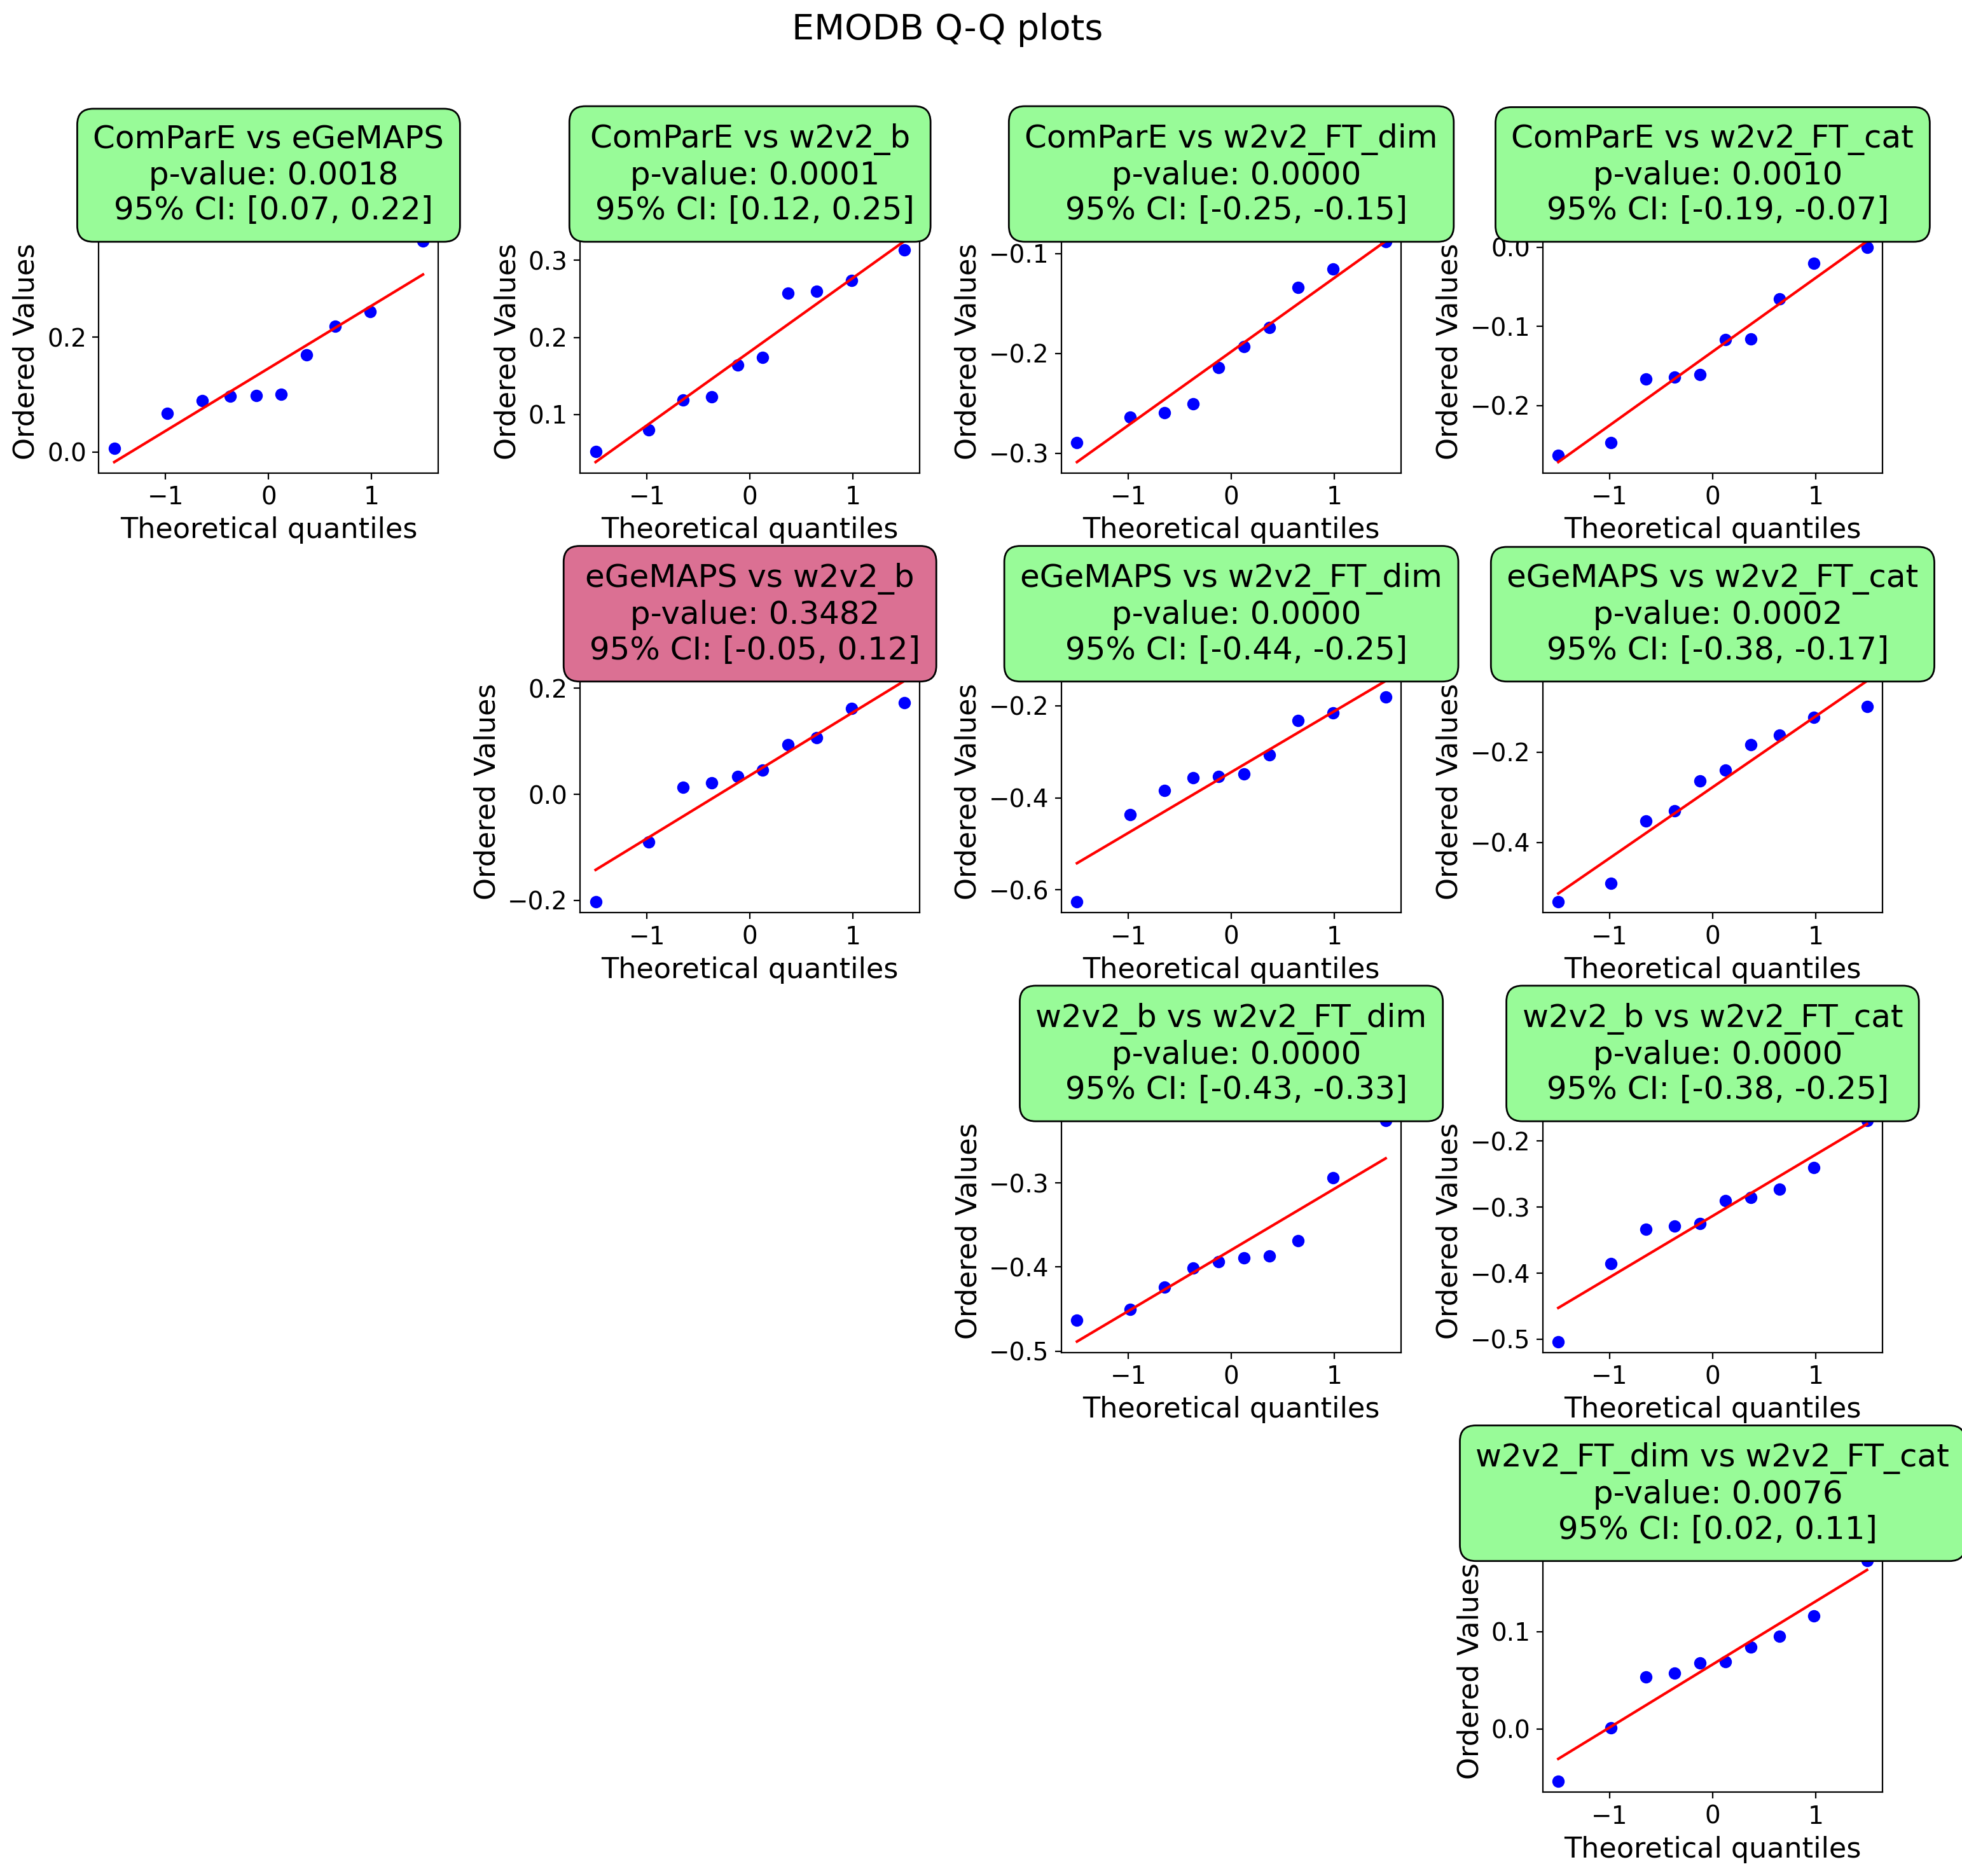

In [ ]:
model_performances = [EMODB_ComParE_model_performance, EMODB_eGeMAPS_model_performance, EMODB_w2v2_model_performance, EMODB_w2v2_FT_dim_model_performance, EMODB_w2v2_FT_cat_model_performance]
model_names = ['ComParE', 'eGeMAPS', 'w2v2_b', 'w2v2_FT_dim', 'w2v2_FT_cat']

# Perform pairwise t-tests
results = {}
plt.figure(figsize=(15, 15), dpi=200)
plt.suptitle("EMODB Q-Q plots")

for i in range(len(model_performances)):
    for j in range(i + 1, len(model_performances)):
        model1 = model_performances[i]
        model2 = model_performances[j]
        differences = model1 - model2
        name1 = model_names[i]
        name2 = model_names[j]

        mean_diff = np.mean(differences)
        sem_diff = stats.sem(differences)
        df = len(differences) - 1
        t_stat, p_value = ttest_rel(model1, model2)
        ci = stats.t.interval(0.95, df, loc=mean_diff, scale=sem_diff) #95% confidence interval
        results[f'{name1} vs {name2}'] = (t_stat, p_value)

        # Create a subplot for each pairwise comparison
        plt.subplot(len(model_performances) - 1, len(model_performances) - 1, i * (len(model_performances) - 1) + j)
        stats.probplot(differences, dist="norm", plot=plt)
        if p_value < 0.05:
          plt.title(f'{name1} vs {name2}\n p-value: {p_value:.4f}\n 95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]',bbox={'facecolor': 'palegreen', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})
        else:
          plt.title(f'{name1} vs {name2}\n p-value: {p_value:.4f}\n 95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]',bbox={'facecolor': 'palevioletred', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Transferability

### Train 4 emo models, compute dataset UAR

In [ ]:
def run_4emo_experiment(dataset, feature_set):
  feature_df = load_features(dataset, feature_set, ['anger', 'happiness', 'sadness', 'neutral'], include_info = True)
  print(f"Feature shape: {feature_df.shape}")

  if feature_set in ['ComParE', 'eGeMAPS']:
    paths = feature_df['file']
    audio_files_list = list(feature_df['file'])
  else:
    paths = feature_df['path']
    audio_files_list = list(feature_df['path'])

  emotions = feature_df['emotion']
  speakers = feature_df['speaker']
  sentences = feature_df['sentence']

  features = load_features(dataset, feature_set, ['anger', 'happiness', 'sadness', 'neutral'], include_info = False)

  results_df = experiment(features, emotions, speakers, sentences, paths, pbar = False)
  UAR = calculate_uar(results_df)

  return UAR, results_df

In [ ]:
EMODB_4emo_ComParE_UAR, EMODB_4emo_ComParE_results_df = run_4emo_experiment('EMODB', 'ComParE')
print(f"EMODB_4emo_ComParE_UAR: {EMODB_4emo_ComParE_UAR} \n")

EMODB_4emo_w2v2_FT_dim_UAR, EMODB_4emo_w2v2_FT_dim_results_df = run_4emo_experiment('EMODB', 'w2v2 FT dim')
print(f"EMODB_4emo_w2v2_FT_dim_UAR: {EMODB_4emo_w2v2_FT_dim_UAR} \n")

Feature shape: (339, 6377)
EMODB_4emo_ComParE_UAR: 0.8556255157616395 

Feature shape: (339, 1028)
EMODB_4emo_w2v2_FT_dim_UAR: 0.9819784850837308 



In [ ]:
EmoTale_v2_4emo_ComParE_UAR, EmoTale_v2_4emo_ComParE_results_df = run_4emo_experiment('EmoTale_v2', 'ComParE')
print(f"EmoTale_v2_4emo_ComParE_UAR: {EmoTale_v2_4emo_ComParE_UAR} \n")

EmoTale_v2_4emo_w2v2_FT_dim_UAR, EmoTale_v2_4emo_w2v2_FT_dim_results_df = run_4emo_experiment('EmoTale_v2', 'w2v2 FT dim')
print(f"EmoTale_v2_4emo_w2v2_FT_dim_UAR: {EmoTale_v2_4emo_w2v2_FT_dim_UAR} \n")

Feature shape: (640, 6377)
EmoTale_v2_4emo_ComParE_UAR: 0.5843750000000001 

Feature shape: (640, 1028)
EmoTale_v2_4emo_w2v2_FT_dim_UAR: 0.7265624999999999 



In [ ]:
DES_4emo_ComParE_UAR, DES_4emo_ComParE_results_df = run_4emo_experiment('DES', 'ComParE')
print(f"DES_4emo_ComParE_UAR: {DES_4emo_ComParE_UAR} \n")

DES_4emo_w2v2_FT_dim_UAR, DES_4emo_w2v2_FT_dim_results_df = run_4emo_experiment('DES', 'w2v2 FT dim')
print(f"DES_4emo_w2v2_FT_dim_UAR: {DES_4emo_w2v2_FT_dim_UAR} \n")

Feature shape: (208, 6377)
DES_4emo_ComParE_UAR: 0.5528846153846153 

Feature shape: (208, 1028)
DES_4emo_w2v2_FT_dim_UAR: 0.7355769230769231 



In [ ]:
Urdu_4emo_ComParE_UAR, Urdu_4emo_ComParE_results_df = run_4emo_experiment('Urdu', 'ComParE')
print(f"Urdu_4emo_ComParE_UAR: {Urdu_4emo_ComParE_UAR} \n")

Urdu_4emo_w2v2_FT_dim_UAR, Urdu_4emo_w2v2_FT_dim_results_df = run_4emo_experiment('Urdu', 'w2v2 FT dim')
print(f"Urdu_4emo_w2v2_FT_dim_UAR: {Urdu_4emo_w2v2_FT_dim_UAR} \n")

Feature shape: (400, 6377)
Urdu_4emo_ComParE_UAR: 0.5 

Feature shape: (400, 1028)
Urdu_4emo_w2v2_FT_dim_UAR: 0.595 



### Retrain, and save SVC model

In [ ]:
!mkdir -p /content/Models
def retrain_4emo_SVC(dataset, feature_set):
  clf = make_pipeline(
    StandardScaler(),
    OneVsOneClassifier(SVC(kernel='linear', random_state=42)))

  feature_df = load_features(dataset, feature_set, ['anger', 'happiness', 'sadness', 'neutral'], include_info = True)

  emotions = feature_df['emotion']
  features = load_features(dataset, feature_set, ['anger', 'happiness', 'sadness', 'neutral'], include_info = False)

  clf.fit(features, emotions)
  dump(clf, f'/content/Models/{dataset}_{feature_set}_4emo_model.joblib') # export model

  print(f'{dataset}_{feature_set} model saved')

In [ ]:
retrain_4emo_SVC('EMODB', 'ComParE')
retrain_4emo_SVC('EMODB', 'w2v2 FT dim')
print('\n')

retrain_4emo_SVC('EmoTale_v2', 'ComParE')
retrain_4emo_SVC('EmoTale_v2', 'w2v2 FT dim')
print('\n')

retrain_4emo_SVC('DES', 'ComParE')
retrain_4emo_SVC('DES', 'w2v2 FT dim')
print('\n')

retrain_4emo_SVC('Urdu', 'ComParE')
retrain_4emo_SVC('Urdu', 'w2v2 FT dim')

EMODB_ComParE model saved
EMODB_w2v2 FT dim model saved


EmoTale_v2_ComParE model saved
EmoTale_v2_w2v2 FT dim model saved


DES_ComParE model saved
DES_w2v2 FT dim model saved


Urdu_ComParE model saved
Urdu_w2v2 FT dim model saved


### Infer on other datasets

In [ ]:
def compute_uar(truth_col, prediction_col):
    return audmetric.unweighted_average_recall(truth_col, prediction_col)

In [ ]:
EMODB_4emo_ComParE_model = load('/content/Models/EMODB_ComParE_4emo_model.joblib')
EMODB_4emo_w2v2_FT_model = load('/content/Models/EMODB_w2v2 FT dim_4emo_model.joblib')

EmoTale_v2_4emo_ComParE_model = load('/content/Models/EmoTale_v2_ComParE_4emo_model.joblib')
EmoTale_v2_4emo_w2v2_FT_model = load('/content/Models/EmoTale_v2_w2v2 FT dim_4emo_model.joblib')

DES_4emo_ComParE_model = load('/content/Models/DES_ComParE_4emo_model.joblib')
DES_4emo_w2v2_FT_model = load('/content/Models/DES_w2v2 FT dim_4emo_model.joblib')

Urdu_4emo_ComParE_model = load('/content/Models/Urdu_ComParE_4emo_model.joblib')
Urdu_4emo_w2v2_FT_model = load('/content/Models/Urdu_w2v2 FT dim_4emo_model.joblib')

In [ ]:
EMODB_features_w2v2_FT = load_features('EMODB', 'w2v2 FT dim', ['anger', 'happiness', 'sadness', 'neutral'], False)
EMODB_features_ComParE = load_features('EMODB', 'ComParE', ['anger', 'happiness', 'sadness', 'neutral'], False)
EMODB_labels = load_features('EMODB', 'ComParE', ['anger', 'happiness', 'sadness', 'neutral'])['emotion']

EmoTale_features_w2v2_FT = load_features('EmoTale', 'w2v2 FT dim', ['anger', 'happiness', 'sadness', 'neutral'], False)
EmoTale_features_ComParE = load_features('EmoTale', 'ComParE', ['anger', 'happiness', 'sadness', 'neutral'], False)
EmoTale_labels = load_features('EmoTale', 'ComParE', ['anger', 'happiness', 'sadness', 'neutral'])['emotion']

DES_features_w2v2_FT = load_features('DES', 'w2v2 FT dim', ['anger', 'happiness', 'sadness', 'neutral'], False)
DES_features_ComParE = load_features('DES', 'ComParE', ['anger', 'happiness', 'sadness', 'neutral'], False)
DES_labels = load_features('DES', 'ComParE', ['anger', 'happiness', 'sadness', 'neutral'])['emotion']

Urdu_features_w2v2_FT = load_features('Urdu', 'w2v2 FT dim', ['anger', 'happiness', 'sadness', 'neutral'], False)
Urdu_features_ComParE = load_features('Urdu', 'ComParE', ['anger', 'happiness', 'sadness', 'neutral'], False)
Urdu_labels = load_features('Urdu', 'ComParE', ['anger', 'happiness', 'sadness', 'neutral'])['emotion']

In [ ]:
models = [EMODB_4emo_w2v2_FT_model, EmoTale_v2_4emo_w2v2_FT_model, DES_4emo_w2v2_FT_model, Urdu_4emo_w2v2_FT_model]
datasets = [EMODB_features_w2v2_FT, EmoTale_features_w2v2_FT, DES_features_w2v2_FT, Urdu_features_w2v2_FT]
true_labels = [EMODB_labels, EmoTale_labels, DES_labels, Urdu_labels]

# Initialize an array to store accuracies
accuracies_w2v2_FT = np.zeros((len(models), len(datasets)))

# Perform inference and compute accuracies
for i, model in enumerate(models):
    for j, (dataset, true_label) in enumerate(zip(datasets, true_labels)):
        predictions = model.predict(dataset)
        accuracies_w2v2_FT[i, j] = compute_uar(true_label, predictions)

np.fill_diagonal(accuracies_w2v2_FT, [EMODB_4emo_w2v2_FT_dim_UAR, EmoTale_v2_4emo_w2v2_FT_dim_UAR, DES_4emo_w2v2_FT_dim_UAR, Urdu_4emo_w2v2_FT_dim_UAR])

In [ ]:
models = [EMODB_4emo_ComParE_model, EmoTale_v2_4emo_ComParE_model, DES_4emo_ComParE_model, Urdu_4emo_ComParE_model]
datasets = [EMODB_features_ComParE, EmoTale_features_ComParE, DES_features_ComParE, Urdu_features_ComParE]
true_labels = [EMODB_labels, EmoTale_labels, DES_labels, Urdu_labels]

# Initialize an array to store accuracies
accuracies_ComParE = np.zeros((len(models), len(datasets)))

# Perform inference and compute accuracies
for i, model in enumerate(models):
    for j, (dataset, true_label) in enumerate(zip(datasets, true_labels)):
        predictions = model.predict(dataset)
        accuracies_ComParE[i, j] = compute_uar(true_label, predictions)

np.fill_diagonal(accuracies_ComParE, [EMODB_4emo_ComParE_UAR, EmoTale_v2_4emo_ComParE_UAR, DES_4emo_ComParE_UAR, Urdu_4emo_ComParE_UAR])

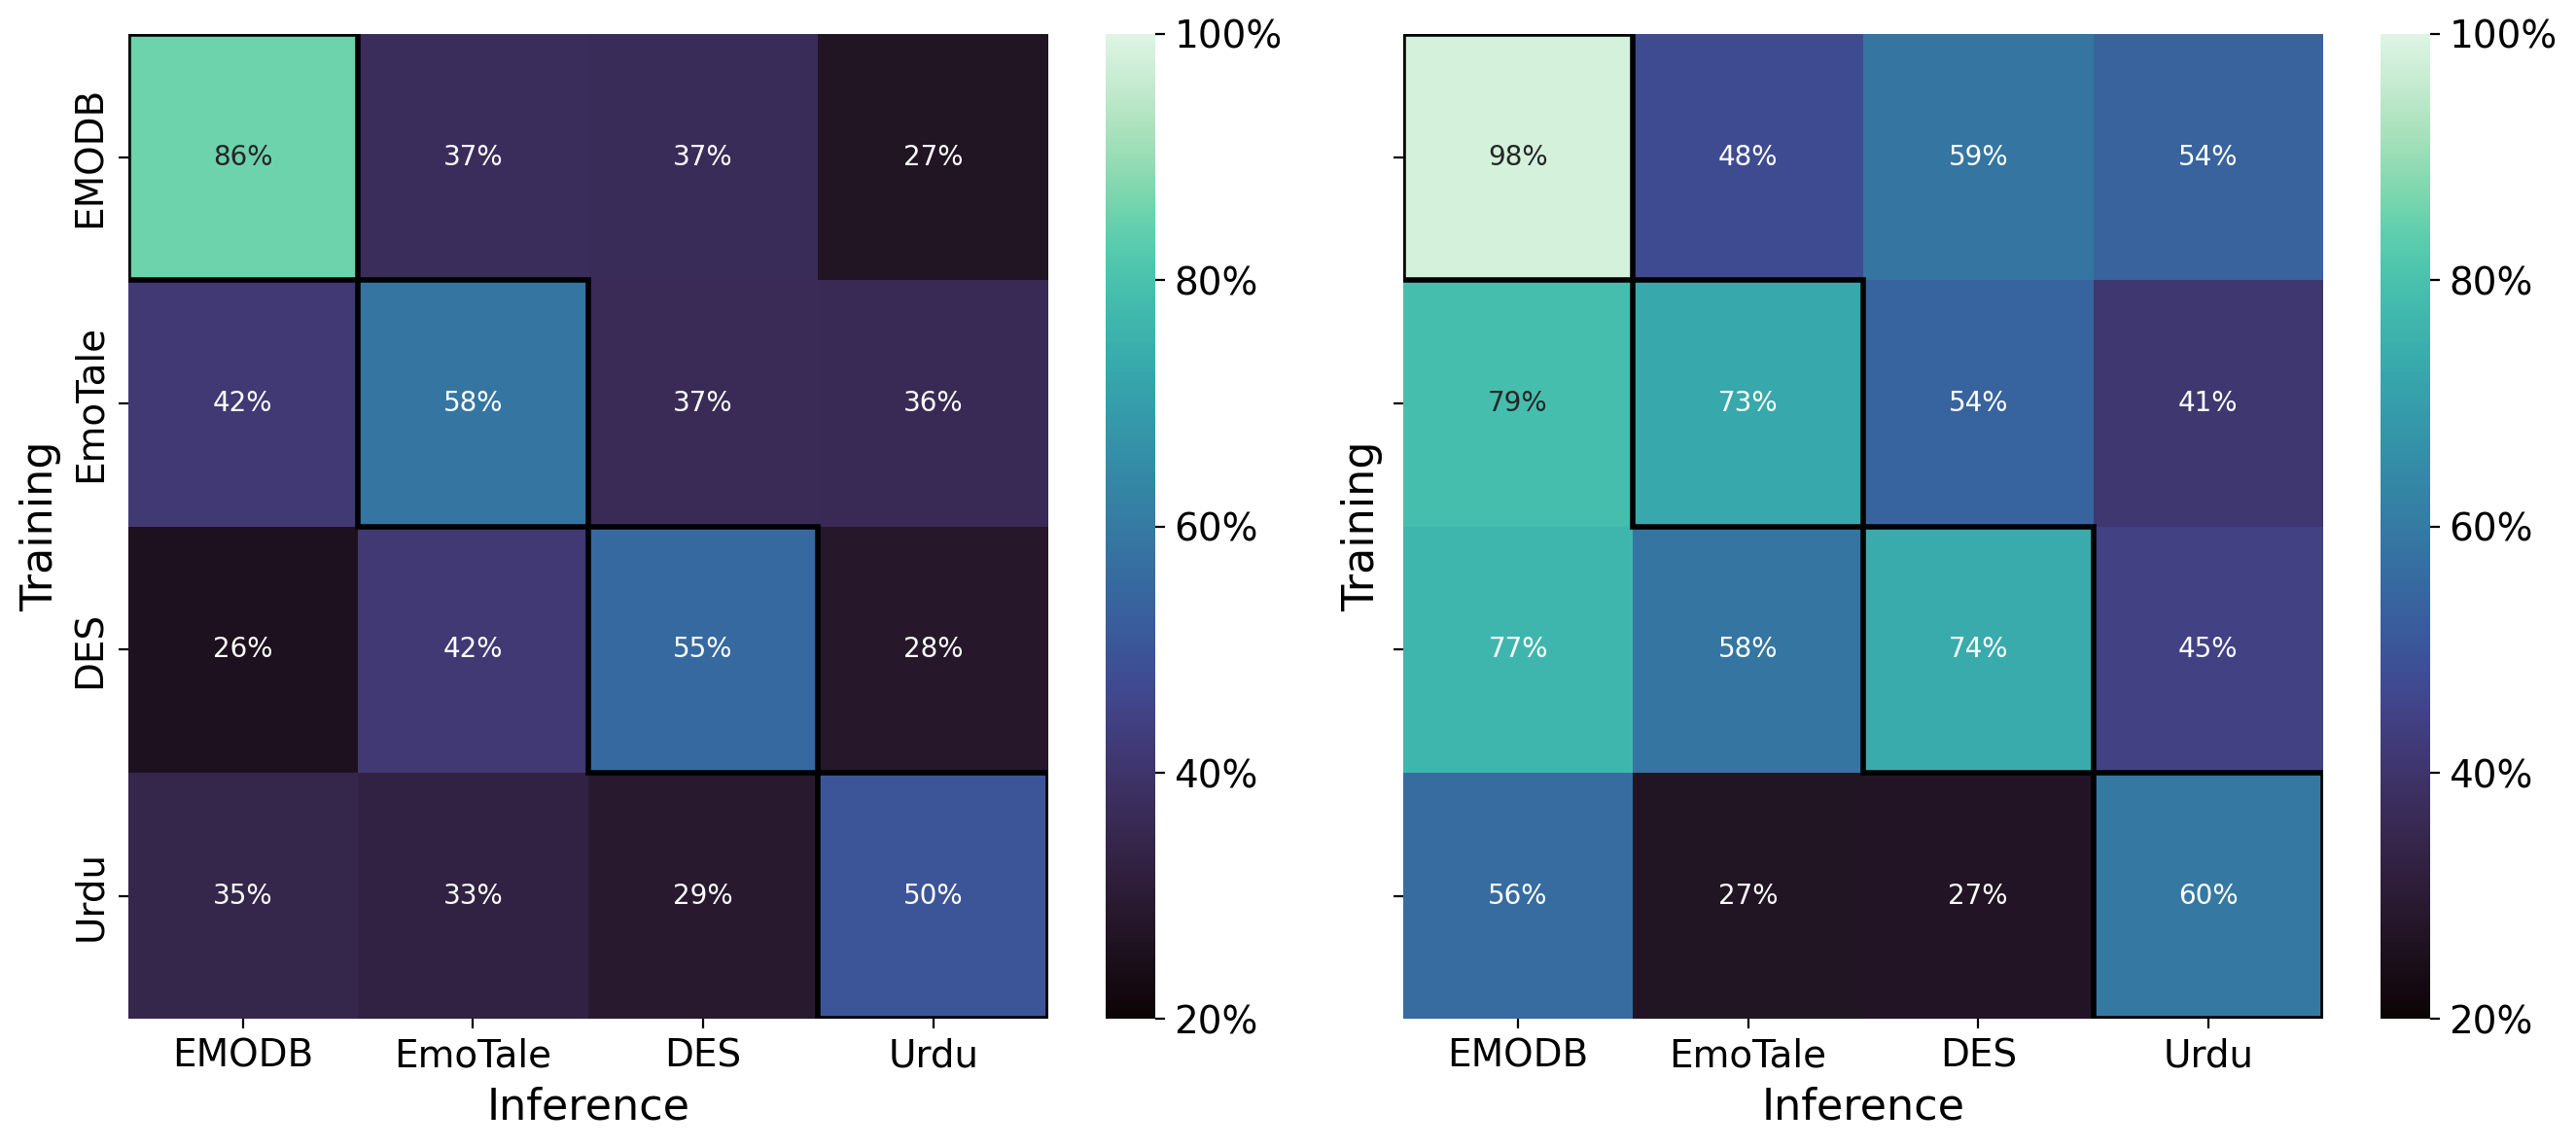

In [ ]:
vmin, vmax = 0.2, 1
names = ['EMODB', 'EmoTale', 'DES', 'Urdu']

fig, axes = plt.subplots(1, 2, figsize=(13.5, 6), dpi = 200, sharey = True, sharex = True)
heatmap1 = sns.heatmap(accuracies_ComParE,
            annot=True,
            cmap="mako",
            fmt=".0%",
            xticklabels=names,
            yticklabels=names,
            vmin=vmin,
            vmax=vmax,
            ax=axes[0])
axes[0].set_xlabel('Inference')
axes[0].set_ylabel('Training')

for i in range(len(accuracies_ComParE)):
    heatmap1.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2))

colorbar1 = heatmap1.collections[0].colorbar
colorbar1.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
colorbar1.set_ticklabels(['20%', '40%', '60%', '80%', '100%'])

heatmap2 = sns.heatmap(accuracies_w2v2_FT,
            annot=True,
            fmt=".0%",
            cmap="mako",
            xticklabels=names,
            yticklabels=names,
            vmin=vmin,
            vmax=vmax,
            ax=axes[1])
axes[1].set_xlabel('Inference')
axes[1].set_ylabel('Training')

for i in range(len(accuracies_w2v2_FT)):
    heatmap2.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2))

colorbar2 = heatmap2.collections[0].colorbar
colorbar2.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
colorbar2.set_ticklabels(['20%', '40%', '60%', '80%', '100%'])

plt.tight_layout()
plt.show()

# RQ2

## LIME

In [ ]:
url = 'https://drive.google.com/file/d/17Z4yUOWCp30S5XciN3OPutvEzN-Xg2bN/view?usp=sharing'
output = 'LIME.zip'
gdown.download(url, output, quiet=False, fuzzy=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

Downloading...
From: https://drive.google.com/uc?id=17Z4yUOWCp30S5XciN3OPutvEzN-Xg2bN
To: /content/LIME.zip
100%|██████████| 256k/256k [00:00<00:00, 77.5MB/s]


In [ ]:
def normalize(weights):
  """
  normalizes an array of weights to be in a certain range to obtain better transparency values for the images
  :param weights: array of weights to be normalized
  :return: array of normalized weights
  """
  abs_weights = np.abs(np.array(weights))
  minimum = min(abs_weights) - 0.2 * max(abs_weights)
  maximum = max(abs_weights) + 0.4 * max(abs_weights)
  normalized = np.zeros(np.shape(abs_weights))
  for i, _ in enumerate(abs_weights):
      normalized[i] = (abs_weights[i] - minimum) / (maximum - minimum)  # zi = (xi – min(x)) / (max(x) – min(x))
  return normalized

In [ ]:
# Function to calculate mean and standard error
def mean_and_sem(df):
    means = df.mean()
    sems = df.sem()
    return means, sems

In [ ]:
freq_columns = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8']

In [ ]:
angry_spectral_weights = pd.read_csv('/content/EmoLIME/angry_spectral_weights.csv', header = None)
angry_spectral_weights.columns = freq_columns

happy_spectral_weights = pd.read_csv('/content/EmoLIME/happy_spectral_weights.csv', header = None)
happy_spectral_weights.columns = freq_columns

sad_spectral_weights = pd.read_csv('/content/EmoLIME/sad_spectral_weights.csv', header = None)
sad_spectral_weights.columns = freq_columns

neutral_spectral_weights = pd.read_csv('/content//EmoLIME/neutral_spectral_weights.csv', header = None)
neutral_spectral_weights.columns = freq_columns

In [ ]:
ComParE_angry_spectral_weights = pd.read_csv('/content/EmoLIME/ComParE_angry_spectral_weights.csv', header = None)
ComParE_angry_spectral_weights.columns = freq_columns

ComParE_happy_spectral_weights = pd.read_csv('/content/EmoLIME/ComParE_happy_spectral_weights.csv', header = None)
ComParE_happy_spectral_weights.columns = freq_columns

ComParE_sad_spectral_weights = pd.read_csv('/content/EmoLIME/ComParE_sad_spectral_weights.csv', header = None)
ComParE_sad_spectral_weights.columns = freq_columns

ComParE_neutral_spectral_weights = pd.read_csv('/content/EmoLIME/ComParE_neutral_spectral_weights.csv', header = None)
ComParE_neutral_spectral_weights.columns = freq_columns

In [ ]:
angry_spectral_weights_normalized = angry_spectral_weights.apply(normalize, axis=1)
angry_spectral_weights_normalized = pd.DataFrame(angry_spectral_weights_normalized.tolist(), columns=angry_spectral_weights.columns)
sad_spectral_weights_normalized = sad_spectral_weights.apply(normalize, axis=1)
sad_spectral_weights_normalized = pd.DataFrame(sad_spectral_weights_normalized.tolist(), columns=sad_spectral_weights.columns)
happy_spectral_weights_normalized = happy_spectral_weights.apply(normalize, axis=1)
happy_spectral_weights_normalized = pd.DataFrame(happy_spectral_weights_normalized.tolist(), columns=happy_spectral_weights.columns)
neutral_spectral_weights_normalized = neutral_spectral_weights.apply(normalize, axis=1)
neutral_spectral_weights_normalized = pd.DataFrame(neutral_spectral_weights_normalized.tolist(), columns=neutral_spectral_weights.columns)

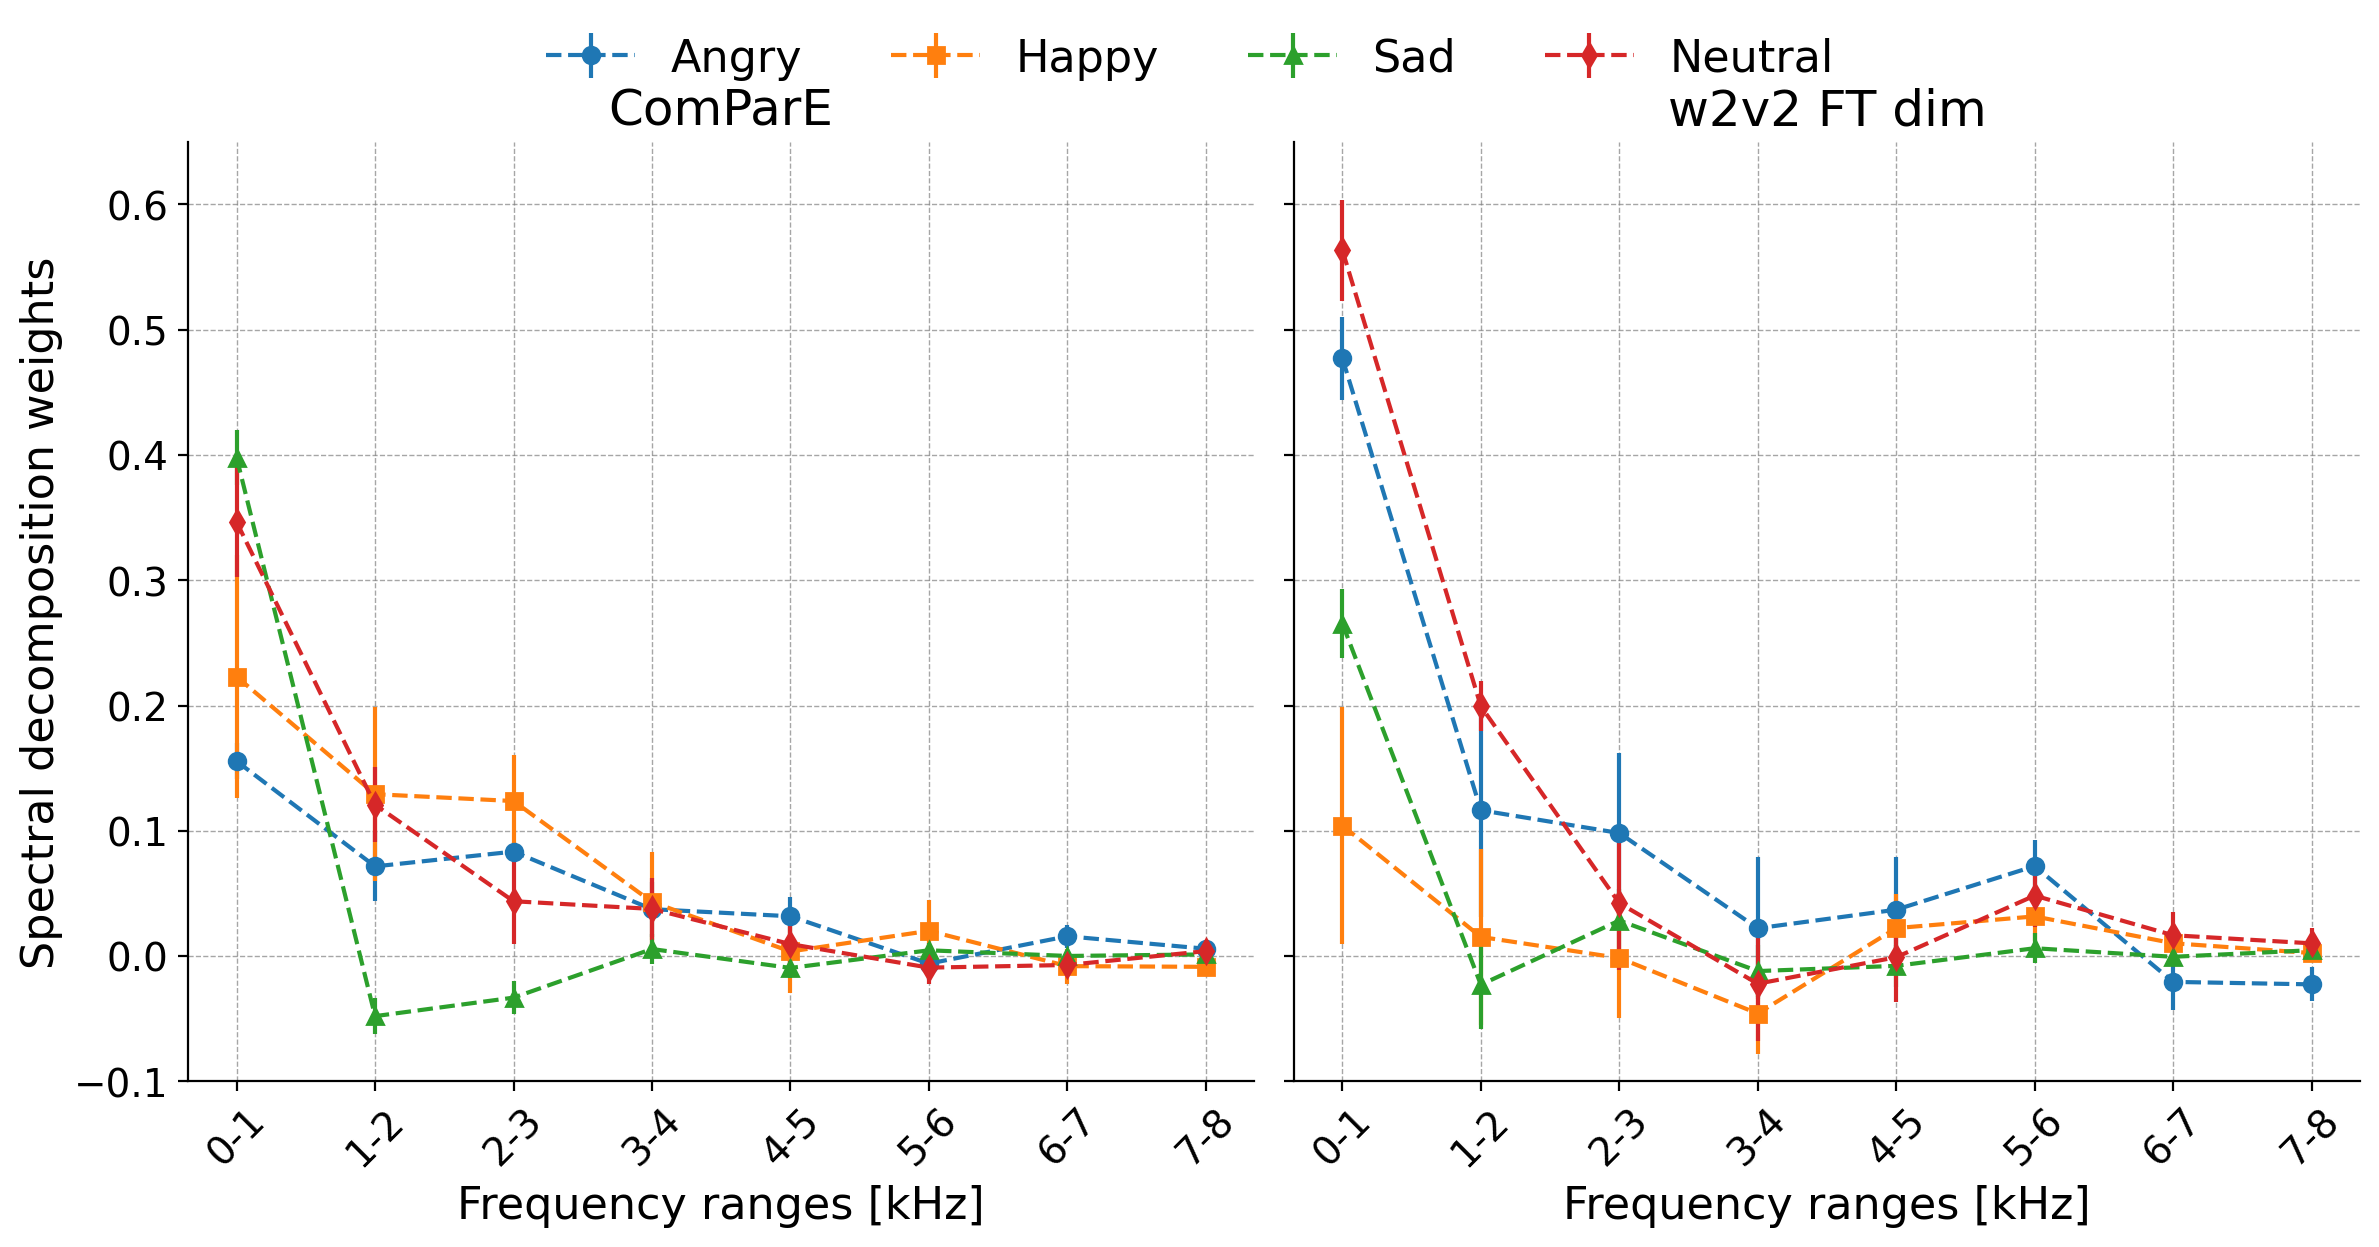

In [ ]:
# Calculate means and standard errors for each DataFrame
ComParE_means1, ComParE_sems1 = mean_and_sem(ComParE_angry_spectral_weights)
ComParE_means2, ComParE_sems2 = mean_and_sem(ComParE_happy_spectral_weights)
ComParE_means3, ComParE_sems3 = mean_and_sem(ComParE_sad_spectral_weights)
ComParE_means4, ComParE_sems4 = mean_and_sem(ComParE_neutral_spectral_weights)

means1, sems1 = mean_and_sem(angry_spectral_weights)
means2, sems2 = mean_and_sem(happy_spectral_weights)
means3, sems3 = mean_and_sem(sad_spectral_weights)
means4, sems4 = mean_and_sem(neutral_spectral_weights)

x = np.arange(len(means1))
x1 = np.arange(len(means1))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi = 200, sharex = True, sharey = True)

axs[0].errorbar(x1, ComParE_means1, yerr=ComParE_sems1, fmt='--o', label='Angry')
axs[0].errorbar(x1, ComParE_means2, yerr=ComParE_sems2, fmt='--s', label='Happy')
axs[0].errorbar(x1, ComParE_means3, yerr=ComParE_sems3, fmt='--^', label='Sad')
axs[0].errorbar(x1, ComParE_means4, yerr=ComParE_sems4, fmt='--d', label='Neutral')

# Adding labels and title
axs[0].set_xlabel('Frequency ranges [kHz]')
axs[0].set_ylabel('Spectral decomposition weights')
axs[0].set_ylim([-0.1, 0.65])
axs[0].set_title('ComParE')
axs[0].set_xticks(ticks=x1)
axs[0].set_xticklabels(labels = [value[:5] for value in ComParE_angry_spectral_weights.columns], rotation=45)
axs[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

axs[1].errorbar(x, means1, yerr=sems1, fmt='--o', label='Angry')
axs[1].errorbar(x, means2, yerr=sems2, fmt='--s', label='Happy')
axs[1].errorbar(x, means3, yerr=sems3, fmt='--^', label='Sad')
axs[1].errorbar(x, means4, yerr=sems4, fmt='--d', label='Neutral')

axs[1].set_xlabel('Frequency ranges [kHz]')
# axs[1].set_ylabel('Weights')
axs[1].set_ylim([-0.1, 0.65])
axs[1].set_title('w2v2 FT dim')
axs[1].set_xticks(ticks=x)
axs[1].set_xticklabels(labels = [value[:5] for value in angry_spectral_weights.columns], rotation=45)
axs[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# plt.legend(frameon=False, fontsize=12, loc='upper center', ncol = 5,  bbox_to_anchor=(2, 1.2))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol = 5, frameon=False, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

# RQ3

In [ ]:
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.titlesize': 20
})

In [ ]:
def check_datasplits(train_df, val_df, test_df):
  common_elements = train_df['filename'].isin(test_df['filename']).any()
  if common_elements:
      print("Common elements found in train and test!!!!!")
      print(train_df['filename'].isin(test_df['filename']))

  common_elements = train_df['filename'].isin(val_df['filename']).any()
  if common_elements:
      print("Common elements found in train and val!!!!!")
      print(train_df['filename'].isin(val_df['filename']))

  common_elements = val_df['filename'].isin(test_df['filename']).any()
  if common_elements:
      print("Common elements found in val and test!!!!!")
      print(val_df['filename'].isin(test_df['filename']))

In [ ]:
url = 'https://drive.google.com/file/d/1xyv4pAwwb2P4in2FbKe9oDft6lmsjS8U/view?usp=sharing'
output = 'Ntrain_experiment.zip'
gdown.download(url, output, quiet=False, fuzzy=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

Downloading...
From: https://drive.google.com/uc?id=1xyv4pAwwb2P4in2FbKe9oDft6lmsjS8U
To: /content/Ntrain_experiment.zip
100%|██████████| 2.83M/2.83M [00:00<00:00, 178MB/s]


In [ ]:
ntrain_results_path = '/content/Ntrain_experiment/'

## Fine-tuned

In [ ]:
FT_results = [[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
ntrain = [360, 330, 300, 270, 240, 210, 180, 150, 120, 90, 60, 30, 25, 20]#, 15, 10, 5]

for i in range(5):
  for n in range(14):
    Ntrain = ntrain[n]
    train_predictions = list(np.load(ntrain_results_path + f'predictions/Ntrain_{Ntrain}_Kfold_{i}_train_predictions.npy', allow_pickle=True))
    val_predictions = list(np.load(ntrain_results_path + f'predictions/Ntrain_{Ntrain}_Kfold_{i}_val_predictions.npy', allow_pickle=True))
    test_predictions = list(np.load(ntrain_results_path + f'predictions/Ntrain_{Ntrain}_Kfold_{i}_test_predictions.npy', allow_pickle=True))

    train_uar, train_macro_f1 = compute_metrics(train_predictions[0]['label_ids'], train_predictions[0]['predictions'])
    val_uar, val_macro_f1 = compute_metrics(val_predictions[0]['label_ids'], val_predictions[0]['predictions'])
    test_uar, test_macro_f1 = compute_metrics(test_predictions[0]['label_ids'], test_predictions[0]['predictions'])

    FT_results[n].append({'train_uar': train_uar, 'train_macro_f1': train_macro_f1, 'val_uar': val_uar, 'val_macro_f1': val_macro_f1, 'test_uar': test_uar, 'test_macro_f1': test_macro_f1})

In [ ]:
FT_results_360_df = pd.DataFrame(FT_results[0])
FT_results_330_df = pd.DataFrame(FT_results[1])
FT_results_300_df = pd.DataFrame(FT_results[2])
FT_results_270_df = pd.DataFrame(FT_results[3])
FT_results_240_df = pd.DataFrame(FT_results[4])
FT_results_210_df = pd.DataFrame(FT_results[5])
FT_results_180_df = pd.DataFrame(FT_results[6])
FT_results_150_df = pd.DataFrame(FT_results[7])
FT_results_120_df = pd.DataFrame(FT_results[8])
FT_results_90_df = pd.DataFrame(FT_results[9])
FT_results_60_df = pd.DataFrame(FT_results[10])
FT_results_30_df = pd.DataFrame(FT_results[11])
FT_results_25_df = pd.DataFrame(FT_results[12])
FT_results_20_df = pd.DataFrame(FT_results[13])

In [ ]:
Finetuned_results_330_df = FT_results_330_df

In [ ]:
FT_predictions = []
ntrain = [360, 330, 300, 270, 240, 210, 180, 150, 120, 90, 60, 30, 25, 20]

for n in range(14):
  Ntrain = ntrain[n]
  train_pred, val_pred, test_pred = [], [], []
  train_true, val_true, test_true = [], [], []

  for i in range(5):
    train_predictions = list(np.load(ntrain_results_path + f'predictions/Ntrain_{Ntrain}_Kfold_{i}_train_predictions.npy', allow_pickle=True))
    val_predictions = list(np.load(ntrain_results_path + f'predictions/Ntrain_{Ntrain}_Kfold_{i}_val_predictions.npy', allow_pickle=True))
    test_predictions = list(np.load(ntrain_results_path + f'predictions/Ntrain_{Ntrain}_Kfold_{i}_test_predictions.npy', allow_pickle=True))

    train_pred += train_predictions[0]['predictions'].tolist()
    train_true += train_predictions[0]['label_ids'].tolist()
    val_pred += val_predictions[0]['predictions'].tolist()
    val_true += val_predictions[0]['label_ids'].tolist()
    test_pred += test_predictions[0]['predictions'].tolist()
    test_true += test_predictions[0]['label_ids'].tolist()

  FT_predictions.append({'train_pred': train_pred, 'train_true': train_true, 'val_pred': val_pred, 'val_true': val_true, 'test_pred': test_pred, 'test_true': test_true})

In [ ]:
FT_predictions_360 = FT_predictions[0]
FT_predictions_330 = FT_predictions[1]
FT_predictions_300 = FT_predictions[2]
FT_predictions_270 = FT_predictions[3]
FT_predictions_240 = FT_predictions[4]
FT_predictions_210 = FT_predictions[5]
FT_predictions_180 = FT_predictions[6]
FT_predictions_150 = FT_predictions[7]
FT_predictions_120 = FT_predictions[8]
FT_predictions_90 = FT_predictions[9]
FT_predictions_60 = FT_predictions[10]
FT_predictions_30 = FT_predictions[11]
FT_predictions_25 = FT_predictions[12]
FT_predictions_20 = FT_predictions[13]

In [ ]:
predictions = [FT_predictions_360, FT_predictions_330, FT_predictions_300, FT_predictions_270, FT_predictions_240, FT_predictions_210, FT_predictions_180, FT_predictions_150, FT_predictions_120, FT_predictions_90, FT_predictions_60, FT_predictions_30, FT_predictions_25, FT_predictions_20]

results = [FT_results_360_df, FT_results_330_df, FT_results_300_df, FT_results_270_df, FT_results_240_df, FT_results_210_df, FT_results_180_df, FT_results_150_df, FT_results_120_df, FT_results_90_df, FT_results_60_df, FT_results_30_df, FT_results_25_df, FT_results_20_df]

In [ ]:
data = []
splits = [20, 25, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
for split, result, preds in zip(splits, results[::-1], predictions[::-1]):
  val_uar, val_f1 = compute_metrics(preds['val_true'], preds['val_pred'])
  test_uar, test_f1 = compute_metrics(preds['test_true'], preds['test_pred'])
  data.append({
      'split': split,
      'uar_val': (round(val_uar, 2), round(result['val_uar'].std(), 2)),
      'f1_macro_val': (round(val_f1, 2), round(result['val_macro_f1'].std(), 2)),
      'uar_test': (round(test_uar, 2), round(result['test_uar'].std(), 2)),
      'f1_macro_test': (round(test_f1, 2), round(result['test_macro_f1'].std(), 2)),
  })

results_df = pd.DataFrame(data)

In [ ]:
results_df

split       uar_val  f1_macro_val      uar_test f1_macro_test
0      20  (0.24, 0.05)  (0.19, 0.05)  (0.21, 0.03)  (0.17, 0.04)
1      25   (0.2, 0.01)  (0.09, 0.03)  (0.19, 0.02)   (0.07, 0.0)
2      30  (0.32, 0.06)  (0.28, 0.04)   (0.3, 0.12)  (0.28, 0.11)
3      60  (0.38, 0.14)  (0.36, 0.17)  (0.35, 0.11)  (0.33, 0.12)
4      90  (0.46, 0.13)   (0.4, 0.16)  (0.45, 0.13)  (0.41, 0.16)
5     120   (0.43, 0.1)   (0.4, 0.12)  (0.39, 0.11)   (0.37, 0.1)
6     150  (0.46, 0.09)  (0.46, 0.11)  (0.45, 0.09)   (0.45, 0.1)
7     180  (0.56, 0.07)  (0.53, 0.09)  (0.48, 0.06)  (0.45, 0.06)
8     210  (0.63, 0.07)  (0.62, 0.08)  (0.51, 0.05)  (0.49, 0.05)
9     240   (0.6, 0.04)  (0.56, 0.04)  (0.53, 0.06)   (0.5, 0.06)
10    270  (0.64, 0.03)  (0.63, 0.04)  (0.55, 0.09)  (0.54, 0.11)
11    300  (0.62, 0.04)  (0.58, 0.04)  (0.57, 0.06)  (0.54, 0.06)
12    330  (0.61, 0.08)  (0.61, 0.09)   (0.6, 0.12)  (0.59, 0.13)
13    360  (0.64, 0.07)  (0.62, 0.07)  (0.57, 0.03)  (0.55, 0.02)

In [ ]:
val_uar_means = [FT_results_20_df['val_uar'].mean(), FT_results_25_df['val_uar'].mean(), FT_results_30_df['val_uar'].mean(), FT_results_60_df['val_uar'].mean(), FT_results_90_df['val_uar'].mean(), FT_results_120_df['val_uar'].mean(), FT_results_150_df['val_uar'].mean(), FT_results_180_df['val_uar'].mean(), FT_results_210_df['val_uar'].mean(), FT_results_240_df['val_uar'].mean(), FT_results_270_df['val_uar'].mean(), FT_results_300_df['val_uar'].mean(), FT_results_330_df['val_uar'].mean(), FT_results_360_df['val_uar'].mean()]
val_uar_stds = [FT_results_20_df['val_uar'].std(), FT_results_25_df['val_uar'].std(), FT_results_30_df['val_uar'].std(), FT_results_60_df['val_uar'].std(), FT_results_90_df['val_uar'].std(), FT_results_120_df['val_uar'].std(), FT_results_150_df['val_uar'].std(), FT_results_180_df['val_uar'].std(), FT_results_210_df['val_uar'].std(), FT_results_240_df['val_uar'].std(), FT_results_270_df['val_uar'].std(), FT_results_300_df['val_uar'].std(), FT_results_330_df['val_uar'].std(), FT_results_360_df['val_uar'].std()]
val_macro_f1_means = [FT_results_20_df['val_macro_f1'].mean(), FT_results_25_df['val_macro_f1'].mean(), FT_results_30_df['val_macro_f1'].mean(), FT_results_60_df['val_macro_f1'].mean(), FT_results_90_df['val_macro_f1'].mean(), FT_results_120_df['val_macro_f1'].mean(), FT_results_150_df['val_macro_f1'].mean(), FT_results_180_df['val_macro_f1'].mean(), FT_results_210_df['val_macro_f1'].mean(), FT_results_240_df['val_macro_f1'].mean(), FT_results_270_df['val_macro_f1'].mean(), FT_results_300_df['val_macro_f1'].mean(), FT_results_330_df['val_macro_f1'].mean(), FT_results_360_df['val_macro_f1'].mean()]
val_macro_f1_stds = [FT_results_20_df['val_macro_f1'].std(), FT_results_25_df['val_macro_f1'].std(), FT_results_30_df['val_macro_f1'].std(), FT_results_60_df['val_macro_f1'].std(), FT_results_90_df['val_macro_f1'].std(), FT_results_120_df['val_macro_f1'].std(), FT_results_150_df['val_macro_f1'].std(), FT_results_180_df['val_macro_f1'].std(), FT_results_210_df['val_macro_f1'].std(), FT_results_240_df['val_macro_f1'].std(), FT_results_270_df['val_macro_f1'].std(), FT_results_300_df['val_macro_f1'].std(), FT_results_330_df['val_macro_f1'].std(), FT_results_360_df['val_macro_f1'].std()]

test_uar_means = [FT_results_20_df['test_uar'].mean(), FT_results_25_df['test_uar'].mean(), FT_results_30_df['test_uar'].mean(), FT_results_60_df['test_uar'].mean(), FT_results_90_df['test_uar'].mean(), FT_results_120_df['test_uar'].mean(), FT_results_150_df['test_uar'].mean(), FT_results_180_df['test_uar'].mean(), FT_results_210_df['test_uar'].mean(), FT_results_240_df['test_uar'].mean(), FT_results_270_df['test_uar'].mean(), FT_results_300_df['test_uar'].mean(), FT_results_330_df['test_uar'].mean(), FT_results_360_df['test_uar'].mean()]
test_uar_stds = [FT_results_20_df['test_uar'].std(), FT_results_25_df['test_uar'].std(), FT_results_30_df['test_uar'].std(), FT_results_60_df['test_uar'].std(), FT_results_90_df['test_uar'].std(), FT_results_120_df['test_uar'].std(), FT_results_150_df['test_uar'].std(), FT_results_180_df['test_uar'].std(), FT_results_210_df['test_uar'].std(), FT_results_240_df['test_uar'].std(), FT_results_270_df['test_uar'].std(), FT_results_300_df['test_uar'].std(), FT_results_330_df['test_uar'].std(), FT_results_360_df['test_uar'].std()]
test_macro_f1_means = [FT_results_20_df['test_macro_f1'].mean(), FT_results_25_df['test_macro_f1'].mean(), FT_results_30_df['test_macro_f1'].mean(), FT_results_60_df['test_macro_f1'].mean(), FT_results_90_df['test_macro_f1'].mean(), FT_results_120_df['test_macro_f1'].mean(), FT_results_150_df['test_macro_f1'].mean(), FT_results_180_df['test_macro_f1'].mean(), FT_results_210_df['test_macro_f1'].mean(), FT_results_240_df['test_macro_f1'].mean(), FT_results_270_df['test_macro_f1'].mean(), FT_results_300_df['test_macro_f1'].mean(), FT_results_330_df['test_macro_f1'].mean(), FT_results_360_df['test_macro_f1'].mean()]
test_macro_f1_stds = [FT_results_20_df['test_macro_f1'].std(), FT_results_25_df['test_macro_f1'].std(), FT_results_30_df['test_macro_f1'].std(), FT_results_60_df['test_macro_f1'].std(), FT_results_90_df['test_macro_f1'].std(), FT_results_120_df['test_macro_f1'].std(), FT_results_150_df['test_macro_f1'].std(), FT_results_180_df['test_macro_f1'].std(), FT_results_210_df['test_macro_f1'].std(), FT_results_240_df['test_macro_f1'].std(), FT_results_270_df['test_macro_f1'].std(), FT_results_300_df['test_macro_f1'].std(), FT_results_330_df['test_macro_f1'].std(), FT_results_360_df['test_macro_f1'].std()]

train_uar_means = [FT_results_20_df['train_uar'].mean(), FT_results_25_df['train_uar'].mean(), FT_results_30_df['train_uar'].mean(), FT_results_60_df['train_uar'].mean(), FT_results_90_df['train_uar'].mean(), FT_results_120_df['train_uar'].mean(), FT_results_150_df['train_uar'].mean(), FT_results_180_df['train_uar'].mean(), FT_results_210_df['train_uar'].mean(), FT_results_240_df['train_uar'].mean(), FT_results_270_df['train_uar'].mean(), FT_results_300_df['train_uar'].mean(), FT_results_330_df['train_uar'].mean(), FT_results_360_df['train_uar'].mean()]
train_uar_stds = [FT_results_20_df['train_uar'].std(), FT_results_25_df['train_uar'].std(), FT_results_30_df['train_uar'].std(), FT_results_60_df['train_uar'].std(), FT_results_90_df['train_uar'].std(), FT_results_120_df['train_uar'].std(), FT_results_150_df['train_uar'].std(), FT_results_180_df['train_uar'].std(), FT_results_210_df['train_uar'].std(), FT_results_240_df['train_uar'].std(), FT_results_270_df['train_uar'].std(), FT_results_300_df['train_uar'].std(), FT_results_330_df['train_uar'].std(), FT_results_360_df['train_uar'].std()]
train_macro_f1_means = [FT_results_20_df['train_macro_f1'].mean(), FT_results_25_df['train_macro_f1'].mean(), FT_results_30_df['train_macro_f1'].mean(), FT_results_60_df['train_macro_f1'].mean(), FT_results_90_df['train_macro_f1'].mean(), FT_results_120_df['train_macro_f1'].mean(), FT_results_150_df['train_macro_f1'].mean(), FT_results_180_df['train_macro_f1'].mean(), FT_results_210_df['train_macro_f1'].mean(), FT_results_240_df['train_macro_f1'].mean(), FT_results_270_df['train_macro_f1'].mean(), FT_results_300_df['train_macro_f1'].mean(), FT_results_330_df['train_macro_f1'].mean(), FT_results_360_df['train_macro_f1'].mean()]
train_macro_f1_stds = [FT_results_20_df['train_macro_f1'].std(), FT_results_25_df['train_macro_f1'].std(), FT_results_30_df['train_macro_f1'].std(), FT_results_60_df['train_macro_f1'].std(), FT_results_90_df['train_macro_f1'].std(), FT_results_120_df['train_macro_f1'].std(), FT_results_150_df['train_macro_f1'].std(), FT_results_180_df['train_macro_f1'].std(), FT_results_210_df['train_macro_f1'].std(), FT_results_240_df['train_macro_f1'].std(), FT_results_270_df['train_macro_f1'].std(), FT_results_300_df['train_macro_f1'].std(), FT_results_330_df['train_macro_f1'].std(), FT_results_360_df['train_macro_f1'].std()]


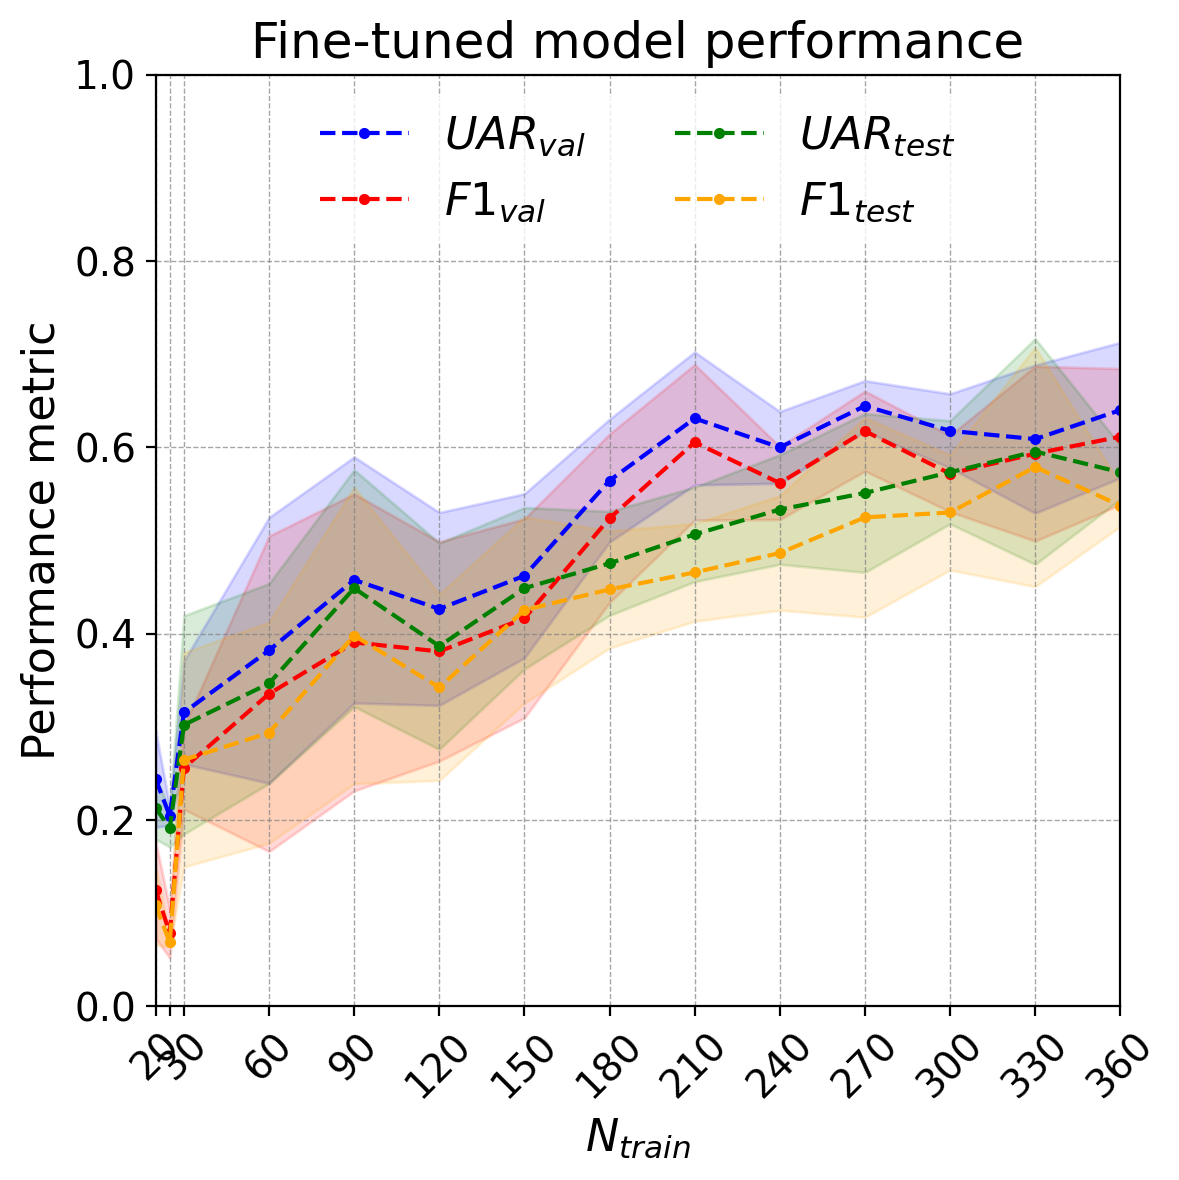

In [ ]:
plt.figure(figsize=(6, 6), dpi = 200)

plt.plot(splits, val_uar_means, 'b--.', label = '$UAR_{val}$')
plt.fill_between(splits, np.array(val_uar_means) - np.array(val_uar_stds), np.array(val_uar_means) + np.array(val_uar_stds), color='b', alpha=0.15)

plt.plot(splits, val_macro_f1_means, 'r--.', label = '$F1_{val}$')
plt.fill_between(splits, np.array(val_macro_f1_means) - np.array(val_macro_f1_stds), np.array(val_macro_f1_means) + np.array(val_macro_f1_stds), color='r', alpha=0.15)

plt.plot(splits, test_uar_means, 'g--.', label = '$UAR_{test}$')
plt.fill_between(splits, np.array(test_uar_means) - np.array(test_uar_stds), np.array(test_uar_means) + np.array(test_uar_stds), color='g', alpha=0.15)

plt.plot(splits, test_macro_f1_means, '--.', color = 'orange', label = '$F1_{test}$')
plt.fill_between(splits, np.array(test_macro_f1_means) - np.array(test_macro_f1_stds), np.array(test_macro_f1_means) + np.array(test_macro_f1_stds), color='orange', alpha=0.15)

plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

plt.ylim([0,1])
plt.xlim([20, 360])
plt.xticks(ticks=splits, labels = [20, '', 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], rotation = 45)
plt.legend(loc='upper center', ncol = 2, facecolor='white', edgecolor = 'white') #bbox_to_anchor=(0.5, 1.05))
plt.title('Fine-tuned model performance')
plt.xlabel('$N_{train}$')
plt.ylabel('Performance metric')
plt.tight_layout()
plt.show()

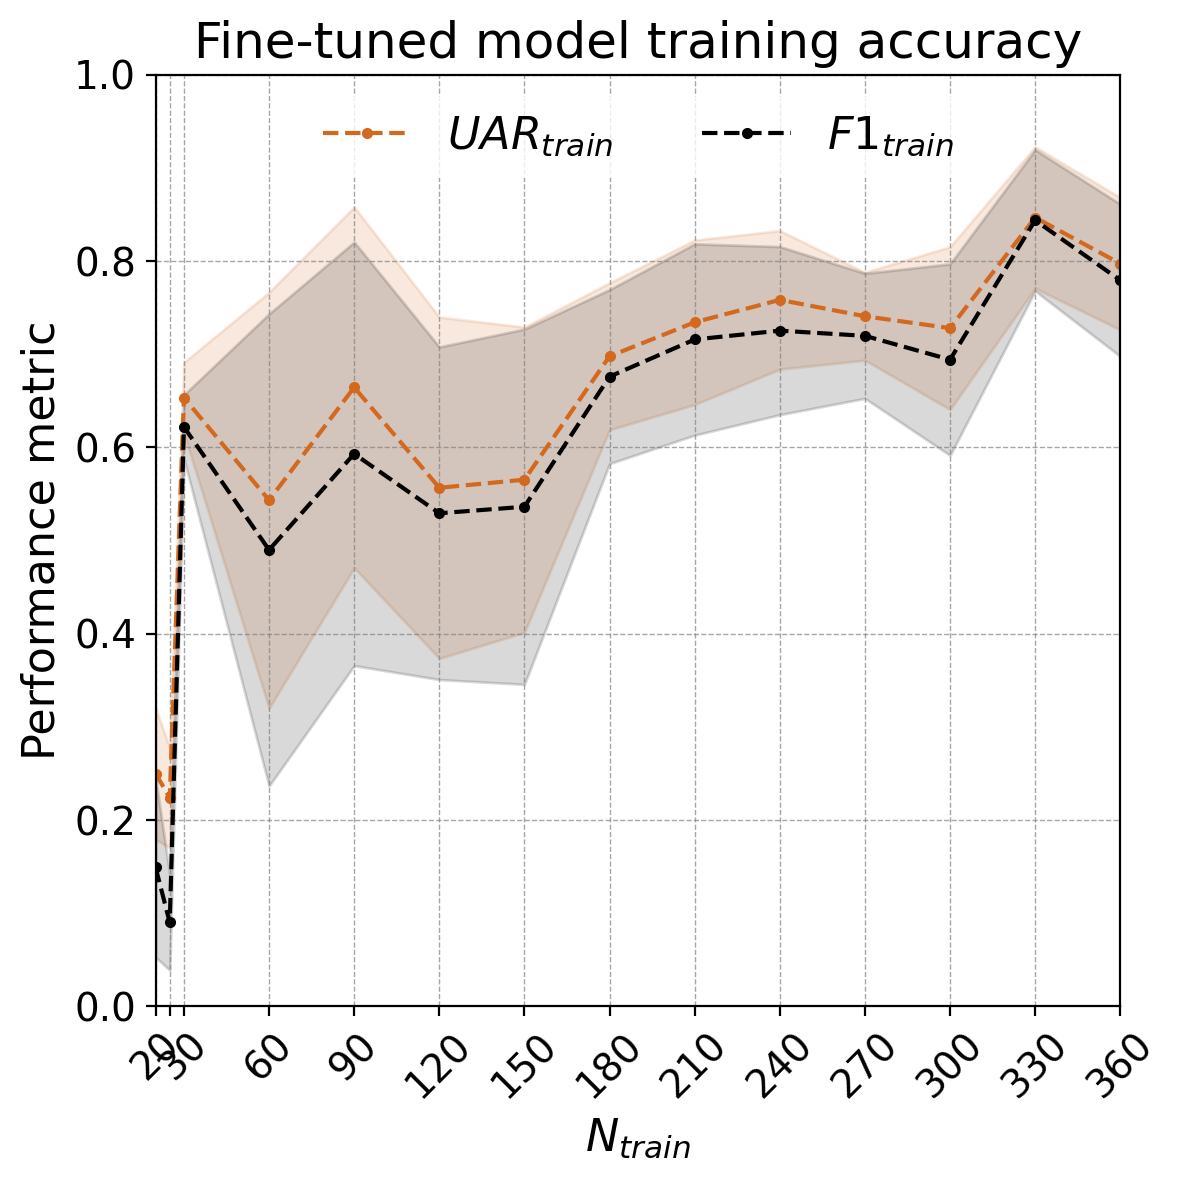

In [ ]:
plt.figure(figsize=(6, 6), dpi = 200)

plt.plot(splits, train_uar_means, '--.', color = 'chocolate', label = '$UAR_{train}$')
plt.fill_between(splits, np.array(train_uar_means) - np.array(train_uar_stds), np.array(train_uar_means) + np.array(train_uar_stds), color='chocolate', alpha=0.15)

plt.plot(splits, train_macro_f1_means, '--.', color = 'k', label = '$F1_{train}$')
plt.fill_between(splits, np.array(train_macro_f1_means) - np.array(train_macro_f1_stds), np.array(train_macro_f1_means) + np.array(train_macro_f1_stds), color='k', alpha=0.15)

plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

plt.ylim([0,1])
plt.xlim([20, 360])
plt.xticks(ticks=splits, labels = [20, '', 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], rotation = 45)
plt.legend(loc='upper center', ncol = 2, facecolor='white', edgecolor = 'white')
plt.title('Fine-tuned model training accuracy')
plt.xlabel('$N_{train}$')
plt.ylabel('Performance metric')
plt.tight_layout()
plt.show()

### Transfer to DES

In [ ]:
id2label = {0: 'anger', 1: 'boredom', 2: 'happiness', 3: 'neutral', 4: 'sadness'}

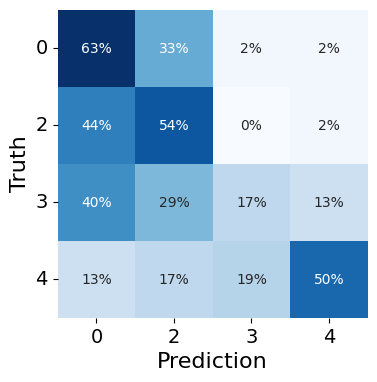

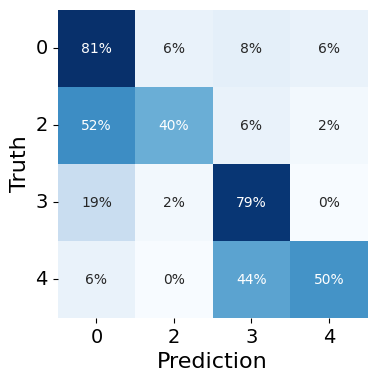

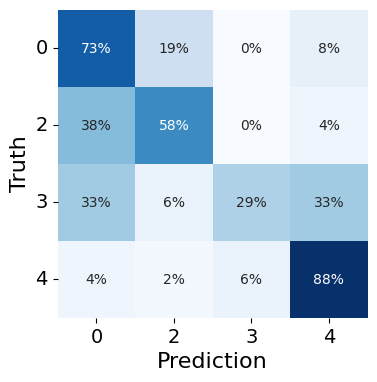

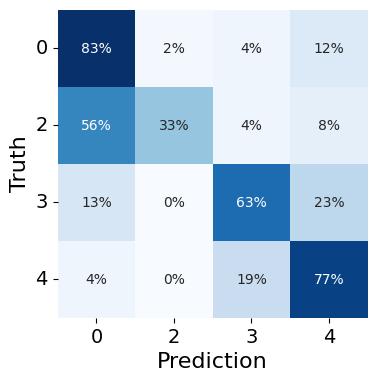

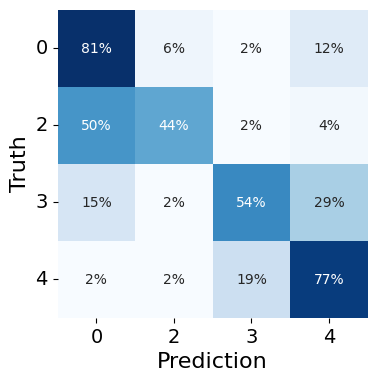

In [ ]:
FT_results = []

test_true, test_pred = [], []

for i in range(5):
  Ntrain = 330
  train_predictions = list(np.load(ntrain_results_path + f'DES_transfer/Ntrain_{Ntrain}_Kfold_{i}_train_predictions.npy', allow_pickle=True))
  val_predictions = list(np.load(ntrain_results_path + f'DES_transfer/Ntrain_{Ntrain}_Kfold_{i}_val_predictions.npy', allow_pickle=True))
  test_predictions = list(np.load(ntrain_results_path + f'DES_transfer/Ntrain_{Ntrain}_Kfold_{i}_test_predictions.npy', allow_pickle=True))
  DES_predictions = list(np.load(ntrain_results_path + f'DES_transfer/Ntrain_{Ntrain}_Kfold_{i}_DES_predictions.npy', allow_pickle=True))

  # Adjust predictions if the top prediction is 'boredom'
  DES_preds = []
  for logits in DES_predictions[0]['logits'].tolist():
    if np.argsort(logits)[-1] == 1:
      second_best = np.argsort(logits)[-2]
      DES_preds.append(second_best)
    else:
      DES_preds.append(np.argsort(logits)[-1])

  test_pred += DES_preds
  test_true += DES_predictions[0]['label_ids'].tolist()

  train_uar, train_macro_f1 = compute_metrics(train_predictions[0]['label_ids'], train_predictions[0]['predictions'])
  val_uar, val_macro_f1 = compute_metrics(val_predictions[0]['label_ids'], val_predictions[0]['predictions'])
  test_uar, test_macro_f1 = compute_metrics(test_predictions[0]['label_ids'], test_predictions[0]['predictions'])
  DES_uar, DES_macro_f1 = compute_metrics(DES_predictions[0]['label_ids'], DES_preds)

  plt.figure(figsize = (4,4))
  audplot.confusion_matrix(
    DES_predictions[0]['label_ids'],
    DES_preds,
    percentage=True
  )
  plt.show()

  FT_results.append({'train_uar': train_uar, 'train_macro_f1': train_macro_f1, 'val_uar': val_uar, 'val_macro_f1': val_macro_f1, 'test_uar': test_uar, 'test_macro_f1': test_macro_f1, 'DES_uar': DES_uar, 'DES_macro_f1': DES_macro_f1})

In [ ]:
DES_results = pd.DataFrame(FT_results)
DES_results

train_uar  train_macro_f1   val_uar  val_macro_f1  test_uar  test_macro_f1  \
0   0.630303        0.575328  0.555556      0.505061  0.488889       0.433333   
1   0.803030        0.771519  0.666667      0.646121  0.622222       0.603627   
2   0.866667        0.866044  0.577778      0.577434  0.711111       0.703759   
3   0.857576        0.850759  0.666667      0.650427  0.644444       0.609899   
4   0.857576        0.852587  0.711111      0.690136  0.533333       0.505681   

    DES_uar  DES_macro_f1  
0  0.461538      0.448951  
1  0.625000      0.618283  
2  0.620192      0.600762  
3  0.639423      0.625188  
4  0.639423      0.632628

### Transfer to EMODB

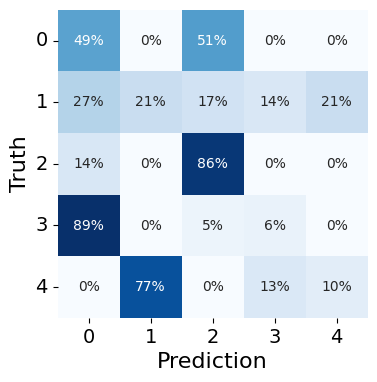

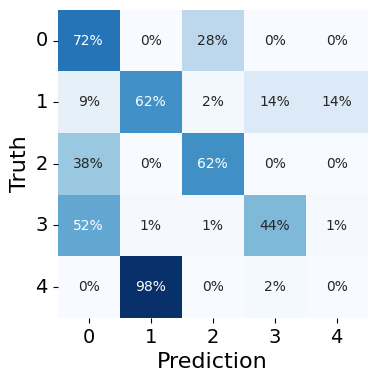

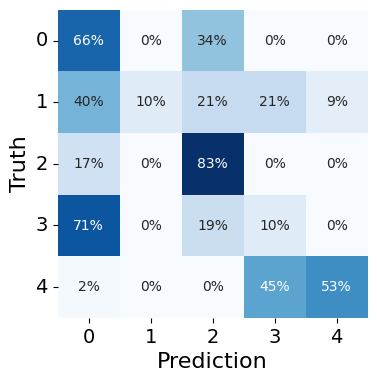

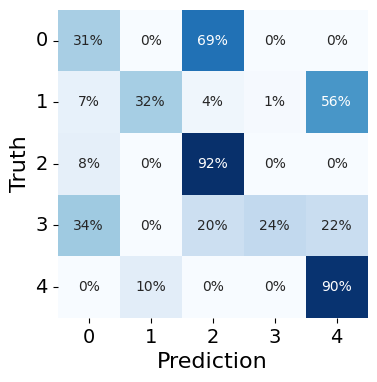

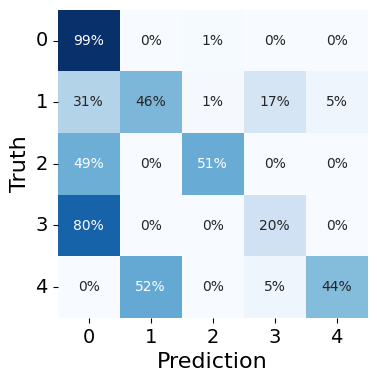

In [ ]:
FT_results = []

test_true, test_pred = [], []

for i in range(5):
  Ntrain = 330
  train_predictions = list(np.load(ntrain_results_path + f'EMODB_transfer/Ntrain_{Ntrain}_Kfold_{i}_train_predictions.npy', allow_pickle=True))
  val_predictions = list(np.load(ntrain_results_path + f'EMODB_transfer/Ntrain_{Ntrain}_Kfold_{i}_val_predictions.npy', allow_pickle=True))
  test_predictions = list(np.load(ntrain_results_path + f'EMODB_transfer/Ntrain_{Ntrain}_Kfold_{i}_test_predictions.npy', allow_pickle=True))
  EMODB_predictions = list(np.load(ntrain_results_path + f'EMODB_transfer/Ntrain_{Ntrain}_Kfold_{i}_EMODB_predictions.npy', allow_pickle=True))

  test_pred += EMODB_predictions[0]['predictions'].tolist()
  test_true += EMODB_predictions[0]['label_ids'].tolist()

  train_uar, train_macro_f1 = compute_metrics(train_predictions[0]['label_ids'], train_predictions[0]['predictions'])
  val_uar, val_macro_f1 = compute_metrics(val_predictions[0]['label_ids'], val_predictions[0]['predictions'])
  test_uar, test_macro_f1 = compute_metrics(test_predictions[0]['label_ids'], test_predictions[0]['predictions'])
  EMODB_uar, EMODB_macro_f1 = compute_metrics(EMODB_predictions[0]['label_ids'], EMODB_predictions[0]['predictions'])

  plt.figure(figsize = (4,4))
  audplot.confusion_matrix(
    EMODB_predictions[0]['label_ids'],
    EMODB_predictions[0]['predictions'],
    percentage=True
  )
  plt.show()

  FT_results.append({'train_uar': train_uar, 'train_macro_f1': train_macro_f1, 'val_uar': val_uar, 'val_macro_f1': val_macro_f1, 'test_uar': test_uar, 'test_macro_f1': test_macro_f1, 'EMODB_uar': EMODB_uar, 'EMODB_macro_f1': EMODB_macro_f1})

In [ ]:
EMODB_results = pd.DataFrame(FT_results)
EMODB_results

train_uar  train_macro_f1   val_uar  val_macro_f1  test_uar  test_macro_f1  \
0   0.760606        0.748860  0.511111      0.496376  0.444444       0.413112   
1   0.706061        0.648708  0.600000      0.532194  0.555556       0.495765   
2   0.836364        0.830535  0.666667      0.642744  0.622222       0.565000   
3   0.818182        0.818049  0.600000      0.605129  0.622222       0.636732   
4   0.775758        0.755107  0.733333      0.720312  0.577778       0.540317   

   EMODB_uar  EMODB_macro_f1  
0   0.343457        0.292940  
1   0.480890        0.454941  
2   0.444939        0.412424  
3   0.539035        0.478355  
4   0.518795        0.538091

## SVM for w2v2 FT dim

Load w2v2 FT dim features for EmoTale DK

In [ ]:
EmoTale_w2v2_FT_dim_features = load_features('EmoTale_v2', 'w2v2 FT dim', include_info = True)
EmoTale_w2v2_FT_dim_features['language'] = [path[22:24] for path in EmoTale_w2v2_FT_dim_features['path']]
EmoTale_w2v2_FT_dim_features = EmoTale_w2v2_FT_dim_features[EmoTale_w2v2_FT_dim_features['language'] == 'DK']
EmoTale_w2v2_FT_dim_features.drop('language', axis = 1, inplace = True)

In [ ]:
def SVM_Ntrain_experiment(train_df, val_df, test_df, get_preds = False):
  check_datasplits(train_df, val_df, test_df)

  # Load w2v2 FT dim features
  train_df = pd.merge(EmoTale_w2v2_FT_dim_features, train_df['path'], on = 'path')
  val_df = pd.merge(EmoTale_w2v2_FT_dim_features, val_df['path'], on = 'path')
  test_df = pd.merge(EmoTale_w2v2_FT_dim_features, test_df['path'], on = 'path')

  clf = make_pipeline(
    StandardScaler(),
    OneVsOneClassifier(SVC(kernel = 'linear', random_state=42))
  )

  train_x = train_df.iloc[:,4:]
  train_y = train_df['emotion']
  clf.fit(train_x, train_y)

  train_true, train_pred = train_df['emotion'], clf.predict(train_df.iloc[:,4:])
  val_true, val_pred = val_df['emotion'], clf.predict(val_df.iloc[:,4:])
  test_true, test_pred = test_df['emotion'], clf.predict(test_df.iloc[:,4:])

  train_uar, train_macro_f1 = compute_metrics(train_true, train_pred)
  val_uar, val_macro_f1 = compute_metrics(val_true, val_pred)
  test_uar, test_macro_f1 = compute_metrics(test_true, test_pred)

  if get_preds:
    return val_pred.tolist(), val_true.tolist(), test_pred.tolist(), test_true.tolist()
  else:
    return {'train_uar': train_uar, 'train_macro_f1': train_macro_f1, 'val_uar': val_uar, 'val_macro_f1': val_macro_f1, 'test_uar': test_uar, 'test_macro_f1': test_macro_f1}

In [ ]:
SVM_results_360 = []
SVM_results_330 = []
SVM_results_300 = []
SVM_results_270 = []
SVM_results_240 = []
SVM_results_210 = []
SVM_results_180 = []
SVM_results_150 = []
SVM_results_120 = []
SVM_results_90 = []
SVM_results_60 = []
SVM_results_30 = []
SVM_results_25 = []
SVM_results_20 = []
SVM_results_15 = []
SVM_results_10 = []
SVM_results_5 = []

for i in range(5):
  test_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntest{i+1}.csv')
  val_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/nval{i+1}.csv')

  train_df_360 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_360.csv')
  train_df_330 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_330.csv')
  train_df_300 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_300.csv')
  train_df_270 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_270.csv')
  train_df_240 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_240.csv')
  train_df_210 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_210.csv')
  train_df_180 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_180.csv')
  train_df_150 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_150.csv')
  train_df_120 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_120.csv')
  train_df_90 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_90.csv')
  train_df_60 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_60.csv')
  train_df_30 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_30.csv')
  train_df_25 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_25.csv')
  train_df_20 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_20.csv')
  train_df_15 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_15.csv')
  train_df_10 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_10.csv')
  train_df_5 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_5.csv')

  SVM_results_360.append(SVM_Ntrain_experiment(train_df_360, val_df, test_df))
  SVM_results_330.append(SVM_Ntrain_experiment(train_df_330, val_df, test_df))
  SVM_results_300.append(SVM_Ntrain_experiment(train_df_300, val_df, test_df))
  SVM_results_270.append(SVM_Ntrain_experiment(train_df_270, val_df, test_df))
  SVM_results_240.append(SVM_Ntrain_experiment(train_df_240, val_df, test_df))
  SVM_results_210.append(SVM_Ntrain_experiment(train_df_210, val_df, test_df))
  SVM_results_180.append(SVM_Ntrain_experiment(train_df_180, val_df, test_df))
  SVM_results_150.append(SVM_Ntrain_experiment(train_df_150, val_df, test_df))
  SVM_results_120.append(SVM_Ntrain_experiment(train_df_120, val_df, test_df))
  SVM_results_90.append(SVM_Ntrain_experiment(train_df_90, val_df, test_df))
  SVM_results_60.append(SVM_Ntrain_experiment(train_df_60, val_df, test_df))
  SVM_results_30.append(SVM_Ntrain_experiment(train_df_30, val_df, test_df))
  SVM_results_25.append(SVM_Ntrain_experiment(train_df_25, val_df, test_df))
  SVM_results_20.append(SVM_Ntrain_experiment(train_df_20, val_df, test_df))
  SVM_results_15.append(SVM_Ntrain_experiment(train_df_15, val_df, test_df))
  SVM_results_10.append(SVM_Ntrain_experiment(train_df_10, val_df, test_df))
  SVM_results_5.append(SVM_Ntrain_experiment(train_df_5, val_df, test_df))

In [ ]:
SVM_results_360_df = pd.DataFrame(SVM_results_360)
SVM_results_330_df = pd.DataFrame(SVM_results_330)
SVM_results_300_df = pd.DataFrame(SVM_results_300)
SVM_results_270_df = pd.DataFrame(SVM_results_270)
SVM_results_240_df = pd.DataFrame(SVM_results_240)
SVM_results_210_df = pd.DataFrame(SVM_results_210)
SVM_results_180_df = pd.DataFrame(SVM_results_180)
SVM_results_150_df = pd.DataFrame(SVM_results_150)
SVM_results_120_df = pd.DataFrame(SVM_results_120)
SVM_results_90_df = pd.DataFrame(SVM_results_90)
SVM_results_60_df = pd.DataFrame(SVM_results_60)
SVM_results_30_df = pd.DataFrame(SVM_results_30)
SVM_results_25_df = pd.DataFrame(SVM_results_25)
SVM_results_20_df = pd.DataFrame(SVM_results_20)
SVM_results_15_df = pd.DataFrame(SVM_results_15)
SVM_results_10_df = pd.DataFrame(SVM_results_10)
SVM_results_5_df = pd.DataFrame(SVM_results_5)

In [ ]:
SVM_dim_results_330_df = SVM_results_330_df

In [ ]:
splits = [5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
val_uar_means = [SVM_results_5_df['val_uar'].mean(), SVM_results_10_df['val_uar'].mean(), SVM_results_15_df['val_uar'].mean(), SVM_results_20_df['val_uar'].mean(), SVM_results_25_df['val_uar'].mean(), SVM_results_30_df['val_uar'].mean(), SVM_results_60_df['val_uar'].mean(), SVM_results_90_df['val_uar'].mean(), SVM_results_120_df['val_uar'].mean(), SVM_results_150_df['val_uar'].mean(), SVM_results_180_df['val_uar'].mean(), SVM_results_210_df['val_uar'].mean(), SVM_results_240_df['val_uar'].mean(), SVM_results_270_df['val_uar'].mean(), SVM_results_300_df['val_uar'].mean(), SVM_results_330_df['val_uar'].mean(), SVM_results_360_df['val_uar'].mean()]

val_uar_stds = [SVM_results_5_df['val_uar'].std(), SVM_results_10_df['val_uar'].std(), SVM_results_15_df['val_uar'].std(), SVM_results_20_df['val_uar'].std(), SVM_results_25_df['val_uar'].std(), SVM_results_30_df['val_uar'].std(), SVM_results_60_df['val_uar'].std(), SVM_results_90_df['val_uar'].std(), SVM_results_120_df['val_uar'].std(), SVM_results_150_df['val_uar'].std(), SVM_results_180_df['val_uar'].std(), SVM_results_210_df['val_uar'].std(), SVM_results_240_df['val_uar'].std(), SVM_results_270_df['val_uar'].std(), SVM_results_300_df['val_uar'].std(), SVM_results_330_df['val_uar'].std(), SVM_results_360_df['val_uar'].std()]

val_macro_f1_means = [SVM_results_5_df['val_macro_f1'].mean(), SVM_results_10_df['val_macro_f1'].mean(), SVM_results_15_df['val_macro_f1'].mean(), SVM_results_20_df['val_macro_f1'].mean(), SVM_results_25_df['val_macro_f1'].mean(), SVM_results_30_df['val_macro_f1'].mean(), SVM_results_60_df['val_macro_f1'].mean(), SVM_results_90_df['val_macro_f1'].mean(), SVM_results_120_df['val_macro_f1'].mean(), SVM_results_150_df['val_macro_f1'].mean(), SVM_results_180_df['val_macro_f1'].mean(), SVM_results_210_df['val_macro_f1'].mean(), SVM_results_240_df['val_macro_f1'].mean(), SVM_results_270_df['val_macro_f1'].mean(), SVM_results_300_df['val_macro_f1'].mean(), SVM_results_330_df['val_macro_f1'].mean(), SVM_results_360_df['val_macro_f1'].mean()]

val_macro_f1_stds = [SVM_results_5_df['val_macro_f1'].std(), SVM_results_10_df['val_macro_f1'].std(), SVM_results_15_df['val_macro_f1'].std(), SVM_results_20_df['val_macro_f1'].std(), SVM_results_25_df['val_macro_f1'].std(), SVM_results_30_df['val_macro_f1'].std(), SVM_results_60_df['val_macro_f1'].std(), SVM_results_90_df['val_macro_f1'].std(), SVM_results_120_df['val_macro_f1'].std(), SVM_results_150_df['val_macro_f1'].std(), SVM_results_180_df['val_macro_f1'].std(), SVM_results_210_df['val_macro_f1'].std(), SVM_results_240_df['val_macro_f1'].std(), SVM_results_270_df['val_macro_f1'].std(), SVM_results_300_df['val_macro_f1'].std(), SVM_results_330_df['val_macro_f1'].std(), SVM_results_360_df['val_macro_f1'].std()]

test_uar_means = [SVM_results_5_df['test_uar'].mean(), SVM_results_10_df['test_uar'].mean(), SVM_results_15_df['test_uar'].mean(), SVM_results_20_df['test_uar'].mean(), SVM_results_25_df['test_uar'].mean(), SVM_results_30_df['test_uar'].mean(), SVM_results_60_df['test_uar'].mean(), SVM_results_90_df['test_uar'].mean(), SVM_results_120_df['test_uar'].mean(), SVM_results_150_df['test_uar'].mean(), SVM_results_180_df['test_uar'].mean(), SVM_results_210_df['test_uar'].mean(), SVM_results_240_df['test_uar'].mean(), SVM_results_270_df['test_uar'].mean(), SVM_results_300_df['test_uar'].mean(), SVM_results_330_df['test_uar'].mean(), SVM_results_360_df['test_uar'].mean()]

test_uar_stds = [SVM_results_5_df['test_uar'].std(), SVM_results_10_df['test_uar'].std(), SVM_results_15_df['test_uar'].std(), SVM_results_20_df['test_uar'].std(), SVM_results_25_df['test_uar'].std(), SVM_results_30_df['test_uar'].std(), SVM_results_60_df['test_uar'].std(), SVM_results_90_df['test_uar'].std(), SVM_results_120_df['test_uar'].std(), SVM_results_150_df['test_uar'].std(), SVM_results_180_df['test_uar'].std(), SVM_results_210_df['test_uar'].std(), SVM_results_240_df['test_uar'].std(), SVM_results_270_df['test_uar'].std(), SVM_results_300_df['test_uar'].std(), SVM_results_330_df['test_uar'].std(), SVM_results_360_df['test_uar'].std()]

test_macro_f1_means = [SVM_results_5_df['test_macro_f1'].mean(), SVM_results_10_df['test_macro_f1'].mean(), SVM_results_15_df['test_macro_f1'].mean(), SVM_results_20_df['test_macro_f1'].mean(), SVM_results_25_df['test_macro_f1'].mean(), SVM_results_30_df['test_macro_f1'].mean(), SVM_results_60_df['test_macro_f1'].mean(), SVM_results_90_df['test_macro_f1'].mean(), SVM_results_120_df['test_macro_f1'].mean(), SVM_results_150_df['test_macro_f1'].mean(), SVM_results_180_df['test_macro_f1'].mean(), SVM_results_210_df['test_macro_f1'].mean(), SVM_results_240_df['test_macro_f1'].mean(), SVM_results_270_df['test_macro_f1'].mean(), SVM_results_300_df['test_macro_f1'].mean(), SVM_results_330_df['test_macro_f1'].mean(), SVM_results_360_df['test_macro_f1'].mean()]

test_macro_f1_stds = [SVM_results_5_df['test_macro_f1'].std(), SVM_results_10_df['test_macro_f1'].std(), SVM_results_15_df['test_macro_f1'].std(), SVM_results_20_df['test_macro_f1'].std(), SVM_results_25_df['test_macro_f1'].std(), SVM_results_30_df['test_macro_f1'].std(), SVM_results_60_df['test_macro_f1'].std(), SVM_results_90_df['test_macro_f1'].std(), SVM_results_120_df['test_macro_f1'].std(), SVM_results_150_df['test_macro_f1'].std(), SVM_results_180_df['test_macro_f1'].std(), SVM_results_210_df['test_macro_f1'].std(), SVM_results_240_df['test_macro_f1'].std(), SVM_results_270_df['test_macro_f1'].std(), SVM_results_300_df['test_macro_f1'].std(), SVM_results_330_df['test_macro_f1'].std(), SVM_results_360_df['test_macro_f1'].std()]

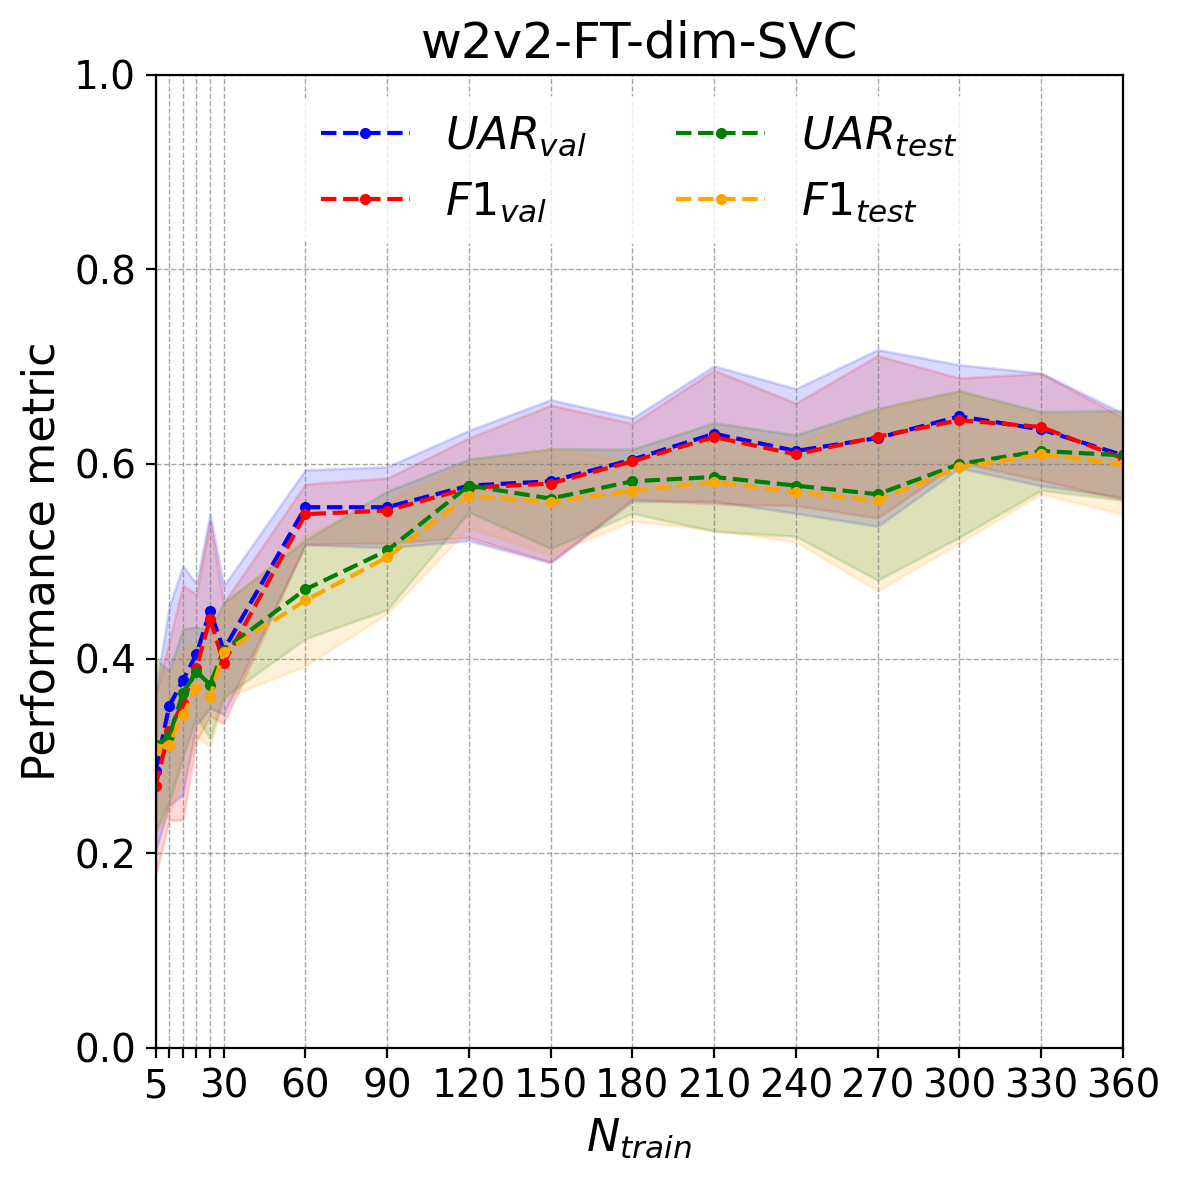

In [ ]:
plt.figure(figsize=(6, 6), dpi = 200)

plt.plot(splits, val_uar_means, 'b--.', label = '$UAR_{val}$')
plt.fill_between(splits, np.array(val_uar_means) - np.array(val_uar_stds), np.array(val_uar_means) + np.array(val_uar_stds), color='b', alpha=0.15)

plt.plot(splits, val_macro_f1_means, 'r--.', label = '$F1_{val}$')
plt.fill_between(splits, np.array(val_macro_f1_means) - np.array(val_macro_f1_stds), np.array(val_macro_f1_means) + np.array(val_macro_f1_stds), color='r', alpha=0.15)

plt.plot(splits, test_uar_means, 'g--.', label = '$UAR_{test}$')
plt.fill_between(splits, np.array(test_uar_means) - np.array(test_uar_stds), np.array(test_uar_means) + np.array(test_uar_stds), color='g', alpha=0.15)

plt.plot(splits, test_macro_f1_means, '--.', color = 'orange', label = '$F1_{test}$')
plt.fill_between(splits, np.array(test_macro_f1_means) - np.array(test_macro_f1_stds), np.array(test_macro_f1_means) + np.array(test_macro_f1_stds), color='orange', alpha=0.15)

plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

plt.ylim([0,1])
plt.xlim([5,360])
plt.xticks(ticks=splits, labels = [5, '', '', '', '', 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
plt.legend(loc='upper center', ncol = 2, facecolor='white', edgecolor = 'white')
plt.xlabel('$N_{train}$')
plt.ylabel('Performance metric')
plt.title('w2v2-FT-dim-SVC')
plt.tight_layout()
plt.show()

In [ ]:
SVM_predictions = []
ntrain = [360, 330, 300, 270, 240, 210, 180, 150, 120, 90, 60, 30, 25, 20, 15, 10, 5]

for n in range(17):
  Ntrain = ntrain[n]
  val_pred, test_pred = [], []
  val_true, test_true = [], []

  for i in range(5):
    test_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntest{i+1}.csv')
    val_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/nval{i+1}.csv')
    train_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_{Ntrain}.csv')

    val_pred_SVM, val_true_SVM, test_pred_SVM, test_true_SVM = SVM_Ntrain_experiment(train_df, val_df, test_df, get_preds = True)

    val_pred += val_pred_SVM
    val_true += val_true_SVM
    test_pred += test_pred_SVM
    test_true += test_true_SVM

  SVM_predictions.append({'val_pred': val_pred, 'val_true': val_true, 'test_pred': test_pred, 'test_true': test_true})

In [ ]:
SVM_predictions_360 = SVM_predictions[0]
SVM_predictions_330 = SVM_predictions[1]
SVM_predictions_300 = SVM_predictions[2]
SVM_predictions_270 = SVM_predictions[3]
SVM_predictions_240 = SVM_predictions[4]
SVM_predictions_210 = SVM_predictions[5]
SVM_predictions_180 = SVM_predictions[6]
SVM_predictions_150 = SVM_predictions[7]
SVM_predictions_120 = SVM_predictions[8]
SVM_predictions_90 = SVM_predictions[9]
SVM_predictions_60 = SVM_predictions[10]
SVM_predictions_30 = SVM_predictions[11]
SVM_predictions_25 = SVM_predictions[12]
SVM_predictions_20 = SVM_predictions[13]
SVM_predictions_15 = SVM_predictions[14]
SVM_predictions_10 = SVM_predictions[15]
SVM_predictions_5 = SVM_predictions[16]

In [ ]:
predictions = [SVM_predictions_360, SVM_predictions_330, SVM_predictions_300, SVM_predictions_270, SVM_predictions_240, SVM_predictions_210, SVM_predictions_180, SVM_predictions_150, SVM_predictions_120, SVM_predictions_90, SVM_predictions_60, SVM_predictions_30, SVM_predictions_25, SVM_predictions_20, SVM_predictions_15, SVM_predictions_10, SVM_predictions_5]

results = [SVM_results_360_df, SVM_results_330_df, SVM_results_300_df, SVM_results_270_df, SVM_results_240_df, SVM_results_210_df, SVM_results_180_df, SVM_results_150_df, SVM_results_120_df, SVM_results_90_df, SVM_results_60_df, SVM_results_30_df, SVM_results_25_df, SVM_results_20_df, SVM_results_15_df, SVM_results_10_df, SVM_results_5_df]

In [ ]:
data = []

for split, result, preds in zip(splits, results[::-1], predictions[::-1]):
  val_uar, val_f1 = compute_metrics(preds['val_true'], preds['val_pred'])
  test_uar, test_f1 = compute_metrics(preds['test_true'], preds['test_pred'])
  data.append({
      'split': split,
      'uar_val': (round(val_uar, 2), round(result['val_uar'].std(), 2)),
      'f1_macro_val': (round(val_f1, 2), round(result['val_macro_f1'].std(), 2)),
      'uar_test': (round(test_uar, 2), round(result['test_uar'].std(), 2)),
      'f1_macro_test': (round(test_f1, 2),round(result['test_macro_f1'].std(), 2)),
  })

results_df = pd.DataFrame(data)

In [ ]:
results_df

split       uar_val  f1_macro_val      uar_test f1_macro_test
0       5  (0.28, 0.08)  (0.28, 0.09)  (0.31, 0.09)  (0.31, 0.09)
1      10   (0.35, 0.1)  (0.34, 0.09)  (0.32, 0.07)  (0.32, 0.07)
2      15  (0.38, 0.12)  (0.37, 0.12)  (0.36, 0.07)  (0.35, 0.07)
3      20   (0.4, 0.07)   (0.4, 0.08)  (0.39, 0.05)  (0.39, 0.05)
4      25   (0.45, 0.1)   (0.44, 0.1)  (0.37, 0.06)  (0.37, 0.05)
5      30  (0.41, 0.07)  (0.41, 0.06)  (0.41, 0.05)  (0.41, 0.05)
6      60  (0.56, 0.04)  (0.55, 0.03)  (0.47, 0.05)  (0.47, 0.07)
7      90  (0.56, 0.04)  (0.56, 0.03)  (0.51, 0.06)  (0.51, 0.06)
8     120  (0.58, 0.06)  (0.58, 0.05)  (0.58, 0.03)  (0.58, 0.03)
9     150  (0.58, 0.08)  (0.58, 0.08)  (0.56, 0.05)  (0.57, 0.05)
10    180   (0.6, 0.04)   (0.6, 0.04)  (0.58, 0.03)  (0.58, 0.03)
11    210  (0.63, 0.07)  (0.63, 0.07)  (0.59, 0.06)  (0.58, 0.05)
12    240  (0.61, 0.06)  (0.61, 0.05)  (0.58, 0.05)  (0.58, 0.05)
13    270  (0.63, 0.09)  (0.63, 0.08)  (0.57, 0.09)  (0.57, 0.09)
14    300  (0.65, 0.05)  (0.65, 0.04)   (0.6, 0.08)   (0.6, 0.08)
15    330  (0.64, 0.06)  (0.64, 0.06)  (0.61, 0.04)  (0.61, 0.04)
16    360  (0.61, 0.04)  (0.61, 0.04)  (0.61, 0.05)   (0.6, 0.05)

### Transfer to EMODB

In [ ]:
EmoTale_w2v2_FT_dim_features = load_features('EmoTale_v2', 'w2v2 FT dim', include_info = True)
EmoTale_w2v2_FT_dim_features['language'] = [path[22:24] for path in EmoTale_w2v2_FT_dim_features['path']]
EmoTale_w2v2_FT_dim_features = EmoTale_w2v2_FT_dim_features[EmoTale_w2v2_FT_dim_features['language'] == 'DK']
EmoTale_w2v2_FT_dim_features.drop('language', axis = 1, inplace = True)

In [ ]:
EMODB_w2v2_FT_dim_features = load_features('EMODB', 'w2v2 FT dim', include_info = True)

In [ ]:
idx_to_emo_dict = {0: 'anger', 1: 'boredom', 2: 'happiness', 3: 'neutral', 4: 'sadness'}

In [ ]:
def SVM_Ntrain_experiment_EMODB(train_df, test_df, get_preds = False):
  # Load w2v2 FT dim features
  train_df = pd.merge(EmoTale_w2v2_FT_dim_features, train_df['path'], on = 'path')
  test_df = pd.merge(EMODB_w2v2_FT_dim_features, test_df['path'], on = 'path')

  clf = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(SVC(kernel = 'linear', random_state=42, probability = True))
  )

  train_x = train_df.iloc[:,4:]
  train_y = train_df['emotion']
  clf.fit(train_x, train_y)

  train_true, train_pred = train_df['emotion'], clf.predict(train_df.iloc[:,4:])
  test_true, test_pred = test_df['emotion'], clf.predict(test_df.iloc[:,4:])
  logits = clf.predict_proba(test_df.iloc[:,4:])

  train_uar, train_macro_f1 = compute_metrics(train_true, train_pred)
  test_uar, test_macro_f1 = compute_metrics(test_true, test_pred)
  if get_preds:
    return test_pred.tolist(), test_true.tolist()
  else:
    return {'train_uar': train_uar, 'train_macro_f1': train_macro_f1, 'test_uar': test_uar, 'test_macro_f1': test_macro_f1}

In [ ]:
SVM_EMODB_results = []
SVM_predictions = []

test_true, test_pred = [], []

for i in range(5):
  test_df = df_EMODB[df_EMODB['emotion'].isin(['anger', 'happiness', 'sadness', 'neutral', 'boredom'])].reset_index(drop=True)

  train_df_360 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_360.csv')
  train_df_330 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_330.csv')
  train_df_300 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_300.csv')

  SVM_EMODB_results.append(SVM_Ntrain_experiment_EMODB(train_df_330, test_df))

  test_pred_SVM, test_true_SVM = SVM_Ntrain_experiment_EMODB(train_df_330, test_df, get_preds = True)
  test_pred += test_pred_SVM
  test_true += test_true_SVM

SVM_predictions.append({'test_pred': test_pred, 'test_true': test_true})

In [ ]:
pd.DataFrame(SVM_EMODB_results)['test_uar'].std()

0.04342172879319652

In [ ]:
pd.DataFrame(SVM_EMODB_results)['test_macro_f1'].std()

0.06648493929429691

In [ ]:
compute_metrics(SVM_predictions[0]['test_true'], SVM_predictions[0]['test_pred'])

(0.6278458728904719, 0.6201526210023706)

## SVM for w2v2 xlsr danish

Load w2v2 xlsr danish features for EmoTale DK

In [ ]:
EmoTale_w2v2_FT_dim_features = load_features('EmoTale_v2', 'w2v2 FT danish', include_info = True)
EmoTale_w2v2_FT_dim_features['language'] = [path[22:24] for path in EmoTale_w2v2_FT_dim_features['path']]
EmoTale_w2v2_FT_dim_features = EmoTale_w2v2_FT_dim_features[EmoTale_w2v2_FT_dim_features['language'] == 'DK']
EmoTale_w2v2_FT_dim_features.drop('language', axis = 1, inplace = True)

In [ ]:
def SVM_Ntrain_experiment(train_df, val_df, test_df, get_preds = False):
  check_datasplits(train_df, val_df, test_df)

  # Load w2v2 FT dim features
  train_df = pd.merge(EmoTale_w2v2_FT_dim_features, train_df['path'], on = 'path')
  val_df = pd.merge(EmoTale_w2v2_FT_dim_features, val_df['path'], on = 'path')
  test_df = pd.merge(EmoTale_w2v2_FT_dim_features, test_df['path'], on = 'path')

  clf = make_pipeline(
    StandardScaler(),
    OneVsOneClassifier(SVC(kernel = 'linear', random_state=42))
  )

  train_x = train_df.iloc[:,4:]
  train_y = train_df['emotion']
  clf.fit(train_x, train_y)

  train_true, train_pred = train_df['emotion'], clf.predict(train_df.iloc[:,4:])
  val_true, val_pred = val_df['emotion'], clf.predict(val_df.iloc[:,4:])
  test_true, test_pred = test_df['emotion'], clf.predict(test_df.iloc[:,4:])

  train_uar, train_macro_f1 = compute_metrics(train_true, train_pred)
  val_uar, val_macro_f1 = compute_metrics(val_true, val_pred)
  test_uar, test_macro_f1 = compute_metrics(test_true, test_pred)

  if get_preds:
    return val_pred.tolist(), val_true.tolist(), test_pred.tolist(), test_true.tolist()
  else:
    return {'train_uar': train_uar, 'train_macro_f1': train_macro_f1, 'val_uar': val_uar, 'val_macro_f1': val_macro_f1, 'test_uar': test_uar, 'test_macro_f1': test_macro_f1}

In [ ]:
SVM_results_360 = []
SVM_results_330 = []
SVM_results_300 = []
SVM_results_270 = []
SVM_results_240 = []
SVM_results_210 = []
SVM_results_180 = []
SVM_results_150 = []
SVM_results_120 = []
SVM_results_90 = []
SVM_results_60 = []
SVM_results_30 = []
SVM_results_25 = []
SVM_results_20 = []
SVM_results_15 = []
SVM_results_10 = []
SVM_results_5 = []

for i in range(5):
  test_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntest{i+1}.csv')
  val_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/nval{i+1}.csv')

  train_df_360 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_360.csv')
  train_df_330 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_330.csv')
  train_df_300 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_300.csv')
  train_df_270 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_270.csv')
  train_df_240 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_240.csv')
  train_df_210 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_210.csv')
  train_df_180 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_180.csv')
  train_df_150 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_150.csv')
  train_df_120 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_120.csv')
  train_df_90 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_90.csv')
  train_df_60 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_60.csv')
  train_df_30 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_30.csv')
  train_df_25 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_25.csv')
  train_df_20 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_20.csv')
  train_df_15 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_15.csv')
  train_df_10 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_10.csv')
  train_df_5 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_5.csv')

  SVM_results_360.append(SVM_Ntrain_experiment(train_df_360, val_df, test_df))
  SVM_results_330.append(SVM_Ntrain_experiment(train_df_330, val_df, test_df))
  SVM_results_300.append(SVM_Ntrain_experiment(train_df_300, val_df, test_df))
  SVM_results_270.append(SVM_Ntrain_experiment(train_df_270, val_df, test_df))
  SVM_results_240.append(SVM_Ntrain_experiment(train_df_240, val_df, test_df))
  SVM_results_210.append(SVM_Ntrain_experiment(train_df_210, val_df, test_df))
  SVM_results_180.append(SVM_Ntrain_experiment(train_df_180, val_df, test_df))
  SVM_results_150.append(SVM_Ntrain_experiment(train_df_150, val_df, test_df))
  SVM_results_120.append(SVM_Ntrain_experiment(train_df_120, val_df, test_df))
  SVM_results_90.append(SVM_Ntrain_experiment(train_df_90, val_df, test_df))
  SVM_results_60.append(SVM_Ntrain_experiment(train_df_60, val_df, test_df))
  SVM_results_30.append(SVM_Ntrain_experiment(train_df_30, val_df, test_df))
  SVM_results_25.append(SVM_Ntrain_experiment(train_df_25, val_df, test_df))
  SVM_results_20.append(SVM_Ntrain_experiment(train_df_20, val_df, test_df))
  SVM_results_15.append(SVM_Ntrain_experiment(train_df_15, val_df, test_df))
  SVM_results_10.append(SVM_Ntrain_experiment(train_df_10, val_df, test_df))
  SVM_results_5.append(SVM_Ntrain_experiment(train_df_5, val_df, test_df))

In [ ]:
SVM_results_360_df = pd.DataFrame(SVM_results_360)
SVM_results_330_df = pd.DataFrame(SVM_results_330)
SVM_results_300_df = pd.DataFrame(SVM_results_300)
SVM_results_270_df = pd.DataFrame(SVM_results_270)
SVM_results_240_df = pd.DataFrame(SVM_results_240)
SVM_results_210_df = pd.DataFrame(SVM_results_210)
SVM_results_180_df = pd.DataFrame(SVM_results_180)
SVM_results_150_df = pd.DataFrame(SVM_results_150)
SVM_results_120_df = pd.DataFrame(SVM_results_120)
SVM_results_90_df = pd.DataFrame(SVM_results_90)
SVM_results_60_df = pd.DataFrame(SVM_results_60)
SVM_results_30_df = pd.DataFrame(SVM_results_30)
SVM_results_25_df = pd.DataFrame(SVM_results_25)
SVM_results_20_df = pd.DataFrame(SVM_results_20)
SVM_results_15_df = pd.DataFrame(SVM_results_15)
SVM_results_10_df = pd.DataFrame(SVM_results_10)
SVM_results_5_df = pd.DataFrame(SVM_results_5)

In [ ]:
SVM_danish_results_360_df = SVM_results_360_df

In [ ]:
splits = [5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
val_uar_means = [SVM_results_5_df['val_uar'].mean(), SVM_results_10_df['val_uar'].mean(), SVM_results_15_df['val_uar'].mean(), SVM_results_20_df['val_uar'].mean(), SVM_results_25_df['val_uar'].mean(), SVM_results_30_df['val_uar'].mean(), SVM_results_60_df['val_uar'].mean(), SVM_results_90_df['val_uar'].mean(), SVM_results_120_df['val_uar'].mean(), SVM_results_150_df['val_uar'].mean(), SVM_results_180_df['val_uar'].mean(), SVM_results_210_df['val_uar'].mean(), SVM_results_240_df['val_uar'].mean(), SVM_results_270_df['val_uar'].mean(), SVM_results_300_df['val_uar'].mean(), SVM_results_330_df['val_uar'].mean(), SVM_results_360_df['val_uar'].mean()]

val_uar_stds = [SVM_results_5_df['val_uar'].std(), SVM_results_10_df['val_uar'].std(), SVM_results_15_df['val_uar'].std(), SVM_results_20_df['val_uar'].std(), SVM_results_25_df['val_uar'].std(), SVM_results_30_df['val_uar'].std(), SVM_results_60_df['val_uar'].std(), SVM_results_90_df['val_uar'].std(), SVM_results_120_df['val_uar'].std(), SVM_results_150_df['val_uar'].std(), SVM_results_180_df['val_uar'].std(), SVM_results_210_df['val_uar'].std(), SVM_results_240_df['val_uar'].std(), SVM_results_270_df['val_uar'].std(), SVM_results_300_df['val_uar'].std(), SVM_results_330_df['val_uar'].std(), SVM_results_360_df['val_uar'].std()]

val_macro_f1_means = [SVM_results_5_df['val_macro_f1'].mean(), SVM_results_10_df['val_macro_f1'].mean(), SVM_results_15_df['val_macro_f1'].mean(), SVM_results_20_df['val_macro_f1'].mean(), SVM_results_25_df['val_macro_f1'].mean(), SVM_results_30_df['val_macro_f1'].mean(), SVM_results_60_df['val_macro_f1'].mean(), SVM_results_90_df['val_macro_f1'].mean(), SVM_results_120_df['val_macro_f1'].mean(), SVM_results_150_df['val_macro_f1'].mean(), SVM_results_180_df['val_macro_f1'].mean(), SVM_results_210_df['val_macro_f1'].mean(), SVM_results_240_df['val_macro_f1'].mean(), SVM_results_270_df['val_macro_f1'].mean(), SVM_results_300_df['val_macro_f1'].mean(), SVM_results_330_df['val_macro_f1'].mean(), SVM_results_360_df['val_macro_f1'].mean()]

val_macro_f1_stds = [SVM_results_5_df['val_macro_f1'].std(), SVM_results_10_df['val_macro_f1'].std(), SVM_results_15_df['val_macro_f1'].std(), SVM_results_20_df['val_macro_f1'].std(), SVM_results_25_df['val_macro_f1'].std(), SVM_results_30_df['val_macro_f1'].std(), SVM_results_60_df['val_macro_f1'].std(), SVM_results_90_df['val_macro_f1'].std(), SVM_results_120_df['val_macro_f1'].std(), SVM_results_150_df['val_macro_f1'].std(), SVM_results_180_df['val_macro_f1'].std(), SVM_results_210_df['val_macro_f1'].std(), SVM_results_240_df['val_macro_f1'].std(), SVM_results_270_df['val_macro_f1'].std(), SVM_results_300_df['val_macro_f1'].std(), SVM_results_330_df['val_macro_f1'].std(), SVM_results_360_df['val_macro_f1'].std()]

test_uar_means = [SVM_results_5_df['test_uar'].mean(), SVM_results_10_df['test_uar'].mean(), SVM_results_15_df['test_uar'].mean(), SVM_results_20_df['test_uar'].mean(), SVM_results_25_df['test_uar'].mean(), SVM_results_30_df['test_uar'].mean(), SVM_results_60_df['test_uar'].mean(), SVM_results_90_df['test_uar'].mean(), SVM_results_120_df['test_uar'].mean(), SVM_results_150_df['test_uar'].mean(), SVM_results_180_df['test_uar'].mean(), SVM_results_210_df['test_uar'].mean(), SVM_results_240_df['test_uar'].mean(), SVM_results_270_df['test_uar'].mean(), SVM_results_300_df['test_uar'].mean(), SVM_results_330_df['test_uar'].mean(), SVM_results_360_df['test_uar'].mean()]

test_uar_stds = [SVM_results_5_df['test_uar'].std(), SVM_results_10_df['test_uar'].std(), SVM_results_15_df['test_uar'].std(), SVM_results_20_df['test_uar'].std(), SVM_results_25_df['test_uar'].std(), SVM_results_30_df['test_uar'].std(), SVM_results_60_df['test_uar'].std(), SVM_results_90_df['test_uar'].std(), SVM_results_120_df['test_uar'].std(), SVM_results_150_df['test_uar'].std(), SVM_results_180_df['test_uar'].std(), SVM_results_210_df['test_uar'].std(), SVM_results_240_df['test_uar'].std(), SVM_results_270_df['test_uar'].std(), SVM_results_300_df['test_uar'].std(), SVM_results_330_df['test_uar'].std(), SVM_results_360_df['test_uar'].std()]

test_macro_f1_means = [SVM_results_5_df['test_macro_f1'].mean(), SVM_results_10_df['test_macro_f1'].mean(), SVM_results_15_df['test_macro_f1'].mean(), SVM_results_20_df['test_macro_f1'].mean(), SVM_results_25_df['test_macro_f1'].mean(), SVM_results_30_df['test_macro_f1'].mean(), SVM_results_60_df['test_macro_f1'].mean(), SVM_results_90_df['test_macro_f1'].mean(), SVM_results_120_df['test_macro_f1'].mean(), SVM_results_150_df['test_macro_f1'].mean(), SVM_results_180_df['test_macro_f1'].mean(), SVM_results_210_df['test_macro_f1'].mean(), SVM_results_240_df['test_macro_f1'].mean(), SVM_results_270_df['test_macro_f1'].mean(), SVM_results_300_df['test_macro_f1'].mean(), SVM_results_330_df['test_macro_f1'].mean(), SVM_results_360_df['test_macro_f1'].mean()]

test_macro_f1_stds = [SVM_results_5_df['test_macro_f1'].std(), SVM_results_10_df['test_macro_f1'].std(), SVM_results_15_df['test_macro_f1'].std(), SVM_results_20_df['test_macro_f1'].std(), SVM_results_25_df['test_macro_f1'].std(), SVM_results_30_df['test_macro_f1'].std(), SVM_results_60_df['test_macro_f1'].std(), SVM_results_90_df['test_macro_f1'].std(), SVM_results_120_df['test_macro_f1'].std(), SVM_results_150_df['test_macro_f1'].std(), SVM_results_180_df['test_macro_f1'].std(), SVM_results_210_df['test_macro_f1'].std(), SVM_results_240_df['test_macro_f1'].std(), SVM_results_270_df['test_macro_f1'].std(), SVM_results_300_df['test_macro_f1'].std(), SVM_results_330_df['test_macro_f1'].std(), SVM_results_360_df['test_macro_f1'].std()]

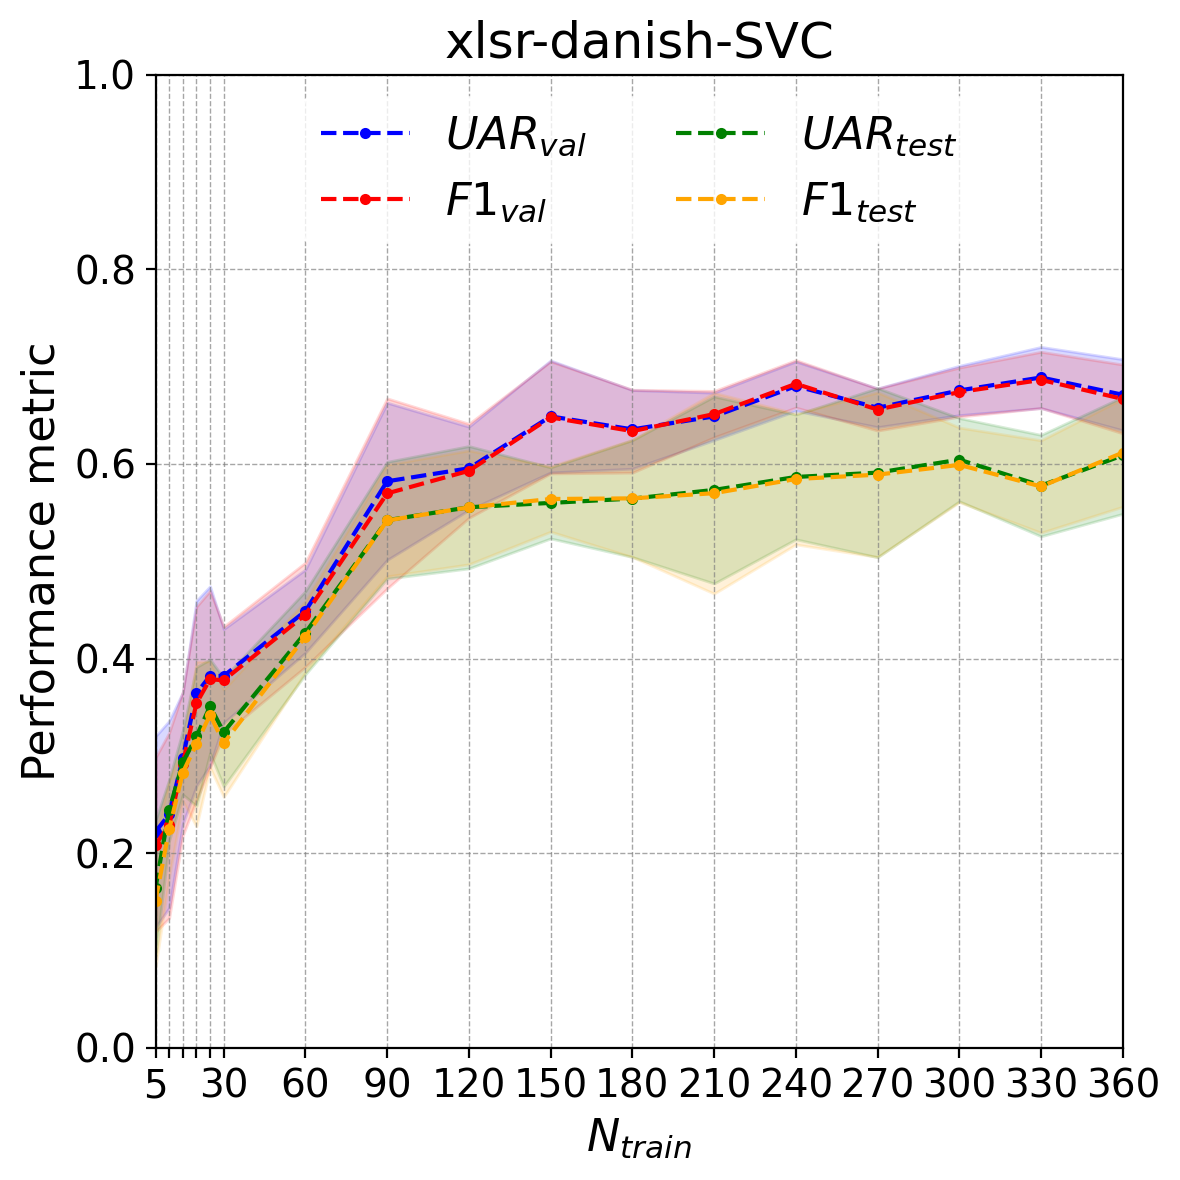

In [ ]:
plt.figure(figsize=(6, 6), dpi = 200)

plt.plot(splits, val_uar_means, 'b--.', label = '$UAR_{val}$')
plt.fill_between(splits, np.array(val_uar_means) - np.array(val_uar_stds), np.array(val_uar_means) + np.array(val_uar_stds), color='b', alpha=0.15)

plt.plot(splits, val_macro_f1_means, 'r--.', label = '$F1_{val}$')
plt.fill_between(splits, np.array(val_macro_f1_means) - np.array(val_macro_f1_stds), np.array(val_macro_f1_means) + np.array(val_macro_f1_stds), color='r', alpha=0.15)

plt.plot(splits, test_uar_means, 'g--.', label = '$UAR_{test}$')
plt.fill_between(splits, np.array(test_uar_means) - np.array(test_uar_stds), np.array(test_uar_means) + np.array(test_uar_stds), color='g', alpha=0.15)

plt.plot(splits, test_macro_f1_means, '--.', color = 'orange', label = '$F1_{test}$')
plt.fill_between(splits, np.array(test_macro_f1_means) - np.array(test_macro_f1_stds), np.array(test_macro_f1_means) + np.array(test_macro_f1_stds), color='orange', alpha=0.15)

plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

plt.ylim([0,1])
plt.xlim([5,360])
plt.xticks(ticks=splits, labels = [5, '', '', '', '', 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
plt.legend(loc='upper center', ncol = 2, facecolor='white', edgecolor = 'white')
plt.xlabel('$N_{train}$')
plt.title('xlsr-danish-SVC')
plt.ylabel('Performance metric')
plt.tight_layout()
plt.show()

In [ ]:
SVM_predictions = []
ntrain = [360, 330, 300, 270, 240, 210, 180, 150, 120, 90, 60, 30, 25, 20, 15, 10, 5]

for n in range(17):
  Ntrain = ntrain[n]
  val_pred, test_pred = [], []
  val_true, test_true = [], []

  for i in range(5):
    test_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntest{i+1}.csv')
    val_df = pd.read_csv(f'/content//Ntrain_experiment/K{i+1}_fold/nval{i+1}.csv')
    train_df = pd.read_csv(f'/content//Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_{Ntrain}.csv')

    val_pred_SVM, val_true_SVM, test_pred_SVM, test_true_SVM = SVM_Ntrain_experiment(train_df, val_df, test_df, get_preds = True)

    val_pred += val_pred_SVM
    val_true += val_true_SVM
    test_pred += test_pred_SVM
    test_true += test_true_SVM

  SVM_predictions.append({'val_pred': val_pred, 'val_true': val_true, 'test_pred': test_pred, 'test_true': test_true})

In [ ]:
SVM_predictions_360 = SVM_predictions[0]
SVM_predictions_330 = SVM_predictions[1]
SVM_predictions_300 = SVM_predictions[2]
SVM_predictions_270 = SVM_predictions[3]
SVM_predictions_240 = SVM_predictions[4]
SVM_predictions_210 = SVM_predictions[5]
SVM_predictions_180 = SVM_predictions[6]
SVM_predictions_150 = SVM_predictions[7]
SVM_predictions_120 = SVM_predictions[8]
SVM_predictions_90 = SVM_predictions[9]
SVM_predictions_60 = SVM_predictions[10]
SVM_predictions_30 = SVM_predictions[11]
SVM_predictions_25 = SVM_predictions[12]
SVM_predictions_20 = SVM_predictions[13]
SVM_predictions_15 = SVM_predictions[14]
SVM_predictions_10 = SVM_predictions[15]
SVM_predictions_5 = SVM_predictions[16]

In [ ]:
predictions = [SVM_predictions_360, SVM_predictions_330, SVM_predictions_300, SVM_predictions_270, SVM_predictions_240, SVM_predictions_210, SVM_predictions_180, SVM_predictions_150, SVM_predictions_120, SVM_predictions_90, SVM_predictions_60, SVM_predictions_30, SVM_predictions_25, SVM_predictions_20, SVM_predictions_15, SVM_predictions_10, SVM_predictions_5]

results = [SVM_results_360_df, SVM_results_330_df, SVM_results_300_df, SVM_results_270_df, SVM_results_240_df, SVM_results_210_df, SVM_results_180_df, SVM_results_150_df, SVM_results_120_df, SVM_results_90_df, SVM_results_60_df, SVM_results_30_df, SVM_results_25_df, SVM_results_20_df, SVM_results_15_df, SVM_results_10_df, SVM_results_5_df]

In [ ]:
data = []

for split, result, preds in zip(splits, results[::-1], predictions[::-1]):
  val_uar, val_f1 = compute_metrics(preds['val_true'], preds['val_pred'])
  test_uar, test_f1 = compute_metrics(preds['test_true'], preds['test_pred'])
  data.append({
      'split': split,
      'uar_val': (round(val_uar, 2), round(result['val_uar'].std(), 2)),
      'f1_macro_val': (round(val_f1, 2), round(result['val_macro_f1'].std(), 2)),
      'uar_test': (round(test_uar, 2), round(result['test_uar'].std(), 2)),
      'f1_macro_test': (round(test_f1, 2), round(result['test_macro_f1'].std(), 2)),
  })

results_df = pd.DataFrame(data)

In [ ]:
results_df

split       uar_val  f1_macro_val      uar_test f1_macro_test
0       5   (0.22, 0.1)  (0.22, 0.09)  (0.16, 0.07)  (0.16, 0.07)
1      10   (0.24, 0.1)   (0.23, 0.1)  (0.24, 0.03)  (0.23, 0.05)
2      15   (0.3, 0.07)  (0.29, 0.07)  (0.29, 0.03)  (0.29, 0.03)
3      20   (0.36, 0.1)   (0.35, 0.1)  (0.32, 0.07)  (0.32, 0.08)
4      25  (0.38, 0.09)  (0.38, 0.09)  (0.35, 0.05)  (0.35, 0.05)
5      30  (0.38, 0.05)  (0.38, 0.06)  (0.32, 0.06)  (0.32, 0.06)
6      60  (0.45, 0.04)  (0.45, 0.05)  (0.43, 0.04)  (0.43, 0.04)
7      90  (0.58, 0.08)   (0.58, 0.1)  (0.54, 0.06)  (0.55, 0.06)
8     120   (0.6, 0.04)   (0.6, 0.05)  (0.56, 0.06)  (0.56, 0.06)
9     150  (0.65, 0.06)  (0.65, 0.06)  (0.56, 0.04)  (0.56, 0.03)
10    180  (0.64, 0.04)  (0.63, 0.04)  (0.56, 0.06)  (0.57, 0.06)
11    210  (0.65, 0.02)  (0.65, 0.02)   (0.57, 0.1)   (0.58, 0.1)
12    240  (0.68, 0.03)  (0.68, 0.02)  (0.59, 0.06)  (0.59, 0.07)
13    270  (0.66, 0.02)  (0.66, 0.02)  (0.59, 0.09)  (0.59, 0.08)
14    300  (0.68, 0.03)  (0.68, 0.03)   (0.6, 0.04)  (0.61, 0.04)
15    330  (0.69, 0.03)  (0.69, 0.03)  (0.58, 0.05)  (0.58, 0.05)
16    360  (0.67, 0.04)  (0.67, 0.04)  (0.61, 0.06)  (0.61, 0.06)

### Transfer to EMODB

In [ ]:
EmoTale_w2v2_FT_dim_features = load_features('EmoTale_v2', 'w2v2 FT danish', include_info = True)
EmoTale_w2v2_FT_dim_features['language'] = [path[22:24] for path in EmoTale_w2v2_FT_dim_features['path']]
EmoTale_w2v2_FT_dim_features = EmoTale_w2v2_FT_dim_features[EmoTale_w2v2_FT_dim_features['language'] == 'DK']
EmoTale_w2v2_FT_dim_features.drop('language', axis = 1, inplace = True)

In [ ]:
EMODB_w2v2_FT_dim_features = load_features('EMODB', 'w2v2 FT danish', include_info = True)

In [ ]:
idx_to_emo_dict = {0: 'anger', 1: 'boredom', 2: 'happiness', 3: 'neutral', 4: 'sadness'}

In [ ]:
def SVM_Ntrain_experiment_EMODB(train_df, test_df, get_preds = False):
  # Load w2v2 FT dim features
  train_df = pd.merge(EmoTale_w2v2_FT_dim_features, train_df['path'], on = 'path')
  test_df = pd.merge(EMODB_w2v2_FT_dim_features, test_df['path'], on = 'path')

  clf = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(SVC(kernel = 'linear', random_state=42, probability = True))
  )

  train_x = train_df.iloc[:,4:]
  train_y = train_df['emotion']
  clf.fit(train_x, train_y)

  train_true, train_pred = train_df['emotion'], clf.predict(train_df.iloc[:,4:])
  test_true, test_pred = test_df['emotion'], clf.predict(test_df.iloc[:,4:])
  logits = clf.predict_proba(test_df.iloc[:,4:])

  train_uar, train_macro_f1 = compute_metrics(train_true, train_pred)
  test_uar, test_macro_f1 = compute_metrics(test_true, test_pred)

  if get_preds:
    return test_pred.tolist(), test_true.tolist()
  else:
    return {'train_uar': train_uar, 'train_macro_f1': train_macro_f1, 'test_uar': test_uar, 'test_macro_f1': test_macro_f1}

In [ ]:
SVM_EMODB_results = []
SVM_predictions = []

test_true, test_pred = [], []

for i in range(5):
  test_df = df_EMODB[df_EMODB['emotion'].isin(['anger', 'happiness', 'sadness', 'neutral', 'boredom'])].reset_index(drop=True)

  train_df_360 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_360.csv')
  train_df_330 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_330.csv')
  train_df_300 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_300.csv')

  SVM_EMODB_results.append(SVM_Ntrain_experiment_EMODB(train_df_360, test_df))

  test_pred_SVM, test_true_SVM = SVM_Ntrain_experiment_EMODB(train_df_360, test_df, get_preds = True)
  test_pred += test_pred_SVM
  test_true += test_true_SVM

SVM_predictions.append({'test_pred': test_pred, 'test_true': test_true})

In [ ]:
pd.DataFrame(SVM_EMODB_results)['test_uar'].std()

0.042548519845550366

In [ ]:
pd.DataFrame(SVM_EMODB_results)['test_macro_f1'].std()

0.05061516952230057

In [ ]:
compute_metrics(SVM_predictions[0]['test_true'], SVM_predictions[0]['test_pred'])

(0.5288913651435194, 0.48188839125212074)

## Few-shot for w2v2 FT dim

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def classify_emotions(test_df, mean_representations, distance_metric = 'cosine'):
    """
    Classify emotions for each row in the test dataset based on softmax of the cosine distances to the mean emotion representations.

    Parameters:
    test_df (pd.DataFrame): Test dataset containing feature columns.
    mean_representations (pd.DataFrame): DataFrame with mean emotion representations.

    Returns:
    pd.DataFrame: Test dataset with additional columns for predicted emotions and class probabilities.
    """
    feature_columns = [str(i) for i in range(1024)] # 768 for w2v2 base
    predicted_emotions = []
    class_probabilities = []

    for index, row in test_df.iterrows():
        distances = []

        if distance_metric == 'cosine':
          # Calculate cosine distance to each mean emotion representation
          for emotion in mean_representations.index:
              distance = cosine(row[feature_columns], mean_representations.loc[emotion])
              distances.append(-distance)  # Negate distances for softmax (softmax prefers larger values)

        elif distance_metric == 'euclidean':
          # Calculate euclidean distance to each mean emotion representation
          for emotion in mean_representations.index:
              distance = euclidean(row[feature_columns], mean_representations.loc[emotion])
              distances.append(-distance)

        # Apply softmax to the negative distances
        probabilities = softmax(np.array(distances))

        # Determine the predicted emotion
        predicted_emotion = mean_representations.index[np.argmax(probabilities)]

        predicted_emotions.append(predicted_emotion)
        class_probabilities.append(probabilities)

    # Add the predicted emotions and class probabilities to the test dataframe
    test_df['predicted_emotion'] = predicted_emotions
    test_df['class_probabilities'] = class_probabilities

    return test_df

In [ ]:
def few_shot_experiment(train_df, val_df, test_df, get_preds = False, distance_metric = 'cosine'):
  # Load w2v2 FT dim features
  train_df = pd.merge(EmoTale_w2v2_FT_dim_features, train_df['path'], on = 'path')
  val_df = pd.merge(EmoTale_w2v2_FT_dim_features, val_df['path'], on = 'path')
  test_df = pd.merge(EmoTale_w2v2_FT_dim_features, test_df['path'], on = 'path')

  # Compute mean representations for train set
  feature_columns = [str(i) for i in range(1024)] # 768 for w2v2 base
  mean_representations = train_df.groupby('emotion')[feature_columns].mean()

  # Classify emotions for the validation set
  classified_val_df = classify_emotions(val_df, mean_representations, distance_metric)

  # Classify emotions for the test set
  classified_test_df = classify_emotions(test_df, mean_representations, distance_metric)

  val_uar, val_macro_f1 = compute_metrics(val_df['emotion'], classified_val_df['predicted_emotion'])
  test_uar, test_macro_f1 = compute_metrics(test_df['emotion'], classified_test_df['predicted_emotion'])

  if get_preds:
    return classified_val_df['predicted_emotion'].tolist(), val_df['emotion'].tolist(), classified_test_df['predicted_emotion'].tolist(), test_df['emotion'].tolist()
  else:
    return {'val_uar': val_uar, 'val_macro_f1': val_macro_f1, 'test_uar': test_uar, 'test_macro_f1': test_macro_f1}

In [ ]:
EmoTale_w2v2_FT_dim_features = load_features('EmoTale_v2', 'w2v2 FT dim', include_info = True)
EmoTale_w2v2_FT_dim_features['language'] = [path[22:24] for path in EmoTale_w2v2_FT_dim_features['path']]
EmoTale_w2v2_FT_dim_features = EmoTale_w2v2_FT_dim_features[EmoTale_w2v2_FT_dim_features['language'] == 'DK']
EmoTale_w2v2_FT_dim_features.drop('language', axis = 1, inplace = True)

In [ ]:
FS_results_360 = []
FS_results_330 = []
FS_results_300 = []
FS_results_270 = []
FS_results_240 = []
FS_results_210 = []
FS_results_180 = []
FS_results_150 = []
FS_results_120 = []
FS_results_90 = []
FS_results_60 = []
FS_results_30 = []
FS_results_25 = []
FS_results_20 = []
FS_results_15 = []
FS_results_10 = []
FS_results_5 = []

for i in range(5):
  test_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntest{i+1}.csv')
  val_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/nval{i+1}.csv')

  train_df_360 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_360.csv')
  train_df_330 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_330.csv')
  train_df_300 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_300.csv')
  train_df_270 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_270.csv')
  train_df_240 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_240.csv')
  train_df_210 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_210.csv')
  train_df_180 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_180.csv')
  train_df_150 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_150.csv')
  train_df_120 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_120.csv')
  train_df_90 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_90.csv')
  train_df_60 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_60.csv')
  train_df_30 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_30.csv')
  train_df_25 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_25.csv')
  train_df_20 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_20.csv')
  train_df_15 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_15.csv')
  train_df_10 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_10.csv')
  train_df_5 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_5.csv')

  FS_results_360.append(few_shot_experiment(train_df_360, val_df, test_df))
  FS_results_330.append(few_shot_experiment(train_df_330, val_df, test_df))
  FS_results_300.append(few_shot_experiment(train_df_300, val_df, test_df))
  FS_results_270.append(few_shot_experiment(train_df_270, val_df, test_df))
  FS_results_240.append(few_shot_experiment(train_df_240, val_df, test_df))
  FS_results_210.append(few_shot_experiment(train_df_210, val_df, test_df))
  FS_results_180.append(few_shot_experiment(train_df_180, val_df, test_df))
  FS_results_150.append(few_shot_experiment(train_df_150, val_df, test_df))
  FS_results_120.append(few_shot_experiment(train_df_120, val_df, test_df))
  FS_results_90.append(few_shot_experiment(train_df_90, val_df, test_df))
  FS_results_60.append(few_shot_experiment(train_df_60, val_df, test_df))
  FS_results_30.append(few_shot_experiment(train_df_30, val_df, test_df))
  FS_results_25.append(few_shot_experiment(train_df_25, val_df, test_df))
  FS_results_20.append(few_shot_experiment(train_df_20, val_df, test_df))
  FS_results_15.append(few_shot_experiment(train_df_15, val_df, test_df))
  FS_results_10.append(few_shot_experiment(train_df_10, val_df, test_df))
  FS_results_5.append(few_shot_experiment(train_df_5, val_df, test_df))

In [ ]:
FS_results_360_df = pd.DataFrame(FS_results_360)
FS_results_330_df = pd.DataFrame(FS_results_330)
FS_results_300_df = pd.DataFrame(FS_results_300)
FS_results_270_df = pd.DataFrame(FS_results_270)
FS_results_240_df = pd.DataFrame(FS_results_240)
FS_results_210_df = pd.DataFrame(FS_results_210)
FS_results_180_df = pd.DataFrame(FS_results_180)
FS_results_150_df = pd.DataFrame(FS_results_150)
FS_results_120_df = pd.DataFrame(FS_results_120)
FS_results_90_df = pd.DataFrame(FS_results_90)
FS_results_60_df = pd.DataFrame(FS_results_60)
FS_results_30_df = pd.DataFrame(FS_results_30)
FS_results_25_df = pd.DataFrame(FS_results_25)
FS_results_20_df = pd.DataFrame(FS_results_20)
FS_results_15_df = pd.DataFrame(FS_results_15)
FS_results_10_df = pd.DataFrame(FS_results_10)
FS_results_5_df = pd.DataFrame(FS_results_5)

In [ ]:
splits = [5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
val_uar_means = [FS_results_5_df['val_uar'].mean(), FS_results_10_df['val_uar'].mean(), FS_results_15_df['val_uar'].mean(), FS_results_20_df['val_uar'].mean(), FS_results_25_df['val_uar'].mean(), FS_results_30_df['val_uar'].mean(), FS_results_60_df['val_uar'].mean(), FS_results_90_df['val_uar'].mean(), FS_results_120_df['val_uar'].mean(), FS_results_150_df['val_uar'].mean(), FS_results_180_df['val_uar'].mean(), FS_results_210_df['val_uar'].mean(), FS_results_240_df['val_uar'].mean(), FS_results_270_df['val_uar'].mean(), FS_results_300_df['val_uar'].mean(), FS_results_330_df['val_uar'].mean(), FS_results_360_df['val_uar'].mean()]

val_uar_stds = [FS_results_5_df['val_uar'].std(), FS_results_10_df['val_uar'].std(), FS_results_15_df['val_uar'].std(), FS_results_20_df['val_uar'].std(), FS_results_25_df['val_uar'].std(), FS_results_30_df['val_uar'].std(), FS_results_60_df['val_uar'].std(), FS_results_90_df['val_uar'].std(), FS_results_120_df['val_uar'].std(), FS_results_150_df['val_uar'].std(), FS_results_180_df['val_uar'].std(), FS_results_210_df['val_uar'].std(), FS_results_240_df['val_uar'].std(), FS_results_270_df['val_uar'].std(), FS_results_300_df['val_uar'].std(), FS_results_330_df['val_uar'].std(), FS_results_360_df['val_uar'].std()]

val_macro_f1_means = [FS_results_5_df['val_macro_f1'].mean(), FS_results_10_df['val_macro_f1'].mean(), FS_results_15_df['val_macro_f1'].mean(), FS_results_20_df['val_macro_f1'].mean(), FS_results_25_df['val_macro_f1'].mean(), FS_results_30_df['val_macro_f1'].mean(), FS_results_60_df['val_macro_f1'].mean(), FS_results_90_df['val_macro_f1'].mean(), FS_results_120_df['val_macro_f1'].mean(), FS_results_150_df['val_macro_f1'].mean(), FS_results_180_df['val_macro_f1'].mean(), FS_results_210_df['val_macro_f1'].mean(), FS_results_240_df['val_macro_f1'].mean(), FS_results_270_df['val_macro_f1'].mean(), FS_results_300_df['val_macro_f1'].mean(), FS_results_330_df['val_macro_f1'].mean(), FS_results_360_df['val_macro_f1'].mean()]

val_macro_f1_stds = [FS_results_5_df['val_macro_f1'].std(), FS_results_10_df['val_macro_f1'].std(), FS_results_15_df['val_macro_f1'].std(), FS_results_20_df['val_macro_f1'].std(), FS_results_25_df['val_macro_f1'].std(), FS_results_30_df['val_macro_f1'].std(), FS_results_60_df['val_macro_f1'].std(), FS_results_90_df['val_macro_f1'].std(), FS_results_120_df['val_macro_f1'].std(), FS_results_150_df['val_macro_f1'].std(), FS_results_180_df['val_macro_f1'].std(), FS_results_210_df['val_macro_f1'].std(), FS_results_240_df['val_macro_f1'].std(), FS_results_270_df['val_macro_f1'].std(), FS_results_300_df['val_macro_f1'].std(), FS_results_330_df['val_macro_f1'].std(), FS_results_360_df['val_macro_f1'].std()]

test_uar_means = [FS_results_5_df['test_uar'].mean(), FS_results_10_df['test_uar'].mean(), FS_results_15_df['test_uar'].mean(), FS_results_20_df['test_uar'].mean(), FS_results_25_df['test_uar'].mean(), FS_results_30_df['test_uar'].mean(), FS_results_60_df['test_uar'].mean(), FS_results_90_df['test_uar'].mean(), FS_results_120_df['test_uar'].mean(), FS_results_150_df['test_uar'].mean(), FS_results_180_df['test_uar'].mean(), FS_results_210_df['test_uar'].mean(), FS_results_240_df['test_uar'].mean(), FS_results_270_df['test_uar'].mean(), FS_results_300_df['test_uar'].mean(), FS_results_330_df['test_uar'].mean(), FS_results_360_df['test_uar'].mean()]

test_uar_stds = [FS_results_5_df['test_uar'].std(), FS_results_10_df['test_uar'].std(), FS_results_15_df['test_uar'].std(), FS_results_20_df['test_uar'].std(), FS_results_25_df['test_uar'].std(), FS_results_30_df['test_uar'].std(), FS_results_60_df['test_uar'].std(), FS_results_90_df['test_uar'].std(), FS_results_120_df['test_uar'].std(), FS_results_150_df['test_uar'].std(), FS_results_180_df['test_uar'].std(), FS_results_210_df['test_uar'].std(), FS_results_240_df['test_uar'].std(), FS_results_270_df['test_uar'].std(), FS_results_300_df['test_uar'].std(), FS_results_330_df['test_uar'].std(), FS_results_360_df['test_uar'].std()]

test_macro_f1_means = [FS_results_5_df['test_macro_f1'].mean(), FS_results_10_df['test_macro_f1'].mean(), FS_results_15_df['test_macro_f1'].mean(), FS_results_20_df['test_macro_f1'].mean(), FS_results_25_df['test_macro_f1'].mean(), FS_results_30_df['test_macro_f1'].mean(), FS_results_60_df['test_macro_f1'].mean(), FS_results_90_df['test_macro_f1'].mean(), FS_results_120_df['test_macro_f1'].mean(), FS_results_150_df['test_macro_f1'].mean(), FS_results_180_df['test_macro_f1'].mean(), FS_results_210_df['test_macro_f1'].mean(), FS_results_240_df['test_macro_f1'].mean(), FS_results_270_df['test_macro_f1'].mean(), FS_results_300_df['test_macro_f1'].mean(), FS_results_330_df['test_macro_f1'].mean(), FS_results_360_df['test_macro_f1'].mean()]

test_macro_f1_stds = [FS_results_5_df['test_macro_f1'].std(), FS_results_10_df['test_macro_f1'].std(), FS_results_15_df['test_macro_f1'].std(), FS_results_20_df['test_macro_f1'].std(), FS_results_25_df['test_macro_f1'].std(), FS_results_30_df['test_macro_f1'].std(), FS_results_60_df['test_macro_f1'].std(), FS_results_90_df['test_macro_f1'].std(), FS_results_120_df['test_macro_f1'].std(), FS_results_150_df['test_macro_f1'].std(), FS_results_180_df['test_macro_f1'].std(), FS_results_210_df['test_macro_f1'].std(), FS_results_240_df['test_macro_f1'].std(), FS_results_270_df['test_macro_f1'].std(), FS_results_300_df['test_macro_f1'].std(), FS_results_330_df['test_macro_f1'].std(), FS_results_360_df['test_macro_f1'].std()]


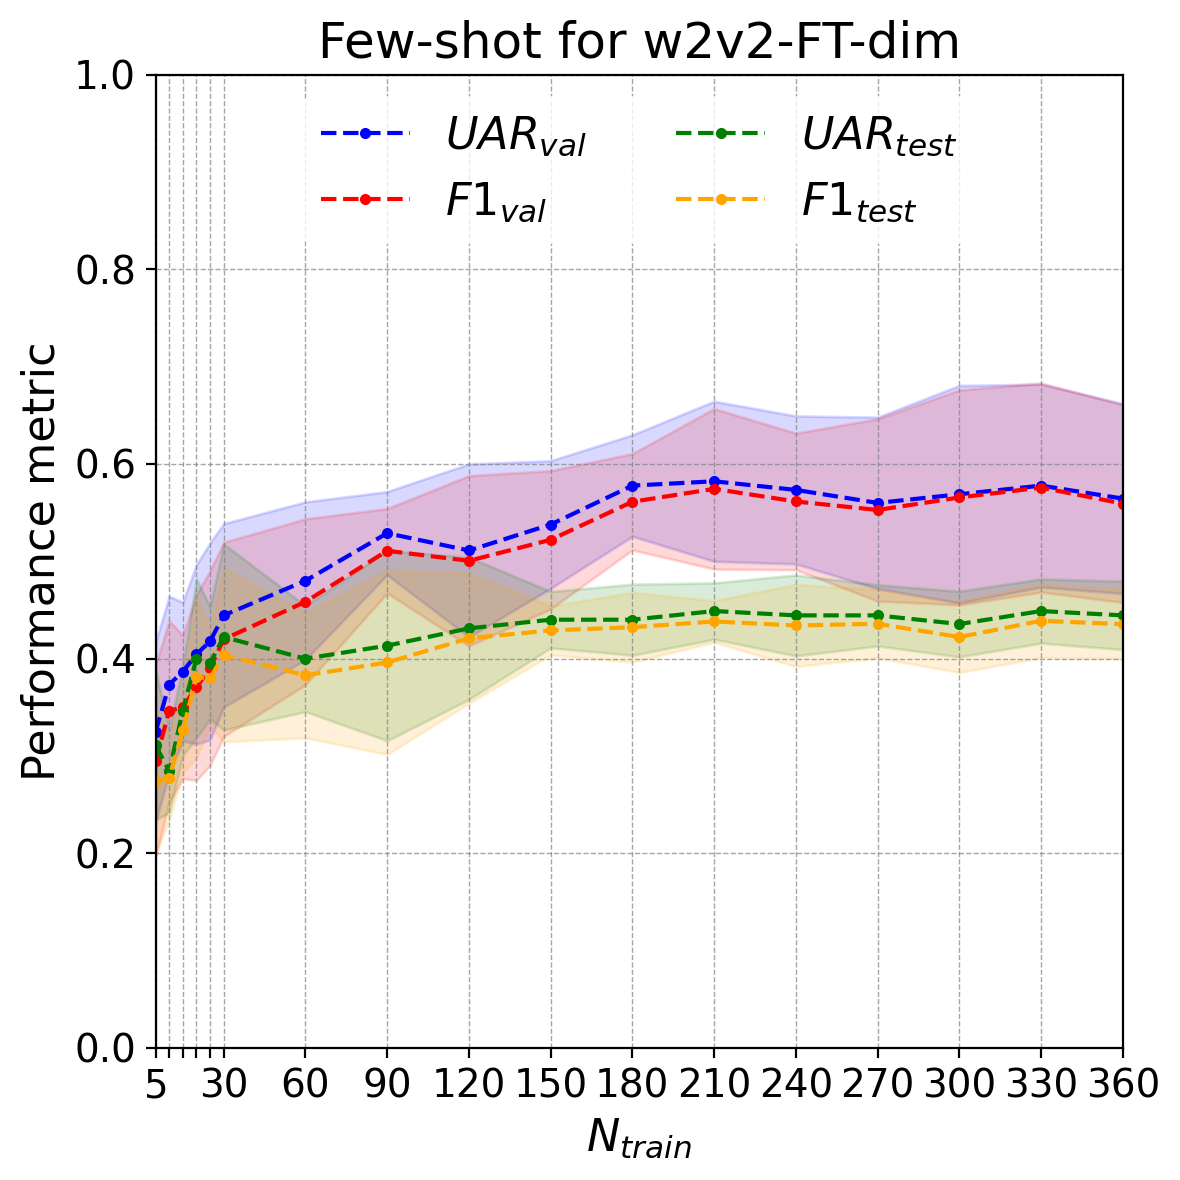

In [ ]:
plt.figure(figsize=(6, 6), dpi = 200)

plt.plot(splits, val_uar_means, 'b--.', label = '$UAR_{val}$')
plt.fill_between(splits, np.array(val_uar_means) - np.array(val_uar_stds), np.array(val_uar_means) + np.array(val_uar_stds), color='b', alpha=0.15)

plt.plot(splits, val_macro_f1_means, 'r--.', label = '$F1_{val}$')
plt.fill_between(splits, np.array(val_macro_f1_means) - np.array(val_macro_f1_stds), np.array(val_macro_f1_means) + np.array(val_macro_f1_stds), color='r', alpha=0.15)

plt.plot(splits, test_uar_means, 'g--.', label = '$UAR_{test}$')
plt.fill_between(splits, np.array(test_uar_means) - np.array(test_uar_stds), np.array(test_uar_means) + np.array(test_uar_stds), color='g', alpha=0.15)

plt.plot(splits, test_macro_f1_means, '--.', color = 'orange', label = '$F1_{test}$')
plt.fill_between(splits, np.array(test_macro_f1_means) - np.array(test_macro_f1_stds), np.array(test_macro_f1_means) + np.array(test_macro_f1_stds), color='orange', alpha=0.15)

plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

plt.ylim([0,1])
plt.xlim([5,360])
plt.xticks(ticks=splits, labels = [5, '', '', '', '', 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
plt.legend(loc='upper center', ncol = 2, facecolor='white', edgecolor = 'white')
plt.xlabel('$N_{train}$')
plt.ylabel('Performance metric')
plt.title('Few-shot for w2v2-FT-dim')
plt.tight_layout()
plt.show()

In [ ]:
FS_predictions = []
ntrain = [360, 330, 300, 270, 240, 210, 180, 150, 120, 90, 60, 30, 25, 20, 15, 10, 5]

for n in range(17):
  Ntrain = ntrain[n]
  val_pred, test_pred = [], []
  val_true, test_true = [], []

  for i in range(5):
    test_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntest{i+1}.csv')
    val_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/nval{i+1}.csv')
    train_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_{Ntrain}.csv')

    val_pred_FS, val_true_FS, test_pred_FS, test_true_FS = few_shot_experiment(train_df, val_df, test_df, get_preds = True)

    val_pred += val_pred_FS
    val_true += val_true_FS
    test_pred += test_pred_FS
    test_true += test_true_FS

  FS_predictions.append({'val_pred': val_pred, 'val_true': val_true, 'test_pred': test_pred, 'test_true': test_true})

In [ ]:
FS_predictions_360 = FS_predictions[0]
FS_predictions_330 = FS_predictions[1]
FS_predictions_300 = FS_predictions[2]
FS_predictions_270 = FS_predictions[3]
FS_predictions_240 = FS_predictions[4]
FS_predictions_210 = FS_predictions[5]
FS_predictions_180 = FS_predictions[6]
FS_predictions_150 = FS_predictions[7]
FS_predictions_120 = FS_predictions[8]
FS_predictions_90 = FS_predictions[9]
FS_predictions_60 = FS_predictions[10]
FS_predictions_30 = FS_predictions[11]
FS_predictions_25 = FS_predictions[12]
FS_predictions_20 = FS_predictions[13]
FS_predictions_15 = FS_predictions[14]
FS_predictions_10 = FS_predictions[15]
FS_predictions_5 = FS_predictions[16]

In [ ]:
predictions = [FS_predictions_360, FS_predictions_330, FS_predictions_300, FS_predictions_270, FS_predictions_240, FS_predictions_210, FS_predictions_180, FS_predictions_150, FS_predictions_120, FS_predictions_90, FS_predictions_60, FS_predictions_30, FS_predictions_25, FS_predictions_20, FS_predictions_15, FS_predictions_10, FS_predictions_5]

results = [FS_results_360_df, FS_results_330_df, FS_results_300_df, FS_results_270_df, FS_results_240_df, FS_results_210_df, FS_results_180_df, FS_results_150_df, FS_results_120_df, FS_results_90_df, FS_results_60_df, FS_results_30_df, FS_results_25_df, FS_results_20_df, FS_results_15_df, FS_results_10_df, FS_results_5_df]

In [ ]:
data = []

for split, result, preds in zip(splits, results[::-1], predictions[::-1]):
  val_uar, val_f1 = compute_metrics(preds['val_true'], preds['val_pred'])
  test_uar, test_f1 = compute_metrics(preds['test_true'], preds['test_pred'])
  data.append({
      'split': split,
      'uar_val': (round(val_uar, 2), round(result['val_uar'].std(), 2)),
      'f1_macro_val': (round(val_f1, 2), round(result['val_macro_f1'].std(), 2)),
      'uar_test': (round(test_uar, 2), round(result['test_uar'].std(), 2)),
      'f1_macro_test': (round(test_f1, 2), round(result['test_macro_f1'].std(), 2)),
  })

results_df = pd.DataFrame(data)

In [ ]:
results_df

split       uar_val  f1_macro_val      uar_test f1_macro_test
0       5  (0.32, 0.09)   (0.31, 0.1)  (0.31, 0.08)  (0.29, 0.07)
1      10  (0.37, 0.09)  (0.35, 0.09)  (0.28, 0.04)  (0.28, 0.04)
2      15  (0.39, 0.07)  (0.36, 0.07)  (0.35, 0.05)  (0.34, 0.04)
3      20   (0.4, 0.09)   (0.39, 0.1)   (0.4, 0.08)   (0.4, 0.08)
4      25   (0.42, 0.1)    (0.4, 0.1)   (0.4, 0.06)  (0.39, 0.05)
5      30  (0.44, 0.09)   (0.42, 0.1)   (0.42, 0.1)  (0.41, 0.09)
6      60  (0.48, 0.08)  (0.46, 0.09)   (0.4, 0.05)   (0.4, 0.06)
7      90  (0.53, 0.04)  (0.52, 0.04)   (0.41, 0.1)   (0.4, 0.09)
8     120  (0.51, 0.09)   (0.5, 0.09)  (0.43, 0.07)  (0.43, 0.07)
9     150  (0.54, 0.07)  (0.53, 0.07)  (0.44, 0.03)  (0.44, 0.03)
10    180  (0.58, 0.05)  (0.57, 0.05)  (0.44, 0.04)  (0.44, 0.04)
11    210  (0.58, 0.08)  (0.58, 0.08)  (0.45, 0.03)  (0.44, 0.02)
12    240  (0.57, 0.08)  (0.56, 0.07)  (0.44, 0.04)  (0.44, 0.04)
13    270  (0.56, 0.09)  (0.55, 0.09)  (0.44, 0.03)  (0.44, 0.04)
14    300  (0.57, 0.11)  (0.56, 0.11)  (0.44, 0.03)  (0.43, 0.04)
15    330   (0.58, 0.1)  (0.57, 0.11)  (0.45, 0.03)  (0.45, 0.04)
16    360   (0.56, 0.1)   (0.56, 0.1)  (0.44, 0.04)  (0.44, 0.04)

### Transfer to EMODB

In [ ]:
EmoTale_w2v2_FT_dim_features = load_features('EmoTale_v2', 'w2v2 FT dim', include_info = True)
EmoTale_w2v2_FT_dim_features['language'] = [path[22:24] for path in EmoTale_w2v2_FT_dim_features['path']]
EmoTale_w2v2_FT_dim_features = EmoTale_w2v2_FT_dim_features[EmoTale_w2v2_FT_dim_features['language'] == 'DK']
EmoTale_w2v2_FT_dim_features.drop('language', axis = 1, inplace = True)

In [ ]:
EMODB_w2v2_FT_dim_features = load_features('EMODB', 'w2v2 FT dim', include_info = True)

In [ ]:
def classify_emotions_EMODB(test_df, mean_representations, distance_metric = 'cosine'):
    feature_columns = [str(i) for i in range(1024)] # 768 for w2v2 base
    predicted_emotions = []
    class_probabilities = []

    for index, row in test_df.iterrows():
        distances = []

        if distance_metric == 'cosine':
          # Calculate cosine distance to each mean emotion representation
          for emotion in mean_representations.index:
              distance = cosine(row[feature_columns], mean_representations.loc[emotion])
              distances.append(-distance)  # Negate distances for softmax (softmax prefers larger values)

        elif distance_metric == 'euclidean':
          # Calculate euclidean distance to each mean emotion representation
          for emotion in mean_representations.index:
              distance = euclidean(row[feature_columns], mean_representations.loc[emotion])
              distances.append(-distance)

        # Apply softmax to the negative distances
        probabilities = softmax(np.array(distances))

        # Determine the predicted emotion
        predicted_emotion = mean_representations.index[np.argmax(probabilities)]
        predicted_emotions.append(predicted_emotion)
        class_probabilities.append(probabilities)

    # Add the predicted emotions and class probabilities to the test dataframe
    test_df['predicted_emotion'] = predicted_emotions
    test_df['class_probabilities'] = class_probabilities

    return test_df

In [ ]:
def few_shot_experiment_EMODB(train_df, test_df, get_preds = False, distance_metric = 'cosine'):
  # Load w2v2 FT dim features
  train_df = pd.merge(EmoTale_w2v2_FT_dim_features, train_df['path'], on = 'path')
  test_df = pd.merge(EMODB_w2v2_FT_dim_features, test_df['path'], on = 'path')

  # Compute mean representations for train set
  feature_columns = [str(i) for i in range(1024)] # 768 for w2v2 base
  mean_representations = train_df.groupby('emotion')[feature_columns].mean()

  # Classify emotions for the test set
  classified_test_df = classify_emotions_EMODB(test_df, mean_representations, distance_metric)

  test_uar, test_macro_f1 = compute_metrics(test_df['emotion'], classified_test_df['predicted_emotion'])

  if get_preds:
    return classified_test_df['predicted_emotion'].tolist(), test_df['emotion'].tolist()
  else:
    return {'test_uar': test_uar, 'test_macro_f1': test_macro_f1}

In [ ]:
FS_EMODB_results = []
FS_predictions = []

test_true, test_pred = [], []

for i in range(5):
  test_df = df_EMODB[df_EMODB['emotion'].isin(['anger', 'happiness', 'sadness', 'neutral', 'boredom'])].reset_index(drop=True)

  train_df_360 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_360.csv')
  train_df_330 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_330.csv')
  train_df_300 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_300.csv')

  FS_EMODB_results.append(few_shot_experiment_EMODB(train_df_330, test_df))

  test_pred_SVM, test_true_SVM = few_shot_experiment_EMODB(train_df_330, test_df, get_preds = True)
  test_pred += test_pred_SVM
  test_true += test_true_SVM

FS_predictions.append({'test_pred': test_pred, 'test_true': test_true})

In [ ]:
pd.DataFrame(FS_EMODB_results)

test_uar  test_macro_f1
0  0.508282       0.478546
1  0.515927       0.496261
2  0.472297       0.420737
3  0.479631       0.456244
4  0.555462       0.546315

## Few-shot for w2v2 xlsr danish

In [ ]:
EmoTale_w2v2_FT_dim_features = load_features('EmoTale_v2', 'w2v2 FT danish', include_info = True)
EmoTale_w2v2_FT_dim_features['language'] = [path[22:24] for path in EmoTale_w2v2_FT_dim_features['path']]
EmoTale_w2v2_FT_dim_features = EmoTale_w2v2_FT_dim_features[EmoTale_w2v2_FT_dim_features['language'] == 'DK']
EmoTale_w2v2_FT_dim_features.drop('language', axis = 1, inplace = True)

In [ ]:
FT_results_360 = []
FT_results_330 = []
FT_results_300 = []
FT_results_270 = []
FT_results_240 = []
FT_results_210 = []
FT_results_180 = []
FT_results_150 = []
FT_results_120 = []
FT_results_90 = []
FT_results_60 = []
FT_results_30 = []
FT_results_25 = []
FT_results_20 = []
FT_results_15 = []
FT_results_10 = []
FT_results_5 = []

for i in range(5):
  test_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntest{i+1}.csv')
  val_df = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/nval{i+1}.csv')

  train_df_360 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_360.csv')
  train_df_330 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_330.csv')
  train_df_300 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_300.csv')
  train_df_270 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_270.csv')
  train_df_240 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_240.csv')
  train_df_210 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_210.csv')
  train_df_180 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_180.csv')
  train_df_150 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_150.csv')
  train_df_120 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_120.csv')
  train_df_90 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_90.csv')
  train_df_60 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_60.csv')
  train_df_30 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_30.csv')
  train_df_25 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_25.csv')
  train_df_20 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_20.csv')
  train_df_15 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_15.csv')
  train_df_10 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_10.csv')
  train_df_5 = pd.read_csv(f'/content/Ntrain_experiment/K{i+1}_fold/ntrain{i+1}_5.csv')

  FT_results_360.append(few_shot_experiment(train_df_360, val_df, test_df))
  FT_results_330.append(few_shot_experiment(train_df_330, val_df, test_df))
  FT_results_300.append(few_shot_experiment(train_df_300, val_df, test_df))
  FT_results_270.append(few_shot_experiment(train_df_270, val_df, test_df))
  FT_results_240.append(few_shot_experiment(train_df_240, val_df, test_df))
  FT_results_210.append(few_shot_experiment(train_df_210, val_df, test_df))
  FT_results_180.append(few_shot_experiment(train_df_180, val_df, test_df))
  FT_results_150.append(few_shot_experiment(train_df_150, val_df, test_df))
  FT_results_120.append(few_shot_experiment(train_df_120, val_df, test_df))
  FT_results_90.append(few_shot_experiment(train_df_90, val_df, test_df))
  FT_results_60.append(few_shot_experiment(train_df_60, val_df, test_df))
  FT_results_30.append(few_shot_experiment(train_df_30, val_df, test_df))
  FT_results_25.append(few_shot_experiment(train_df_25, val_df, test_df))
  FT_results_20.append(few_shot_experiment(train_df_20, val_df, test_df))
  FT_results_15.append(few_shot_experiment(train_df_15, val_df, test_df))
  FT_results_10.append(few_shot_experiment(train_df_10, val_df, test_df))
  FT_results_5.append(few_shot_experiment(train_df_5, val_df, test_df))

In [ ]:
FT_results_360_df = pd.DataFrame(FT_results_360)
FT_results_330_df = pd.DataFrame(FT_results_330)
FT_results_300_df = pd.DataFrame(FT_results_300)
FT_results_270_df = pd.DataFrame(FT_results_270)
FT_results_240_df = pd.DataFrame(FT_results_240)
FT_results_210_df = pd.DataFrame(FT_results_210)
FT_results_180_df = pd.DataFrame(FT_results_180)
FT_results_150_df = pd.DataFrame(FT_results_150)
FT_results_120_df = pd.DataFrame(FT_results_120)
FT_results_90_df = pd.DataFrame(FT_results_90)
FT_results_60_df = pd.DataFrame(FT_results_60)
FT_results_30_df = pd.DataFrame(FT_results_30)
FT_results_25_df = pd.DataFrame(FT_results_25)
FT_results_20_df = pd.DataFrame(FT_results_20)
FT_results_15_df = pd.DataFrame(FT_results_15)
FT_results_10_df = pd.DataFrame(FT_results_10)
FT_results_5_df = pd.DataFrame(FT_results_5)

In [ ]:
splits = [5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
val_uar_means = [FT_results_5_df['val_uar'].mean(), FT_results_10_df['val_uar'].mean(), FT_results_15_df['val_uar'].mean(), FT_results_20_df['val_uar'].mean(), FT_results_25_df['val_uar'].mean(), FT_results_30_df['val_uar'].mean(), FT_results_60_df['val_uar'].mean(), FT_results_90_df['val_uar'].mean(), FT_results_120_df['val_uar'].mean(), FT_results_150_df['val_uar'].mean(), FT_results_180_df['val_uar'].mean(), FT_results_210_df['val_uar'].mean(), FT_results_240_df['val_uar'].mean(), FT_results_270_df['val_uar'].mean(), FT_results_300_df['val_uar'].mean(), FT_results_330_df['val_uar'].mean(), FT_results_360_df['val_uar'].mean()]

val_uar_stds = [FT_results_5_df['val_uar'].std(), FT_results_10_df['val_uar'].std(), FT_results_15_df['val_uar'].std(), FT_results_20_df['val_uar'].std(), FT_results_25_df['val_uar'].std(), FT_results_30_df['val_uar'].std(), FT_results_60_df['val_uar'].std(), FT_results_90_df['val_uar'].std(), FT_results_120_df['val_uar'].std(), FT_results_150_df['val_uar'].std(), FT_results_180_df['val_uar'].std(), FT_results_210_df['val_uar'].std(), FT_results_240_df['val_uar'].std(), FT_results_270_df['val_uar'].std(), FT_results_300_df['val_uar'].std(), FT_results_330_df['val_uar'].std(), FT_results_360_df['val_uar'].std()]

val_macro_f1_means = [FT_results_5_df['val_macro_f1'].mean(), FT_results_10_df['val_macro_f1'].mean(), FT_results_15_df['val_macro_f1'].mean(), FT_results_20_df['val_macro_f1'].mean(), FT_results_25_df['val_macro_f1'].mean(), FT_results_30_df['val_macro_f1'].mean(), FT_results_60_df['val_macro_f1'].mean(), FT_results_90_df['val_macro_f1'].mean(), FT_results_120_df['val_macro_f1'].mean(), FT_results_150_df['val_macro_f1'].mean(), FT_results_180_df['val_macro_f1'].mean(), FT_results_210_df['val_macro_f1'].mean(), FT_results_240_df['val_macro_f1'].mean(), FT_results_270_df['val_macro_f1'].mean(), FT_results_300_df['val_macro_f1'].mean(), FT_results_330_df['val_macro_f1'].mean(), FT_results_360_df['val_macro_f1'].mean()]

val_macro_f1_stds = [FT_results_5_df['val_macro_f1'].std(), FT_results_10_df['val_macro_f1'].std(), FT_results_15_df['val_macro_f1'].std(), FT_results_20_df['val_macro_f1'].std(), FT_results_25_df['val_macro_f1'].std(), FT_results_30_df['val_macro_f1'].std(), FT_results_60_df['val_macro_f1'].std(), FT_results_90_df['val_macro_f1'].std(), FT_results_120_df['val_macro_f1'].std(), FT_results_150_df['val_macro_f1'].std(), FT_results_180_df['val_macro_f1'].std(), FT_results_210_df['val_macro_f1'].std(), FT_results_240_df['val_macro_f1'].std(), FT_results_270_df['val_macro_f1'].std(), FT_results_300_df['val_macro_f1'].std(), FT_results_330_df['val_macro_f1'].std(), FT_results_360_df['val_macro_f1'].std()]

test_uar_means = [FT_results_5_df['test_uar'].mean(), FT_results_10_df['test_uar'].mean(), FT_results_15_df['test_uar'].mean(), FT_results_20_df['test_uar'].mean(), FT_results_25_df['test_uar'].mean(), FT_results_30_df['test_uar'].mean(), FT_results_60_df['test_uar'].mean(), FT_results_90_df['test_uar'].mean(), FT_results_120_df['test_uar'].mean(), FT_results_150_df['test_uar'].mean(), FT_results_180_df['test_uar'].mean(), FT_results_210_df['test_uar'].mean(), FT_results_240_df['test_uar'].mean(), FT_results_270_df['test_uar'].mean(), FT_results_300_df['test_uar'].mean(), FT_results_330_df['test_uar'].mean(), FT_results_360_df['test_uar'].mean()]

test_uar_stds = [FT_results_5_df['test_uar'].std(), FT_results_10_df['test_uar'].std(), FT_results_15_df['test_uar'].std(), FT_results_20_df['test_uar'].std(), FT_results_25_df['test_uar'].std(), FT_results_30_df['test_uar'].std(), FT_results_60_df['test_uar'].std(), FT_results_90_df['test_uar'].std(), FT_results_120_df['test_uar'].std(), FT_results_150_df['test_uar'].std(), FT_results_180_df['test_uar'].std(), FT_results_210_df['test_uar'].std(), FT_results_240_df['test_uar'].std(), FT_results_270_df['test_uar'].std(), FT_results_300_df['test_uar'].std(), FT_results_330_df['test_uar'].std(), FT_results_360_df['test_uar'].std()]

test_macro_f1_means = [FT_results_5_df['test_macro_f1'].mean(), FT_results_10_df['test_macro_f1'].mean(), FT_results_15_df['test_macro_f1'].mean(), FT_results_20_df['test_macro_f1'].mean(), FT_results_25_df['test_macro_f1'].mean(), FT_results_30_df['test_macro_f1'].mean(), FT_results_60_df['test_macro_f1'].mean(), FT_results_90_df['test_macro_f1'].mean(), FT_results_120_df['test_macro_f1'].mean(), FT_results_150_df['test_macro_f1'].mean(), FT_results_180_df['test_macro_f1'].mean(), FT_results_210_df['test_macro_f1'].mean(), FT_results_240_df['test_macro_f1'].mean(), FT_results_270_df['test_macro_f1'].mean(), FT_results_300_df['test_macro_f1'].mean(), FT_results_330_df['test_macro_f1'].mean(), FT_results_360_df['test_macro_f1'].mean()]

test_macro_f1_stds = [FT_results_5_df['test_macro_f1'].std(), FT_results_10_df['test_macro_f1'].std(), FT_results_15_df['test_macro_f1'].std(), FT_results_20_df['test_macro_f1'].std(), FT_results_25_df['test_macro_f1'].std(), FT_results_30_df['test_macro_f1'].std(), FT_results_60_df['test_macro_f1'].std(), FT_results_90_df['test_macro_f1'].std(), FT_results_120_df['test_macro_f1'].std(), FT_results_150_df['test_macro_f1'].std(), FT_results_180_df['test_macro_f1'].std(), FT_results_210_df['test_macro_f1'].std(), FT_results_240_df['test_macro_f1'].std(), FT_results_270_df['test_macro_f1'].std(), FT_results_300_df['test_macro_f1'].std(), FT_results_330_df['test_macro_f1'].std(), FT_results_360_df['test_macro_f1'].std()]

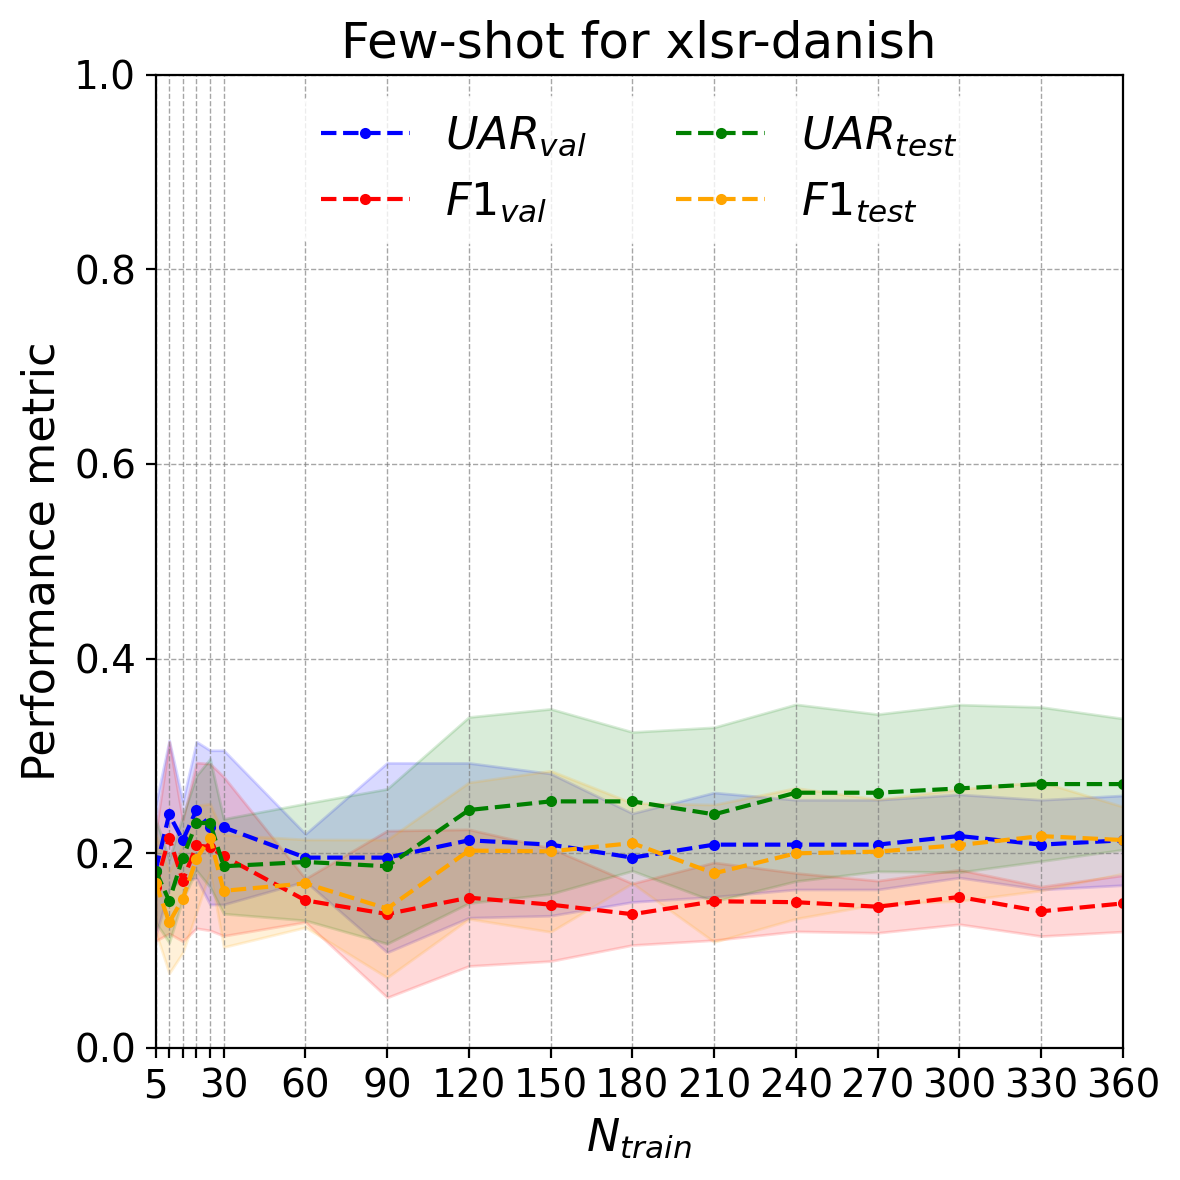

In [ ]:
plt.figure(figsize=(6, 6), dpi = 200)

plt.plot(splits, val_uar_means, 'b--.', label = '$UAR_{val}$')
plt.fill_between(splits, np.array(val_uar_means) - np.array(val_uar_stds), np.array(val_uar_means) + np.array(val_uar_stds), color='b', alpha=0.15)

plt.plot(splits, val_macro_f1_means, 'r--.', label = '$F1_{val}$')
plt.fill_between(splits, np.array(val_macro_f1_means) - np.array(val_macro_f1_stds), np.array(val_macro_f1_means) + np.array(val_macro_f1_stds), color='r', alpha=0.15)

plt.plot(splits, test_uar_means, 'g--.', label = '$UAR_{test}$')
plt.fill_between(splits, np.array(test_uar_means) - np.array(test_uar_stds), np.array(test_uar_means) + np.array(test_uar_stds), color='g', alpha=0.15)

plt.plot(splits, test_macro_f1_means, '--.', color = 'orange', label = '$F1_{test}$')
plt.fill_between(splits, np.array(test_macro_f1_means) - np.array(test_macro_f1_stds), np.array(test_macro_f1_means) + np.array(test_macro_f1_stds), color='orange', alpha=0.15)

plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

plt.ylim([0,1])
plt.xlim([5,360])
plt.xticks(ticks=splits, labels = [5, '', '', '', '', 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
plt.legend(loc='upper center', ncol = 2, facecolor='white', edgecolor = 'white')
plt.xlabel('$N_{train}$')
plt.title('Few-shot for xlsr-danish')
plt.ylabel('Performance metric')
plt.tight_layout()
plt.show()

## Pairwise t-test

In [ ]:
uars = [Finetuned_results_330_df['test_uar'],
        SVM_dim_results_330_df['test_uar'],
        SVM_danish_results_360_df['test_uar'],
        FS_results_330_df['test_uar']]

In [ ]:
f1s = [Finetuned_results_330_df['test_macro_f1'],
       SVM_dim_results_330_df['test_macro_f1'],
       SVM_danish_results_360_df['test_macro_f1'],
       FS_results_330_df['test_macro_f1']]

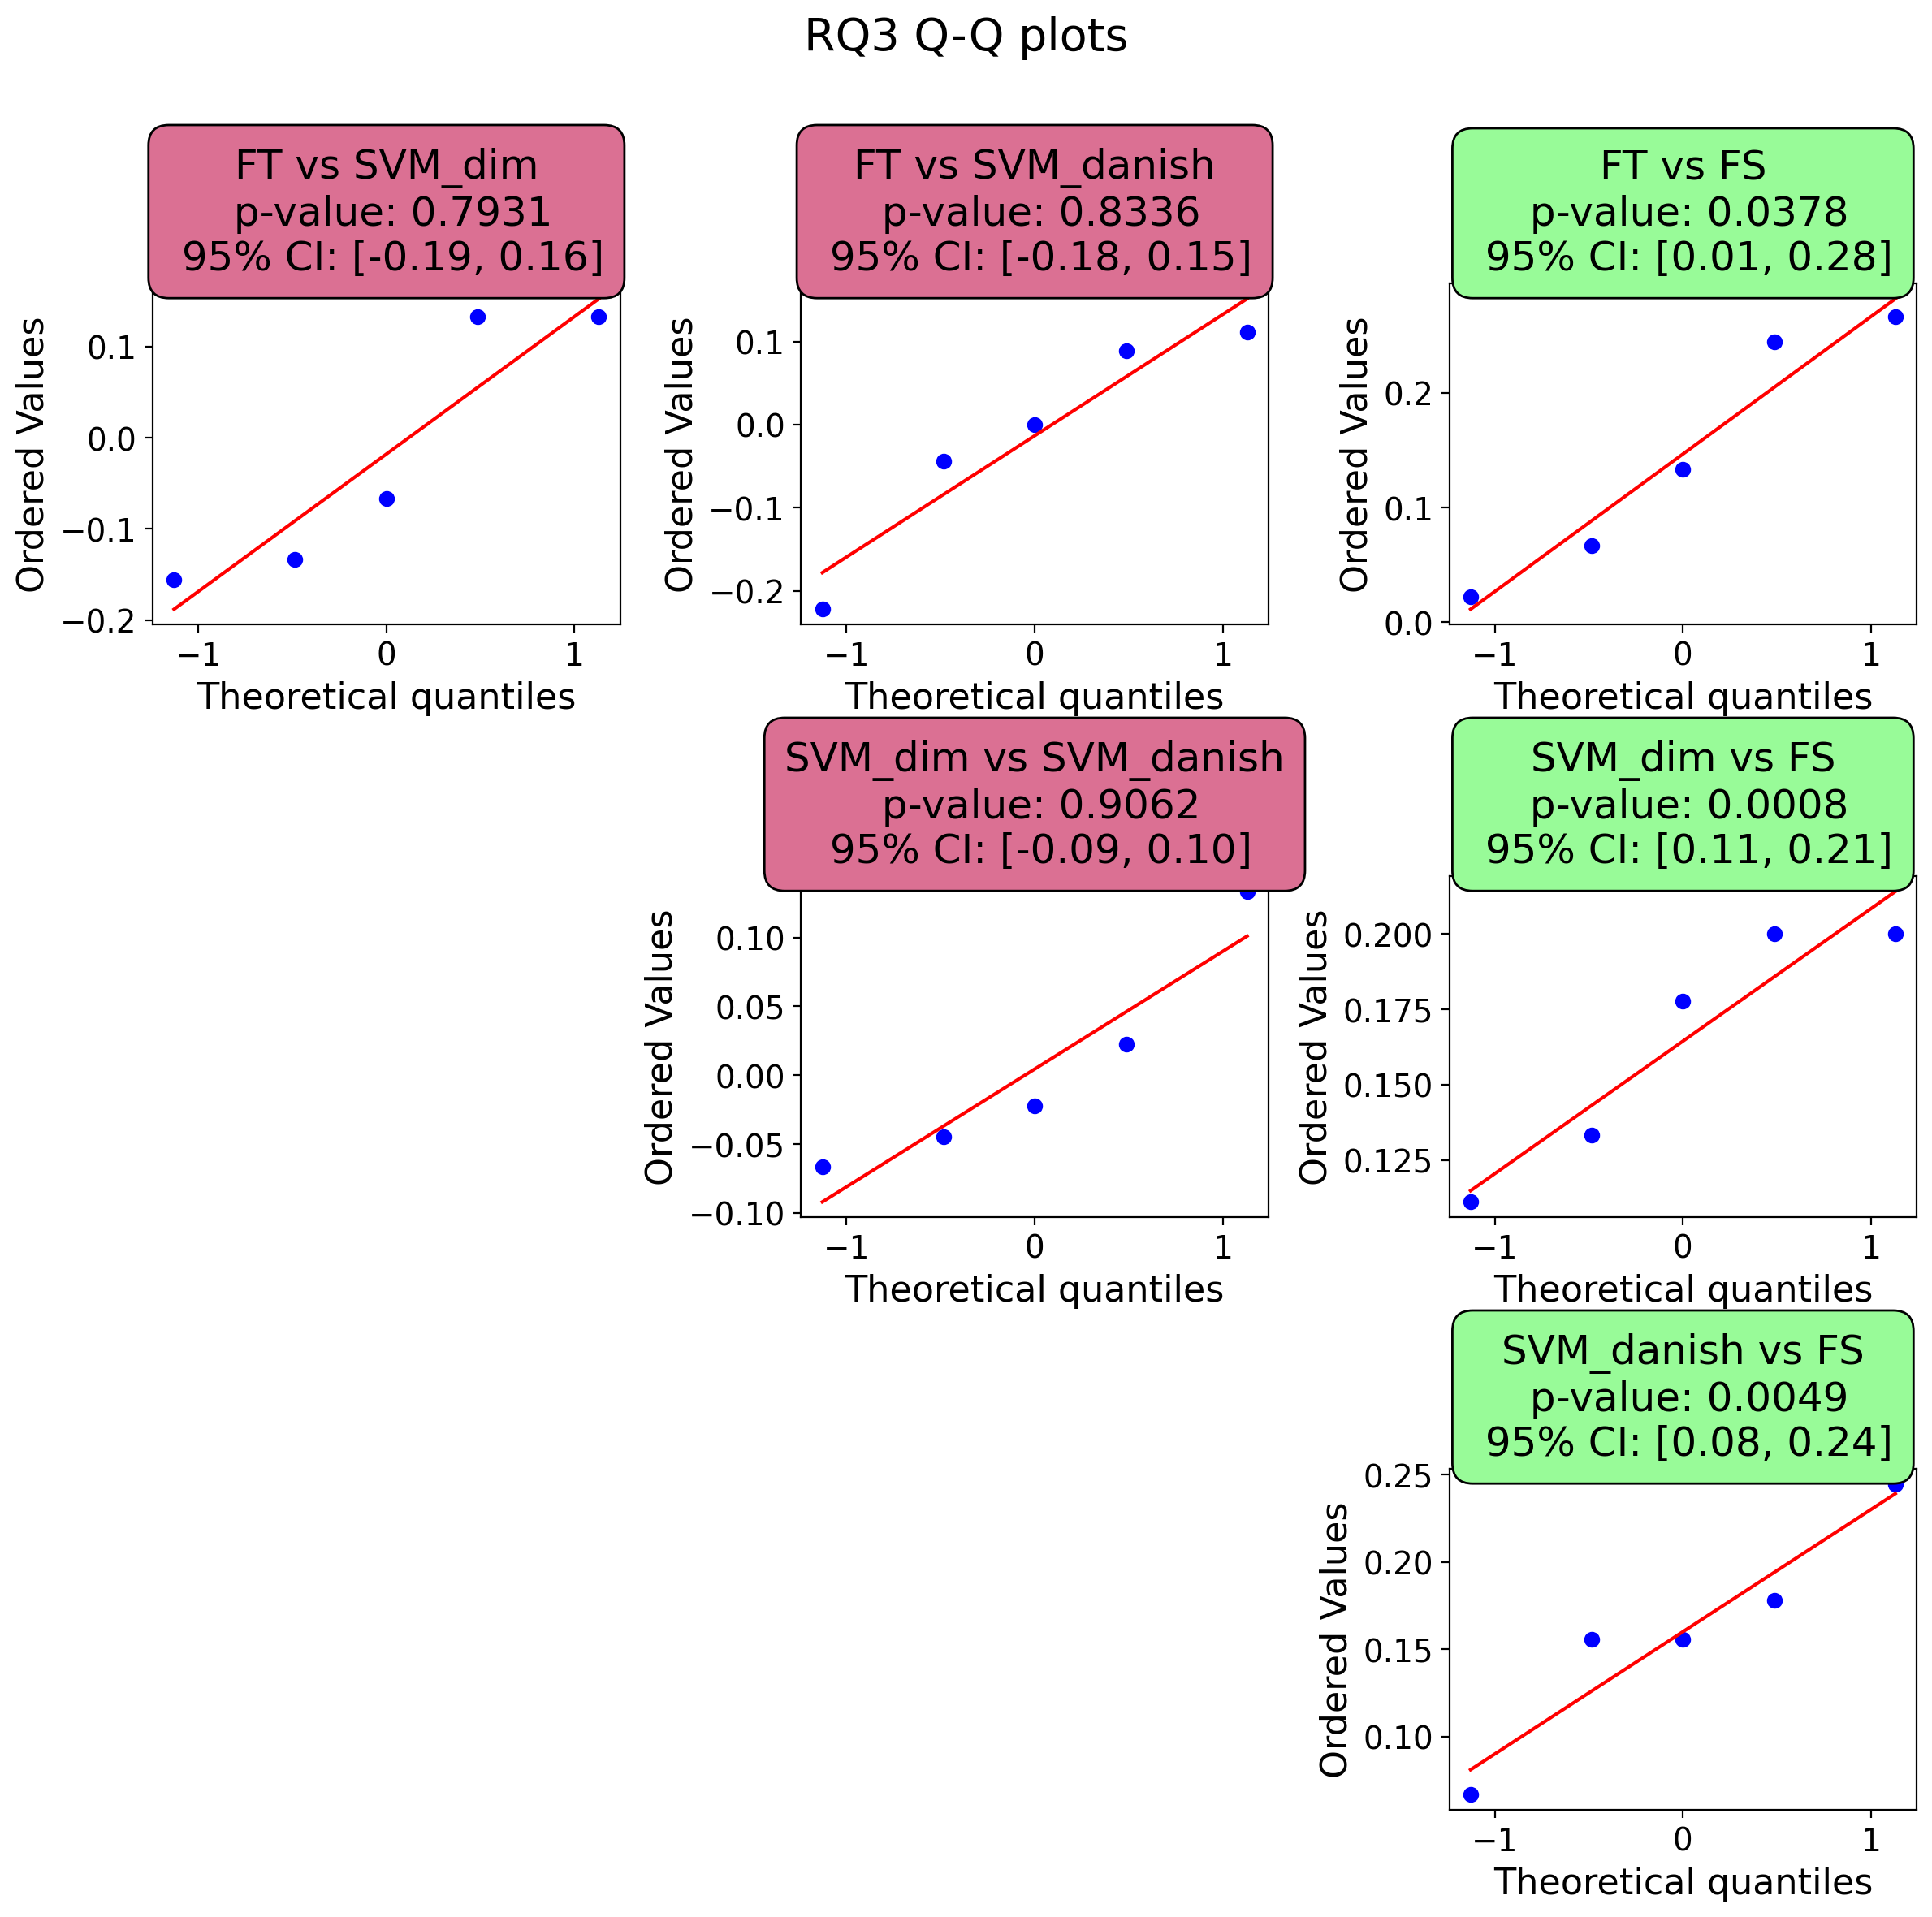

In [ ]:
model_names = ['FT', 'SVM_dim', 'SVM_danish', 'FS']

results = {}
plt.figure(figsize=(12, 12), dpi=200)
plt.suptitle("RQ3 Q-Q plots")

model_performances = uars
for i in range(len(model_performances)):
    for j in range(i + 1, len(model_performances)):
        model1 = model_performances[i]
        model2 = model_performances[j]
        differences = model1 - model2
        name1 = model_names[i]
        name2 = model_names[j]

        mean_diff = np.mean(differences)
        sem_diff = stats.sem(differences)
        df = len(differences) - 1
        t_stat, p_value = ttest_rel(model1, model2)
        ci = stats.t.interval(0.95, df, loc=mean_diff, scale=sem_diff) #95% confidence interval
        results[f'{name1} vs {name2}'] = (t_stat, p_value)

        # Create a subplot for each pairwise comparison
        plt.subplot(len(model_performances) - 1, len(model_performances) - 1, i * (len(model_performances) - 1) + j)
        stats.probplot(differences, dist="norm", plot=plt)
        if p_value < 0.05:
          plt.title(f'{name1} vs {name2}\n p-value: {p_value:.4f}\n 95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]',bbox={'facecolor': 'palegreen', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})
        else:
          plt.title(f'{name1} vs {name2}\n p-value: {p_value:.4f}\n 95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]',bbox={'facecolor': 'palevioletred', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


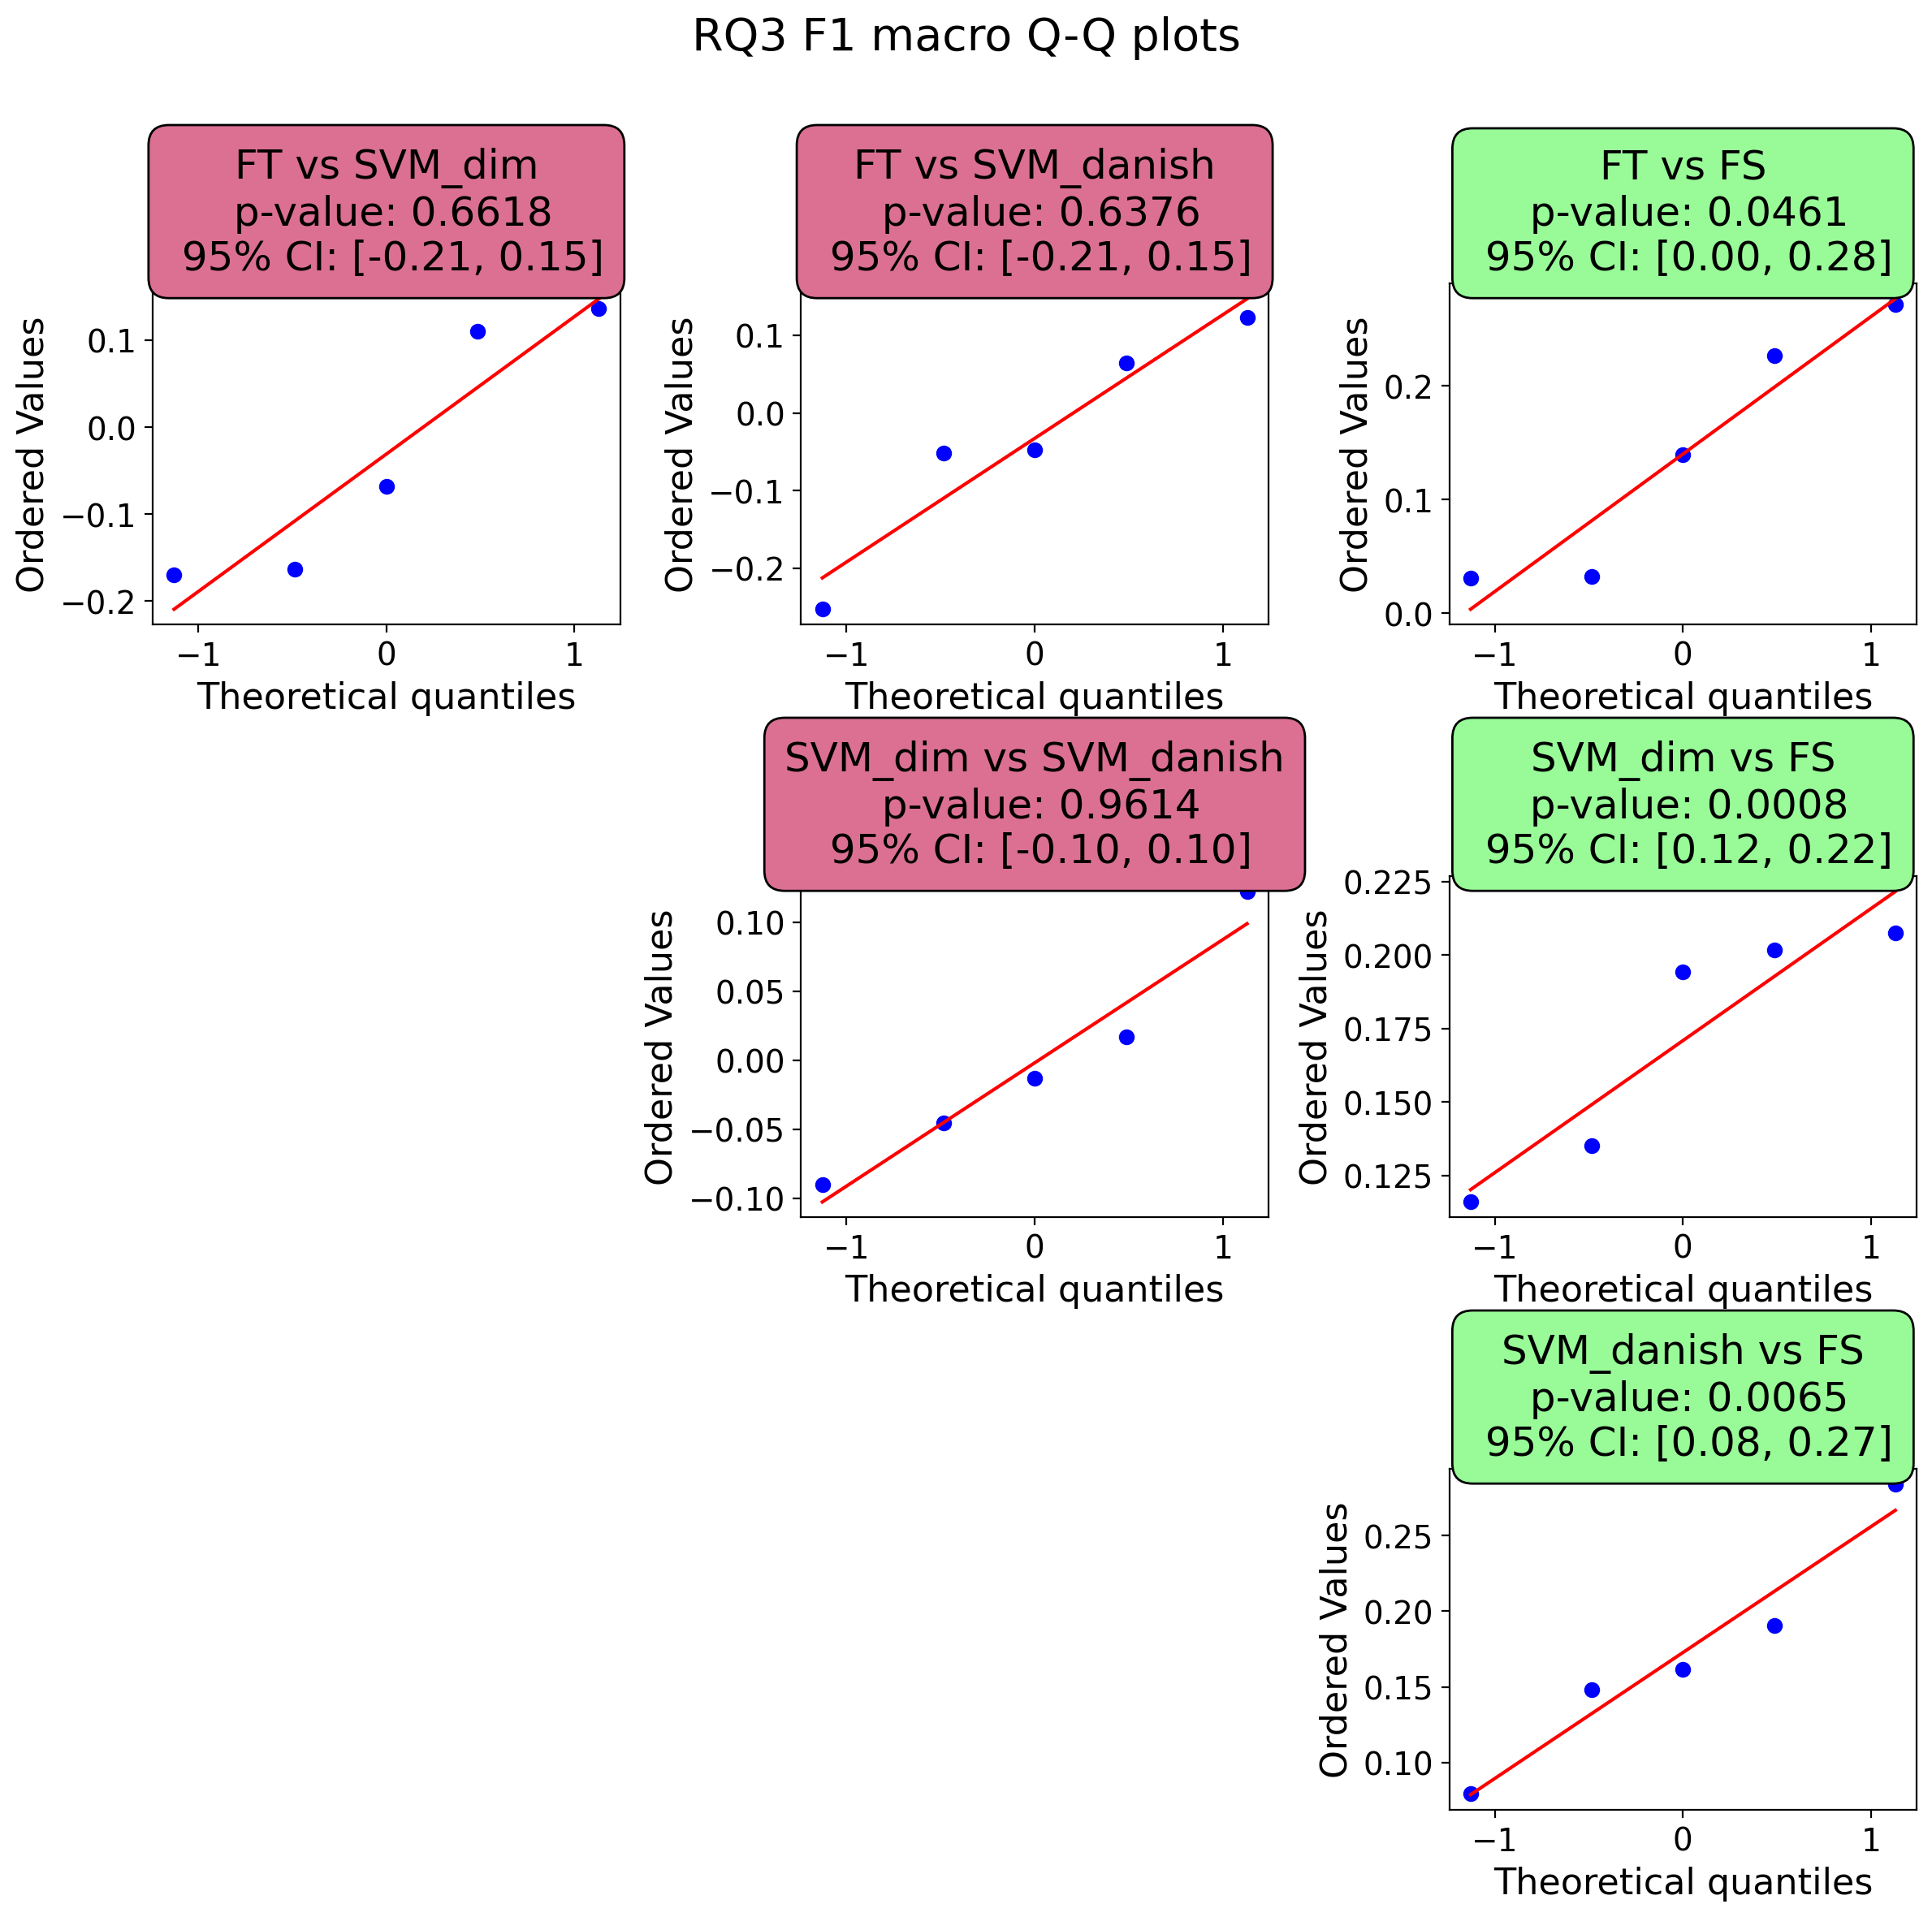

In [ ]:
model_names = ['FT', 'SVM_dim', 'SVM_danish', 'FS']

results = {}
plt.figure(figsize=(12, 12), dpi=200)
plt.suptitle("RQ3 F1 macro Q-Q plots")

model_performances = f1s
for i in range(len(model_performances)):
    for j in range(i + 1, len(model_performances)):
        model1 = model_performances[i]
        model2 = model_performances[j]
        differences = model1 - model2
        name1 = model_names[i]
        name2 = model_names[j]

        mean_diff = np.mean(differences)
        sem_diff = stats.sem(differences)
        df = len(differences) - 1
        t_stat, p_value = ttest_rel(model1, model2)
        ci = stats.t.interval(0.95, df, loc=mean_diff, scale=sem_diff) #95% confidence interval
        results[f'{name1} vs {name2}'] = (t_stat, p_value)

        # Create a subplot for each pairwise comparison
        plt.subplot(len(model_performances) - 1, len(model_performances) - 1, i * (len(model_performances) - 1) + j)
        stats.probplot(differences, dist="norm", plot=plt)
        if p_value < 0.05:
          plt.title(f'{name1} vs {name2}\n p-value: {p_value:.4f}\n 95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]',bbox={'facecolor': 'palegreen', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})
        else:
          plt.title(f'{name1} vs {name2}\n p-value: {p_value:.4f}\n 95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]',bbox={'facecolor': 'palevioletred', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('/content/drive/MyDrive/MSc_data/RQ1_results/EMODB_ttest.png', bbox_inches='tight')
plt.show()
